# ENVIRONMENT

In [2]:
import tensorflow as tf

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")



Version:  2.10.0
Eager mode:  True
GPU is NOT AVAILABLE


In [583]:
! pip install nltk sklearn numpy pandas

In [584]:
! pip install --upgrade pandas

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/afterlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/afterlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/afterlab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/afterlab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


import re
import string 



from nltk.tokenize import RegexpTokenizer
LEMMA = nltk.WordNetLemmatizer()
STOP_WORDS = stopwords.words('english')



from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_colwidth", 5000)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
# pd.set_option("precision", 3)
pd.set_option("display.max_colwidth", None)

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.dpi"] = 150

sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 1

In [43]:
original_df = pd.read_json("./src/amazon/reviews_Digital_Music_5.json", lines=True)


# Introduction

You have seen the power of using data analytical techniques to help organizations make data-driven decisions and now want to extend these models into areas of machine learning and artificial intelligence. In this task, you will explore the use of neural networks and natural language processing (NLP).

In this task, you will choose a data file from the Web Links section. The available data sets are as follows:
- [Amazon Product Data set](http://jmcauley.ucsd.edu/data/amazon/)
- [UCSD Recommender Systems Data sets](https://cseweb.ucsd.edu/~jmcauley/datasets.html)
- UCI Sentiment Labeled Sentences Data set

For this task, you will build a neural network designed to learn word usage and context using NLP techniques. You will provide visualizations and a report, as well as build your network in an interactive development environment.

# Part I:  Research Question

## A.  Describe the purpose of this data analysis by doing the following:



### ✅ 1.  Summarize one research question that you will answer using neural network models and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset.

> Can we use a neural network and NLP on existing customer reviews and ratings to predict a user's sentiment on a piece music?


### ✅ 2.  Define the objectives or goals of the data analysis. Be sure the objectives or goals are reasonable within the scope of the research question and are represented in the available data.
> The goal of this analysis is to determine if we can predict positive or negative sentiment on a piece of music based off a user's word choice within their review.


### ✅3.  Identify a type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set.
> This analysis will use a Artificial neural network (ANN). A ANN "An RNN model is designed to recognize the sequential characteristics of data and thereafter using the patterns to predict the coming scenario." "But in the case of recurrent neural networks, the output from the previous steps is fed into the input of the current state"(https://www.educba.com/recurrent-neural-networks-rnn/). The inputs to the network will be sequental data in the form of lists of numerically encoded words.  

- https://www.analyticsvidhya.com/blog/2020/02/cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning/

- https://www.analyticsvidhya.com/blog/2017/12/introduction-to-recurrent-neural-networks/?utm_source=blog&utm_medium=cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning

- https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/



# Part II:  Data Preparation


## B.  Summarize the data cleaning process by doing the following:



### 0. Misc. Data Prep

In [40]:
TOKENIZER = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token = '[UNK]', lower=True)


In [41]:
def clean_text(s:str, tokenizer) -> str:
    tokens = [LEMMA.lemmatize(word=word) for word in s]

    # remove stop words     
    tokens = [word for word in tokens if word not in STOP_WORDS]

    # rejoin tokens into a string
    return " ".join(tokens)



def get_index(data, tokenizer, n=25,reverse=True):
    tokenizer.fit_on_texts(data)
    index = tokenizer.word_index
    
    sorted_index = dict(sorted(index.items(), key= lambda kv:(kv[1], kv[0]), reverse=reverse)[0:n])
    return tokenizer, len(index) + 1, sorted_index

In [9]:
original_df.shape

(64706, 9)

In [10]:
original_df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [12]:
original_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      64706 non-null  object
 1   asin            64706 non-null  object
 2   reviewerName    64529 non-null  object
 3   helpful         64706 non-null  object
 4   reviewText      64706 non-null  object
 5   overall         64706 non-null  int64 
 6   summary         64706 non-null  object
 7   unixReviewTime  64706 non-null  int64 
 8   reviewTime      64706 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.4+ MB


In [44]:
%%time
prep_df = original_df[["reviewText", "overall"]].copy()
prep_df = prep_df.rename(columns={"reviewText": "raw_text", "overall": "sentiment"})
prep_df["raw_word_count"] = prep_df.raw_text.apply(lambda x: len(x.split(" ")))

# track the text preparation transformations
text_stages_df = prep_df[["raw_text"]].head()

# drop reviews with neutral sentiment
prep_df = prep_df[prep_df.sentiment != 3]

# map sentiment scores to binary values (0 = negative, 1 = positive)
prep_df["pos_neg_sentiment"] = prep_df.sentiment.map(lambda x: 1 if x > 3 else 0 )

prep_df.head(1)

CPU times: user 644 ms, sys: 2.54 ms, total: 647 ms
Wall time: 646 ms


,raw_text,sentiment,raw_word_count,pos_neg_sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1


In [45]:
%%time

# strip white space and lowercase review
prep_df["clean_text"] = prep_df["raw_text"].str.strip().str.lower()
text_stages_df["cleanStage1"] = prep_df["clean_text"].head()

# remove non-word characters
prep_df["clean_text"] = prep_df["clean_text"].apply(lambda x: " ".join(RegexpTokenizer("[a-z-A-Z']+").tokenize(x)))
text_stages_df["cleanStage2"] = prep_df["clean_text"].head()

# Remove unusual characters: uppercase letters, punctuation marks, emoticons, and non-English characters.
prep_df["clean_text"] = prep_df["clean_text"].apply(lambda x: " ".join(tf.keras.preprocessing.text.text_to_word_sequence(x)))
text_stages_df["cleanStage3"] = prep_df["clean_text"].head()

# lemmatize and remove english stop words
prep_df["clean_text"] = prep_df["clean_text"].apply(lambda x: clean_text(s=x.split(" "), tokenizer=TOKENIZER))
text_stages_df["cleanStage4"] = prep_df["clean_text"].head()
prep_df["clean_word_count"] = prep_df.clean_text.apply(lambda x: len(x.split(" ")))


prep_df.head(1)


CPU times: user 52.6 s, sys: 128 ms, total: 52.7 s
Wall time: 52.9 s


,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93


In [124]:
text_stages_df

,raw_text,cleanStage1,cleanStage2,cleanStage3,cleanStage4
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!","it's hard to believe ""memory of trees"" came out 11 years ago;it has held up well over the passage of time.it's enya's last great album before the new age/pop of ""amarantine"" and ""day without rain."" back in 1995,enya still had her creative spark,her own voice.i agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""memory of trees"" is elegaic&majestic.;""pax deorum"" sounds like it is from a requiem mass,it is a dark threnody.unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,i don't find it disconcerting at all.""anywhere is"" is a hopeful song,looking to possibilities.""hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.i've always had a soft spot for this song.""on my way home"" is a triumphant ending about return.this is truly a masterpiece of new age music,a must for any enya fan!",it's hard to believe memory of trees came out years ago it has held up well over the passage of time it's enya's last great album before the new age pop of amarantine and day without rain back in enya still had her creative spark her own voice i agree with the reviewer who said that this is her saddest album it is melancholy bittersweet from the opening title song memory of trees is elegaic majestic pax deorum sounds like it is from a requiem mass it is a dark threnody unlike the reviewer who said that this has a disconcerting blend of spirituality sensuality i don't find it disconcerting at all anywhere is is a hopeful song looking to possibilities hope has a place is about love but it is up to the listener to decide if it is romantic platonic etc i've always had a soft spot for this song on my way home is a triumphant ending about return this is truly a masterpiece of new age music a must for any enya fan,it's hard to believe memory of trees came out years ago it has held up well over the passage of time it's enya's last great album before the new age pop of amarantine and day without rain back in enya still had her creative spark her own voice i agree with the reviewer who said that this is her saddest album it is melancholy bittersweet from the opening title song memory of trees is elegaic majestic pax deorum sounds like it is from a requiem mass it is a dark threnody unlike the reviewer who said that this has a disconcerting blend of spirituality sensuality i don't find it disconcerting at all anywhere is is a hopeful song looking to possibilities hope has a place is about love but it is up to the listener to decide if it is romantic platonic etc i've always had a soft spot for this song on my way home is a triumphant ending about return this is truly a masterpiece of new age music a must for any enya fan,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative sp

### ✅ 1.  Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:


#### Missing Values

In [17]:
pd.DataFrame(original_df.isnull().sum(), columns=["# Nulls"])
f"{original_df.isnull().sum().sum():,} Total Null Cells"


,# Nulls
reviewerID,0
asin,0
reviewerName,177
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0


'177 Total Null Cells'

#### Sentiment Counts (1-5)

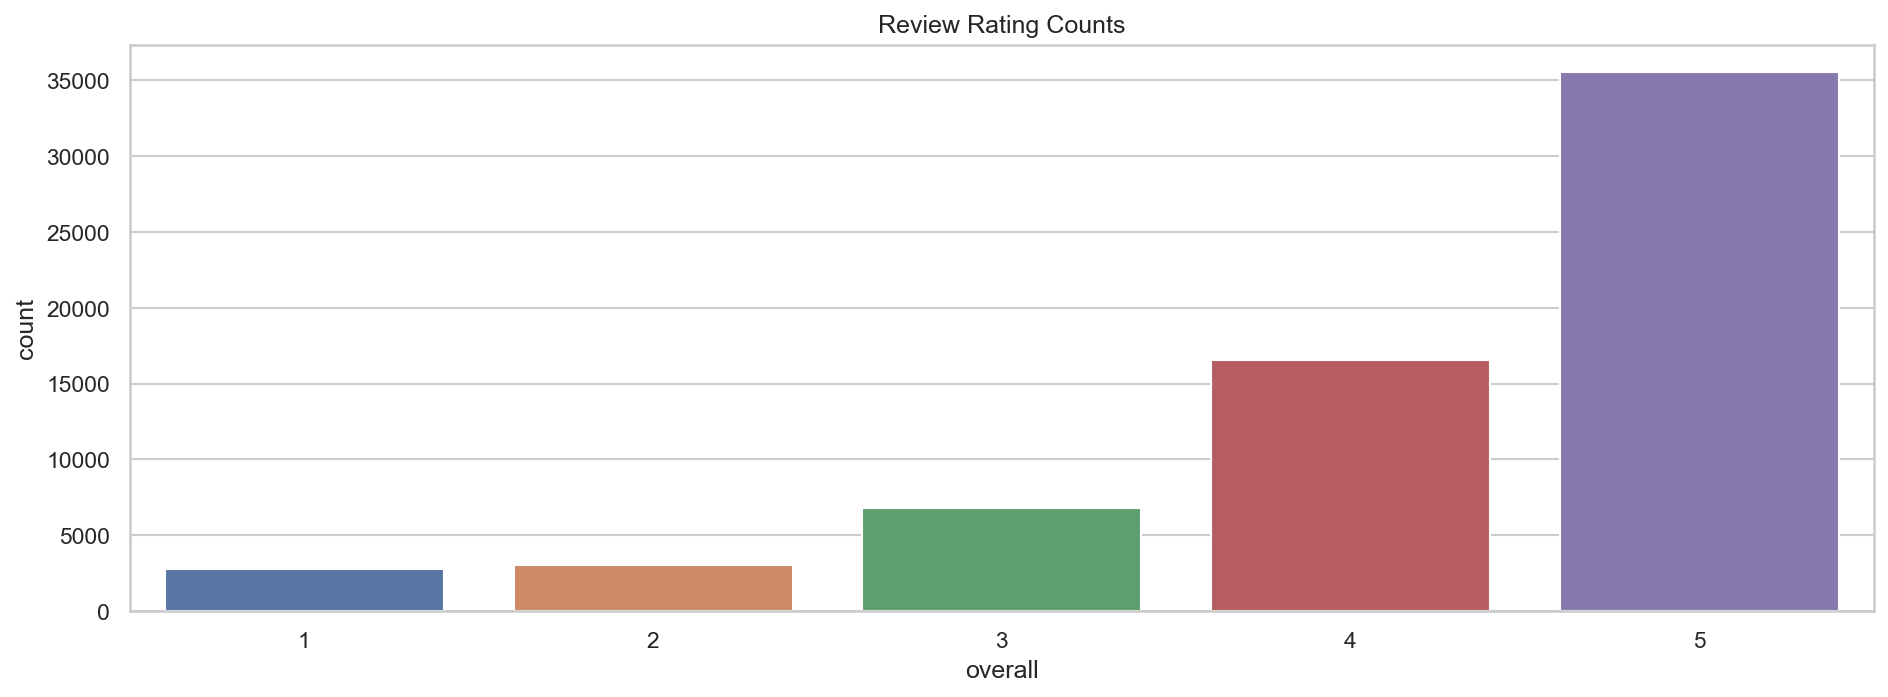

In [222]:
_ = plt.figure(figsize=(15,5))
ax = sns.countplot(x=original_df.overall)
_ = plt.title("Review Rating Counts")

#### Sentiment Counts (Neutral Removed)

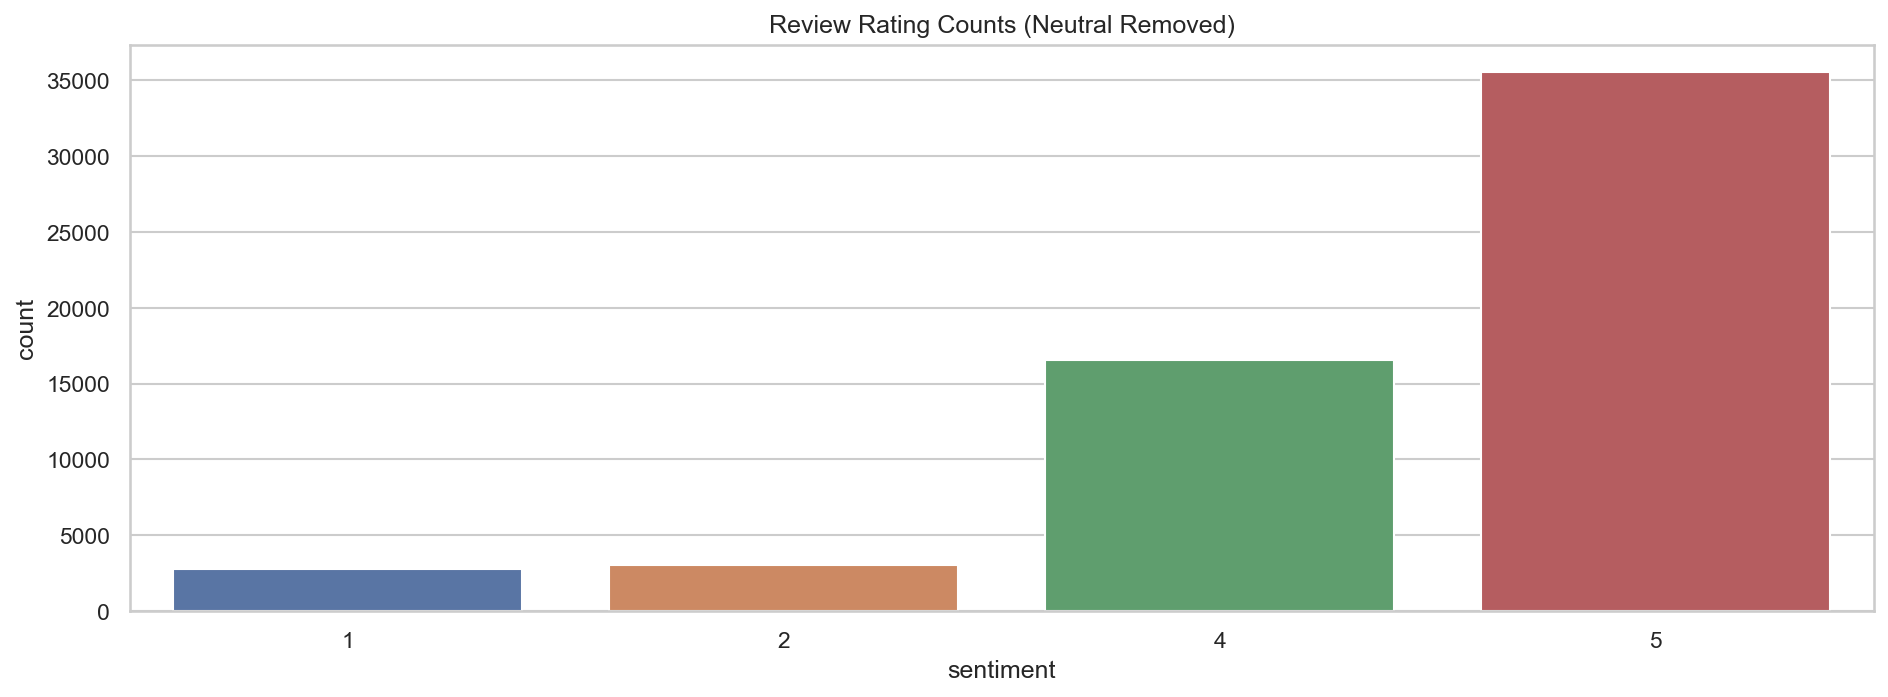

In [226]:
_ = plt.figure(figsize=(15,5))
ax = sns.countplot(x=prep_df.sentiment)
_ = plt.title("Review Rating Counts (Neutral Removed)")

#### Sentiment Counts (Pos or Neg)

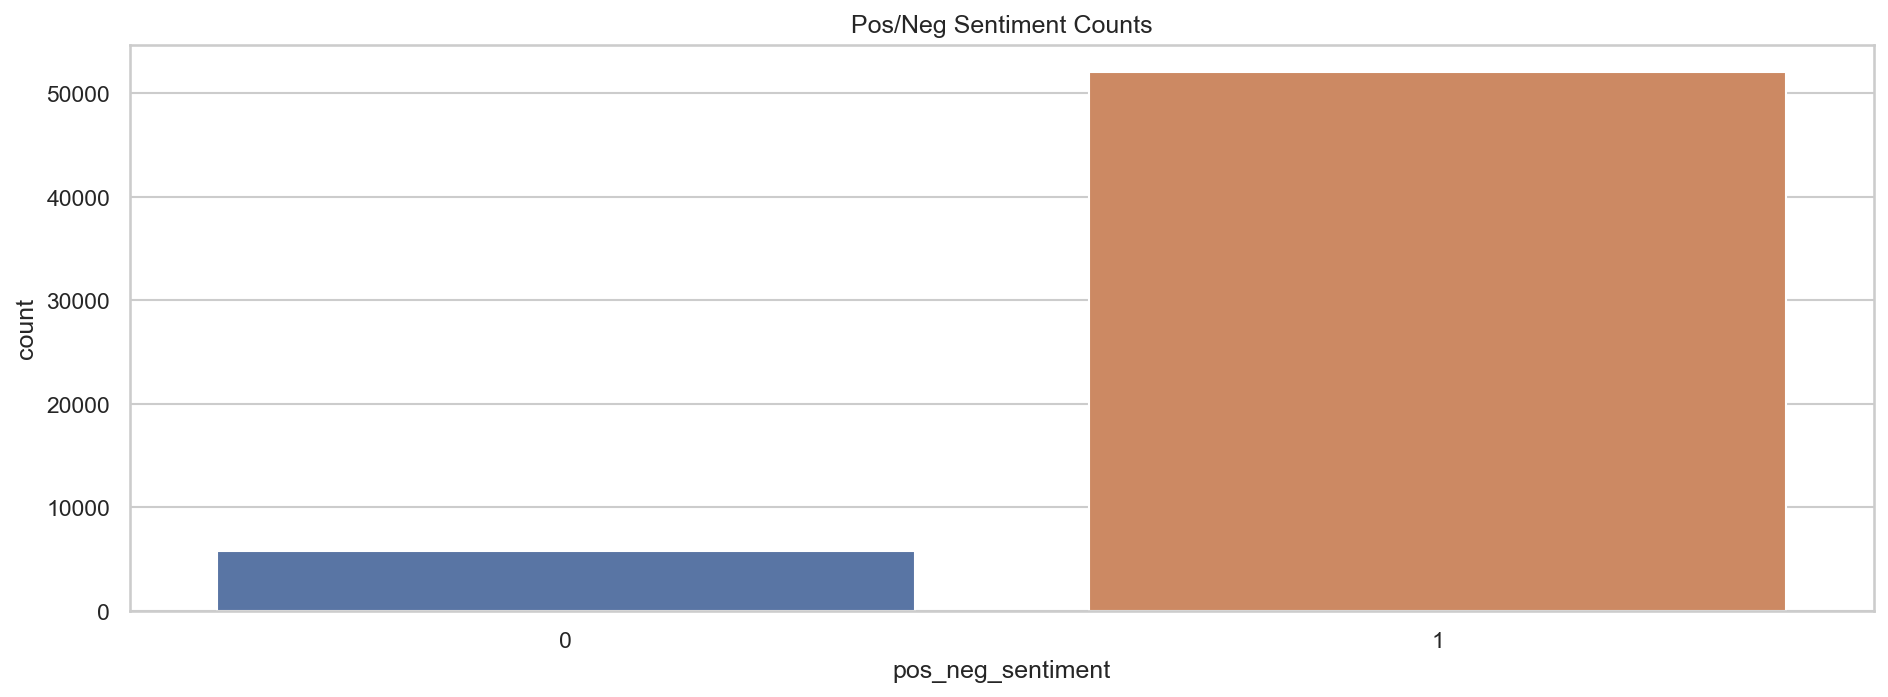

In [225]:
prep_df["pos_neg_sentiment"] = prep_df.sentiment.map(lambda x: 1 if x > 3 else 0 )

_ = plt.figure(figsize=(15,5))
ax = sns.countplot(x=prep_df.pos_neg_sentiment)
_ = plt.title("Pos/Neg Sentiment Counts")

In [115]:
prep_df.head(1)

,raw_text,sentiment,textClean
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan


In [ ]:
embedding_vector_length = 32

# BUILD THE NETWORK

# `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
model = Sequential()

# Embedding
# Turns positive integers (indexes) into dense vectors of fixed size.
model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=avg_review_word_count )) 

# SpatialDropout1D
# This version performs the same function as Dropout, however, it drops
# entire 1D feature maps instead of individual elements. If adjacent frames
# within feature maps are strongly correlated (as is normally the case in
# early convolution layers) then regular dropout will not regularize the
# activations and will otherwise just result in an effective learning rate
# decrease. In this case, SpatialDropout1D will help promote independence
# between feature maps and should be used instead.
model.add(SpatialDropout1D(rate=0.25))

model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))

# Dropout
# The Dropout layer randomly sets input units to 0 with a frequency of `rate`
# at each step during training time, which helps prevent overfitting.
# Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over
# all inputs is unchanged.

# A simple solution to the overfitting problem is to use dropout, an operation that will randomly drop the weights connected to certain nodes in a layer during the training process, as shown on the right. This will force your network to develop more robust rules for classification, since it cannot rely on any particular nodes being passed to an activation function. This will tend to improve out-of-sample performance.
# we want to drop the weights connected to 20% of nodes randomly. We'll then pass this to the output layer, which reduces the 60 nodes to 1 and applies a sigmoid activation function
model.add(Dropout(rate=0.2))

# Dense
# output shape should be 1 since this is binary data
model.add(Dense(units=1, activation="sigmoid"))

# Configures the model for training.
model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

# Prints a string summary of the network.
model.summary()


In [ ]:
history = model.fit(x=padded_sequence, y = prep_df.pos_neg, validation_split=0.2, epochs=5, batch_size=32)

# prep_df.pos_neg

In [ ]:
history.history

In [ ]:
# PLOT TRAINING AND VALIDATION ACCURACY SCORES

hist_df = pd.DataFrame(history.history)

num_epochs = range(1,6) 

_ = sns.lineplot(hist_df[["accuracy", "val_accuracy"]])
_ = plt.xticks(ticks=range(0,5), labels=num_epochs)
plt.show()

_ = sns.lineplot(hist_df[["loss", "val_loss"]])
_ = plt.xticks(ticks=range(0,5), labels=num_epochs)
plt.show()


In [ ]:
def predict_sentiment(text):
    tokenizer = Tokenizer(num_words=5000)
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=199)
    prediction = int(model.predict(tw).round().item())
    return prediction

# predict_sentiment(text)
predict_sentiment(test_df.iloc[0].words)

# test_df.iloc[0].words


In [ ]:
test_df

#### ✅ a. presence of unusual characters (e.g., emojis, non-English characters, etc.)
> Unusual or non-word characters do exist within review texts


In [125]:
def get_non_words(data):
    non_word_tokenizer = RegexpTokenizer('[^a-zA-Z\s]')    

    # tokenize on non-word and non-space characters
    return non_word_tokenizer.tokenize(text=data)

tokens_df = original_df.reviewText.apply(lambda x: set(get_non_words(data=x)))
tokens_df

0                                {,, 5, ", 1, 9, &, ', !, /, ;, .}
1                                                     {-, ', ., ,}
2                                                        {,, ., '}
3                                            {,, ), (, -, ', !, .}
4        {7, 1, ?, ,, ', 0, ", /, 5, 2, -, 3, 8, ), (, 9, :, ;, .}
                                   ...                            
64701                                                          {.}
64702                                                 {-, !, ., '}
64703                                                       {., ,}
64704                            {,, #, ), (, &, 3, ', !, 4, ;, .}
64705                      {0, #, ,, ', ), (, 1, &, 3, 4, !, ;, .}
Name: reviewText, Length: 64706, dtype: object

In [126]:
token_set = set()

for tokens in tokens_df:
    for token in tokens:
        token_set.add(token)

print("Non-Word Tokens Exist")
print(sorted(list(token_set)))

Non-Word Tokens Exist
['\x03', '\x16', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


#### ✅ b. vocabulary size
> the vocabulary size is 122,270 words

In [46]:
rwc = prep_df.raw_word_count.describe(percentiles=[.25, .5, .75, .95]).round().astype(int)
cwc = prep_df.clean_word_count.describe(percentiles=[.25, .5, .75, .95]).round().astype(int)
delta = cwc/rwc
pd.DataFrame(zip(rwc, cwc, delta), index=rwc.index, columns=["Raw Word Count", "Clean Word Count", "Delta"])


199 *.55

,Raw Word Count,Clean Word Count,Delta
count,57917,57917,1.00
mean,199,110,0.55
std,193,107,0.55
min,1,1,1.00
25%,70,38,0.54
50%,141,77,0.55
75%,259,144,0.56
95%,571,316,0.55
max,4587,2529,0.55


109.45

In [228]:
tokenizer, vocab_size, word_index_top_k = get_index(data=prep_df.clean_text, tokenizer=TOKENIZER)

f"{tokenizer = }"
f"{vocab_size = }"
f"TOP 25 Words: {word_index_top_k = }"


'tokenizer = <keras.preprocessing.text.Tokenizer object at 0x7f7d099b5760>'

'vocab_size = 113598'

'TOP 25 Words: word_index_top_k = {\'atweh\': 113597, \'nasri\': 113596, \'instigate\': 113595, \'segu\': 113594, \'chiropractor\': 113593, \'sunsdoesn\': 113592, \'presencerakim\': 113591, \'songtom\': 113590, \'sandcons\': 113589, \'thingsbest\': 113588, \'solosenergybetter\': 113587, \'lengthepic\': 113586, \'conceptalbum\': 113585, \'masterpiececonclusion\': 113584, \'untraveled\': 113583, \'offbalanced\': 113582, \'victimized\': 113581, \'steppy\': 113580, \'looooove\': 113579, \'bloodwork\': 113578, \'trilobite\': 113577, "dailor\'s": 113576, \'readjust\': 113575, "skye\'": 113574, \'andblood\': 113573}'

In [48]:
# spot check cleaned review text
prep_df[["clean_text"]].sample(n=10)

clean_text
15534                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       something know know devo spudboys akron hi music's inside joke useable shelf life musical act predicated premise de evolution surely steadily devolves corporate computer synth outfit can't tell many time heard devo sold well joke's devo wa selling think went great length create cheesy rod rooter insert video stand hack producer forced upon devo wa packaging marketing wonder twenty year later target us beautiful world sell consumer america idea beautiful world cold grinch like place salvation army bellringers sent back slum sight target's newly upscale clientele digress devo started dropping lit

In [103]:

# # only perform these steps on the training data
# review = prep_df.text
# avg_review_word_count = round(prep_df.wordCount.mean())
# print(f"{avg_review_word_count = }")
# # keep 5000 most popular words
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(review)
# # tokenizer
# vocab_size = len(tokenizer.word_index) + 1
# print(f"{vocab_size = }")
# encoded_reviews = tokenizer.texts_to_sequences(review)
# # encoded_reviews
# padded_sequence = pad_sequences(encoded_reviews, maxlen=avg_review_word_count, padding="post")
# # padded_sequence

0                                                                      [hard, believe, memory, tree, came, year, ago, ha, held, well, passage, time, enya's, last, great, album, new, age, pop, amarantine, day, without, rain, back, enya, still, creative, spark, voice, agree, reviewer, said, saddest, album, melancholy, bittersweet, opening, title, song, memory, tree, elegaic, majestic, pax, deorum, sound, like, requiem, mass, dark, threnody, unlike, reviewer, said, ha, disconcerting, blend, spirituality, sensuality, find, disconcerting, anywhere, hopeful, song, looking, possibility, hope, ha, place, love, listener, decide, romantic, platonic, etc, i've, always, soft, spot, song, way, home, triumphant, ending, return, truly, masterpiece, new, age, music, must, enya, fan]
1                                                                                                                                                                                                                             

In [51]:
tokenizer, vocab_size, counts = get_index(data=prep_df.clean_text, tokenizer=TOKENIZER)

vocab_size += 1
print(f"Vocab Size: {vocab_size:,}")
counts

Vocab Size: 113,599


{'atweh': 113597,
 'nasri': 113596,
 'instigate': 113595,
 'segu': 113594,
 'chiropractor': 113593,
 'sunsdoesn': 113592,
 'presencerakim': 113591,
 'songtom': 113590,
 'sandcons': 113589,
 'thingsbest': 113588,
 'solosenergybetter': 113587,
 'lengthepic': 113586,
 'conceptalbum': 113585,
 'masterpiececonclusion': 113584,
 'untraveled': 113583,
 'offbalanced': 113582,
 'victimized': 113581,
 'steppy': 113580,
 'looooove': 113579,
 'bloodwork': 113578,
 'trilobite': 113577,
 "dailor's": 113576,
 'readjust': 113575,
 "skye'": 113574,
 'andblood': 113573}

#### ✅ c. proposed word embedding length

In [231]:
max_sequence_embedding = round(vocab_size ** (1/4))
f"The {max_sequence_embedding = }"


'The max_sequence_embedding = 18'

In [ ]:
# tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE)
tf.keras.layers.Embedding(vocab_size, max_sequence_embedding)


#### ✅ d. statistical justification for the chosen maximum sequence length

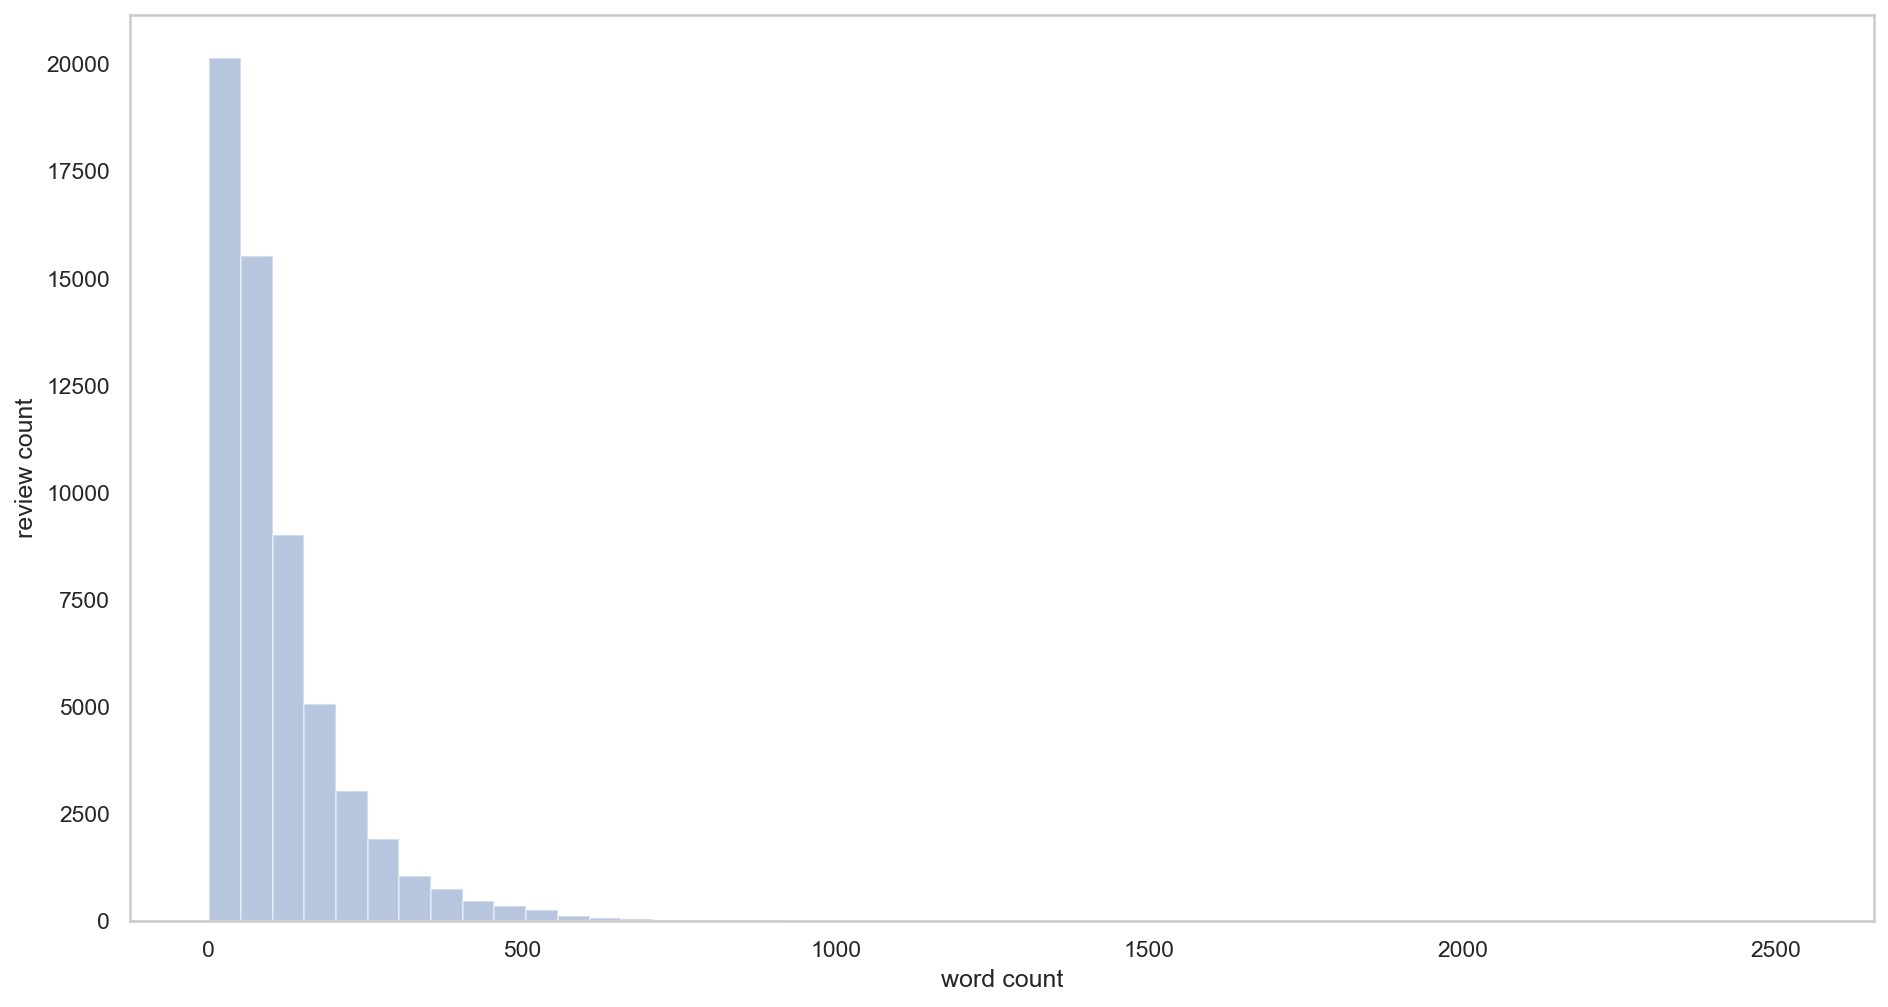

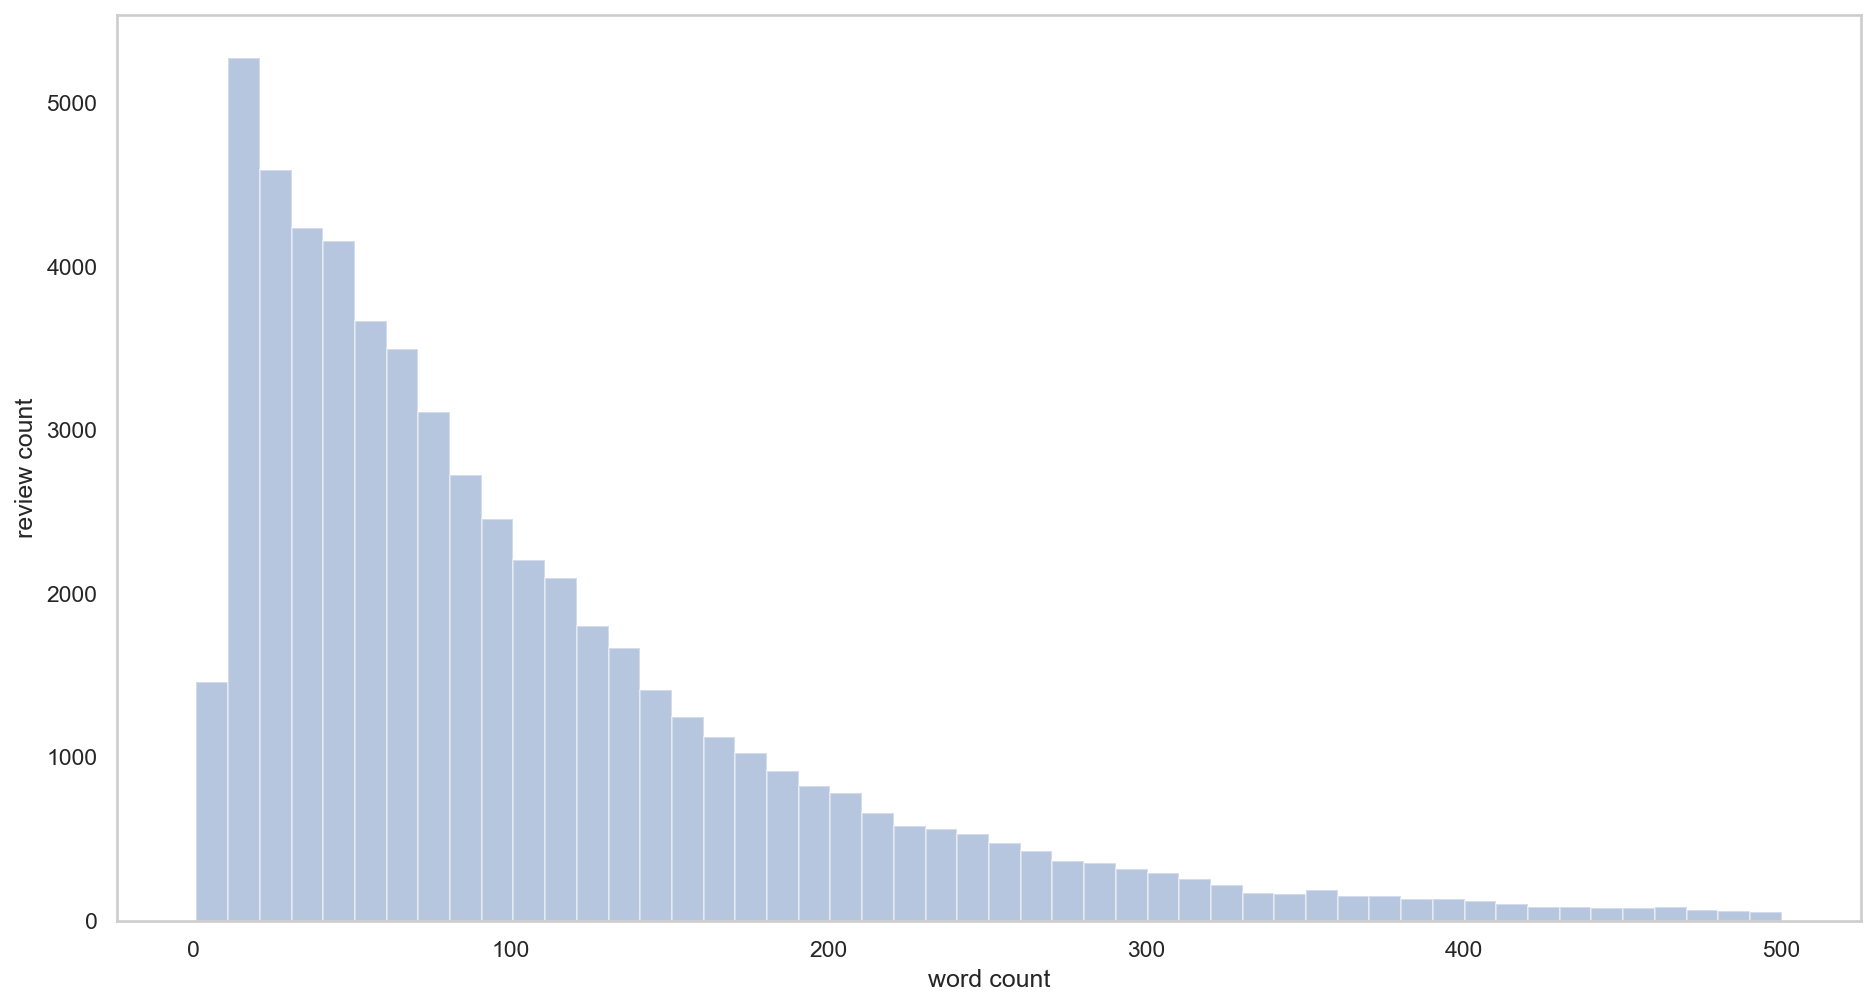

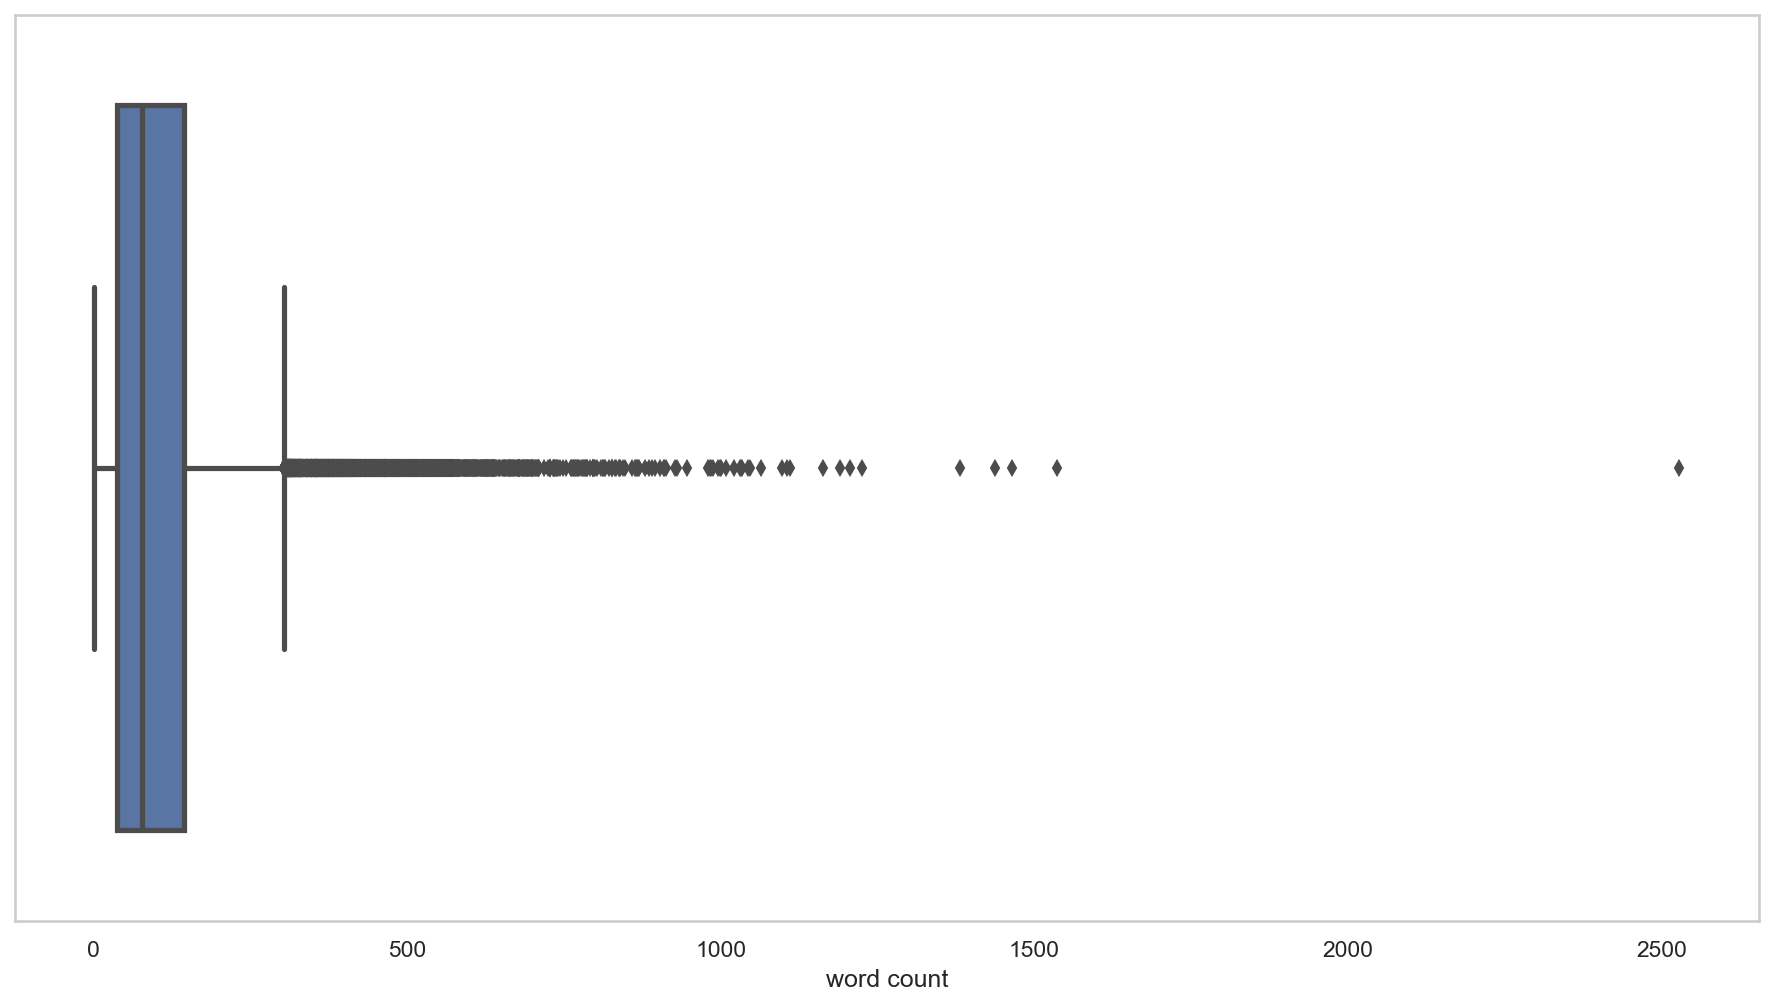

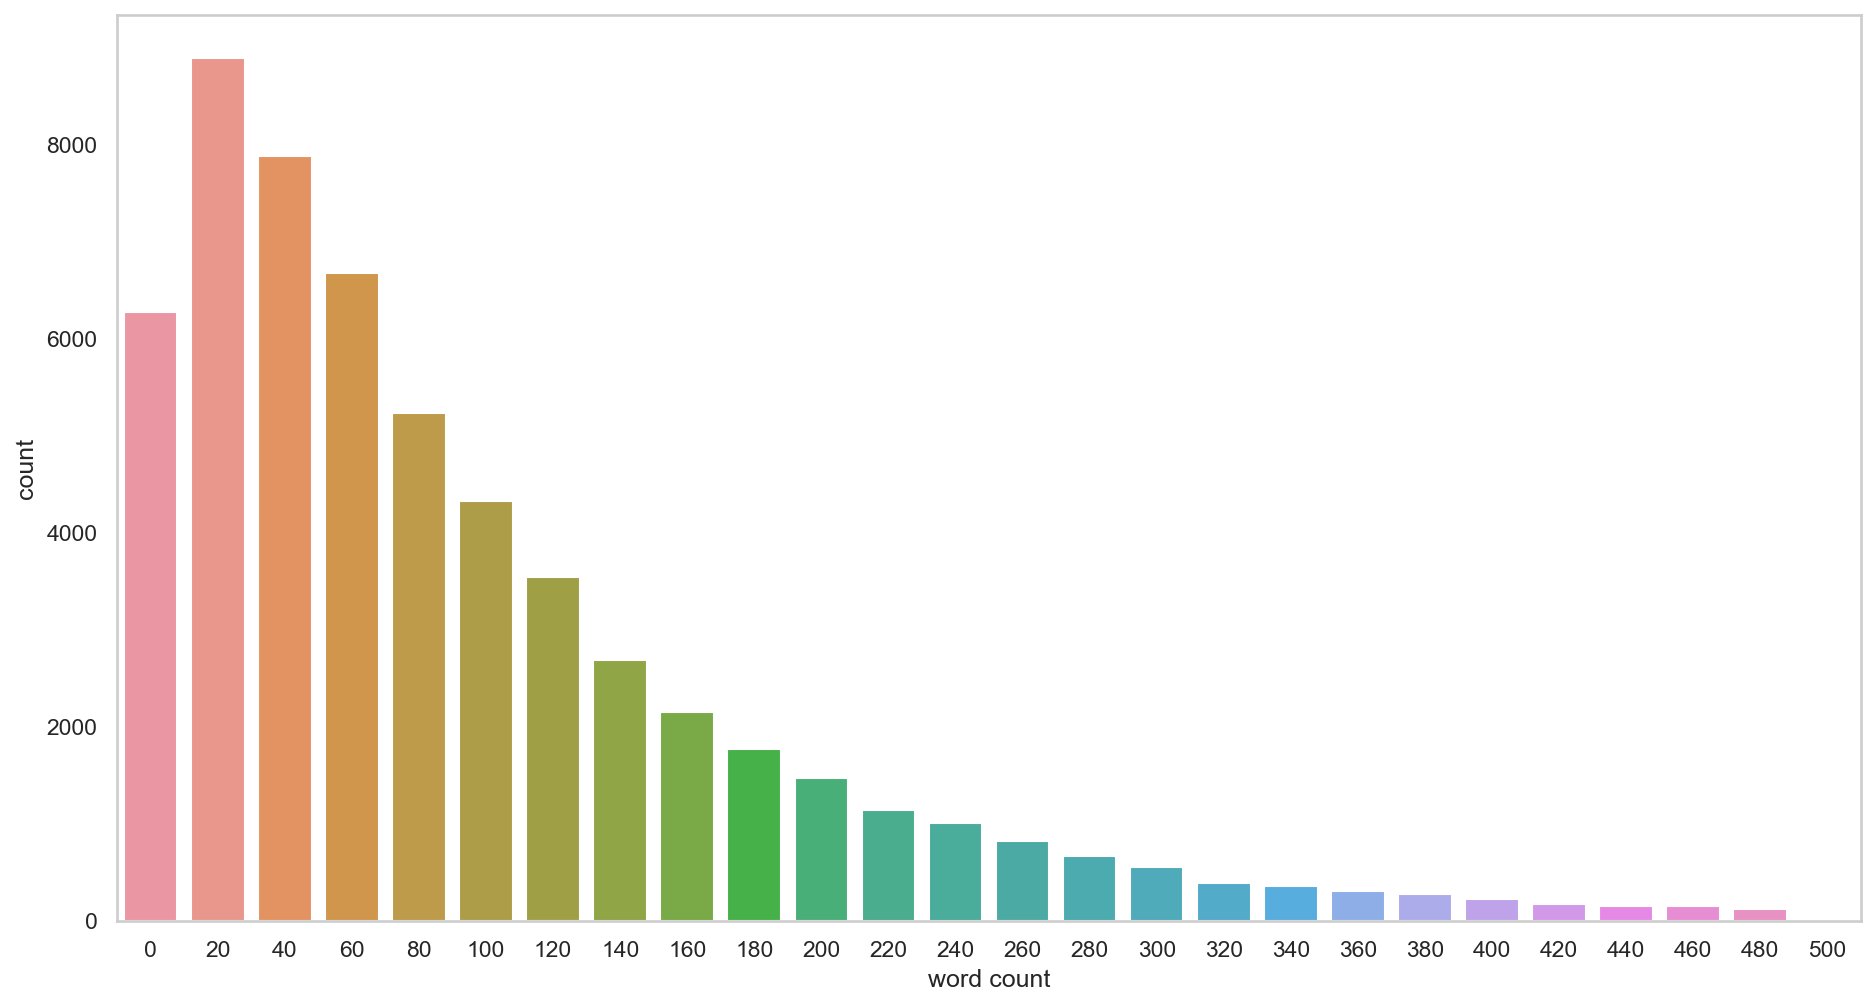

In [245]:
_ = plt.figure(figsize=(15,8))
ax = sns.distplot(prep_df.clean_word_count, kde=False)
plt.grid(False)
_ = plt.ylabel("review count")
_ = plt.xlabel("word count")
plt.show()

_ = plt.figure(figsize=(15,8))
ax = sns.distplot(prep_df[prep_df.clean_word_count <= 500].clean_word_count, kde=False)
plt.grid(False)
_ = plt.ylabel("review count")
_ = plt.xlabel("word count")
plt.show()

_ = plt.figure(figsize=(15,8))
ax = sns.boxplot(x=prep_df.clean_word_count)
plt.grid(False)
_ = plt.xlabel("word count")
plt.show()

_ = plt.figure(figsize=(15,8))
ax = sns.countplot(x=round(prep_df[prep_df.clean_word_count <= 500].clean_word_count//20)*20)
plt.grid(False)
_ = plt.xlabel("word count")
plt.show()


In [246]:
prep_df[["clean_word_count"]].describe(percentiles=[.25, .5, .75, .9, .95])

max_review_length = int(round(prep_df[["clean_word_count"]].quantile(0.5)))

print(f"Based on the average review length, the max review length should be: {max_review_length}")


,clean_word_count
count,57917.00
mean,109.55
std,106.94
min,1.00
25%,38.00
50%,77.00
75%,144.00
90%,241.00
95%,316.00
max,2529.00


Based on the average review length, the max review length should be: 77


### ✅ 2.  Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.

#### ✅ Goals
The tokenization process is to separate the text into smaller chunks or tokens. The chunks can be words, characters, or sub-word. A unique index called "word_index" is assigned to each word in the text which helps the model during the training process (TensorFlow, n.d; MLK, 2021).

Other goals that the tokenization process can achieve  include: 
- Replacing any abnormal character, formatting, and standardizing texts,
- Lemmatizing words and transforming the text into sequences, and
- Preparing the transformed sequences to a maximum sequence length by padding. 


#### ✅ including any code generated

#### ✅ packages that are used to normalize text during the tokenization process.

- tensorflow.keras.preprocessing.text
    - Tokenizer(num_words=vocab_size, oov_token="<UNK>" )
- nltk
    - from nltk.tokenize import RegexpTokenizer
    - LEMMA = nltk.WordNetLemmatizer()
    - STOP_WORDS = stopwords.words('english')
    - RegexpTokenizer, # tokenize on non-word and non-space characters




In [ ]:
# t = Tokenizer(num_words=vocab_size, oov_token="<UNK>" )
# t.fit_on_texts(prep_df.words)

# list(t.word_index.items())[:10]

In [56]:
# t.texts_to_sequences(prep_df.words.values[:5])

prep_df["encoded_text"] = TOKENIZER.texts_to_sequences(prep_df.clean_text.values)

prep_df.head()




,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count,encoded_text
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 284, 774, 1447, 158, 30, 430, 9, 1881, 22, 2680, 15, 1, 84, 11, 2, 32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]"
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5,103,1,clasically styled introverted album memory tree masterpiece subtlety many song endearing shyness soft piano lovely quiet voice within every introvert inferno enya let fire explode couple song absolutely burst expected raw power never heard enya might want start one popularized work like watermark play safe already fan collection complete without beautiful work musical art,54,"[1, 2999, 1, 2, 774, 1447, 314, 4633, 42, 3, 4184, 1, 541, 185, 741, 971, 59, 843, 67, 1, 1, 1, 172, 364, 4939, 333, 3, 478, 2628, 1203, 603, 301, 60, 61, 1, 220, 87, 123, 6, 1, 52, 7, 1, 142, 1759, 267, 34, 108, 549, 145, 117, 52, 139, 498]"
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",5,84,1,never thought enya would reach sublime height evacuee marble hall 'shepherd moon ' 'the celt watermark day ' pleasant admirable throughout le ambitious lyrically musically hop

### 3.  Explain the padding process used to standardize the length of sequences, including the following in your explanation:











In [247]:
f"{max_review_length = }"

prep_df["padded_text"] = prep_df["encoded_text"].apply(lambda x: pad_sequences(sequences=[x], maxlen=max_review_length, padding="pre", truncating="pre")[0])
prep_df.head()

'max_review_length = 77'

,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count,encoded_text,padded_text
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 284, 774, 1447, 158, 30, 430, 9, 1881, 22, 2680, 15, 1, 84, 11, 2, 32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]","[32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]"
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5,103,1,clasically styled introverted album memory tree masterpiece subtlety many song endearing shyness soft piano lovely quiet voice within every introvert inferno enya let fire explode couple song absolutely burst expected raw power never heard enya might want start one popularized work like watermark play safe already fan collection complete without beautiful work musical art,54,"[1, 2999, 1, 2, 774, 1447, 314, 4633, 42, 3, 4184, 1, 541, 185, 741, 971, 59, 843, 67, 1, 1, 1, 172, 364, 4939, 333, 3, 478, 2628, 1203, 603, 301, 60, 61, 1, 220, 87, 123, 6, 1, 52, 7, 1, 142, 1759, 267, 34, 108, 549, 145, 117, 52, 139, 498]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2999, 1, 2, 774, 1447, 314, 4633, 42, 3, 4184, 1, 541, 185, 741, 971, 59, 843, 67, 1, 1, 1, 172, 364, 4939, 333, 3, 478, 2628, 1203, 603, 301, 60, 61, 1, 220, 87, 123, 6, 1, 52, 7, 1, 142, 1759, 267, 34, 108, 549, 145, 117, 52, 139, 498]"
2,"I never thou

#### ✅ a. if the padding occurs before or after the text sequence

The padding occurs after the text sequence

#### b. a screenshot of a single padded sequence

In [60]:
print(f"{prep_df.raw_text[1] = }", end="\n\n")

print(f"{prep_df.clean_text[1] = }", end="\n\n")

print(f"{prep_df.encoded_text[1] = }", end="\n\n")

print(f"{prep_df.padded_text[1] = }", end="\n\n")

prep_df.raw_text[1] = "A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety.  Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice.  But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe.  But if you're already a fan, then your collection is not complete without this beautiful work of musical art."

prep_df.clean_text[1] = 'clasically styled introverted album memory tree masterpiece subtlety many song endearing shyness soft piano lovely quiet voice within every introvert inferno enya let fire explode couple song absolutely burst expected raw power never heard enya might want start one popularized work like watermark play safe already fan collection complete without beautiful work musical art'

### ✅ 4.  Identify how many categories of sentiment will be used and an activation function for the final dense layer of the network.

Two sentiment categories will be used: positive — represented by 1 and negative — represented by 0. The activation function on the final dense layer will be the sigmoid function.

### 5.  Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split.

In [756]:
prep_df.head(1)

,raw_text,sentiment,raw_word_count,clean_text,clean_word_count,encoded_text,padded_text,pos_neg_sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 289, 787, 1476, 161, 30, 439, 9, 1917, 22, 2745, 15, 1, 84, 11, 2, 32, 475, 48, 1, 66, 149, 705, 36, 1, 24, 587, 1680, 59, 1016, 694, 208, 1, 2, 1399, 3332, 414, 110, 3, 787, 1476, 1, 3736, 1, 1, 14, 7, 1, 1685, 297, 1, 697, 694, 208, 9, 1, 815, 4958, 1, 115, 1, 1760, 3975, 3, 381, 3943, 383, 9, 222, 16, 305, 2436, 978, 1, 533, 138, 92, 552, 1009, 3, 35, 318, 1, 1079, 595, 240, 320, 32, 475, 10, 159, 1, 34]","[32, 475, 48, 1, 66, 149, 705, 36, 1, 24, 587, 1680, 59, 1016, 694, 208, 1, 2, 1399, 3332, 414, 110, 3, 787, 1476, 1, 3736, 1, 1, 14, 7, 1, 1685, 297, 1, 697, 694, 208, 9, 1, 815, 4958, 1, 115, 1, 1760, 3975, 3, 381, 3943, 383, 9, 222, 16, 305, 2436, 978, 1, 533, 138, 92, 552, 1009, 3, 35, 318, 1, 1079, 595, 240, 320, 32, 475, 10, 159, 1, 34]",1


In [61]:
from sklearn.model_selection import train_test_split

X, y = prep_df[["raw_text", "padded_text"]], prep_df["pos_neg_sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

cols = ["raw_text", "padded_text", "pos_neg_sentiment"]

train_df = pd.concat([X_train, y_train], axis=1, ignore_index=False)
train_df.head(1)
train_df.pos_neg_sentiment.value_counts()

test_df= pd.concat([X_test, y_test], axis=1, ignore_index=False)
test_df.head(1)
test_df.pos_neg_sentiment.value_counts()


,raw_text,padded_text,pos_neg_sentiment
62195,Train is a favorite of mine lately. I enjoyed this song when I heard it on the radio and have worn it out since I got it.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1130, 54, 740, 2478, 710, 3, 61, 154, 3417, 105, 72]",1


1    41692
0     4641
Name: pos_neg_sentiment, dtype: int64

,raw_text,padded_text,pos_neg_sentiment
58438,"When the cover is the best part of the CD, you're in trouble. Jupiter One's ""Sunshower"" is derivative and strangely hollow. The music is constructed of spare parts left over from other bands, particularly the Flaming Lips. Musically, they seem to know how to play their instruments, which is a plus. Not a note or a harmony out of place.Or perhaps I should say, their producer can edit things together to where it sounds like they know how to play their instruments. The reason I say that last is because there is a falseness, a hollowness, to Jupiter One's music that I can't precisely define. Their music gives the illusion of substance but when I really listen to it, it dissolves into its derivatives and disappears. The lyrics vary between I-love-you rubbish and incomprehensibility, always seeming like they're going to say something enlightening, but they never really make it. The music is the same; it almost seems like something is going to happen, but it never does.Jupiter One's ""Sunshower"" is clever in a completely vacuous way. It gives the illusion of being memorable pop, but their hooks don't stick in the brain and their songs don't return to haunt me. ""Sunshower"" is a candy bar; sweet for a moment, empty calories, made by a corporation, and in the final analysis, not all that good for you. The best thing about the CD is ultimately the cover, which is peculiar enough to almost be art. The rest of it? Not so much.Finally, I find it very odd that their promotional material mentions the producer when the production itself is so poor. I have to be honest. The sound is muddy and ill-mixed, and nobody should be proud of the production, engineering or mixing on this album. The dynamics of the music are muddled and nothing sounds as if it were recorded right, or well. If I were Chris Ribando I definitely would not have insisted on a producer credit, or I would have used an ""Alan Smithee"" on this one. The production is some of the worst I've heard coming from a major label.","[48, 263, 943, 1758, 3, 584, 1, 1, 1605, 1211, 385, 276, 1849, 1, 77, 1, 664, 1, 12, 17, 58, 13, 1746, 164, 1, 162, 134, 498, 202, 31, 365, 115, 1177, 1, 238, 734, 354, 101, 1288, 928, 14, 2395, 1684, 821, 1079, 1862, 101, 1, 2068, 2, 1331, 10, 1, 152, 14, 253, 97, 22, 1267, 1, 177, 26, 1, 354, 905, 26, 257, 3448, 1, 6, 101, 647, 136, 61, 381, 578, 482]",0


1    10424
0     1160
Name: pos_neg_sentiment, dtype: int64

### ✅ 6.  Provide a copy of the prepared dataset.

In [197]:

prep_df.to_json("./reviews_Digital_Music_5_prepared.json", orient="records")
train_df.to_json("./reviews_Digital_Music_5_prepared_train.json", orient="records")
test_df.to_json("./reviews_Digital_Music_5_prepared_test.json", orient="records")

# train_df.sample(n=1000, random_state=RANDOM_STATE).to_json("./reviews_Digital_Music_5_prepared_train.json", orient="records")
# test_df.sample(n=1000, random_state=RANDOM_STATE).to_json("./reviews_Digital_Music_5_prepared_test.json", orient="records")

prep_df.head(1)
train_df.head(1)
test_df.head(1)

,raw_text,sentiment,raw_word_count,pos_neg_sentiment,clean_text,clean_word_count,encoded_text,padded_text
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,1,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 284, 774, 1447, 158, 30, 430, 9, 1881, 22, 2680, 15, 1, 84, 11, 2, 32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]","[32, 462, 48, 1, 65, 145, 688, 36, 1, 24, 576, 1637, 59, 1003, 680, 205, 1, 2, 1374, 3241, 404, 110, 3, 774, 1447, 1, 3636, 1, 1, 14, 7, 1, 1657, 292, 1, 684, 680, 205, 9, 1, 802, 4837, 1, 115, 1, 1726, 3871, 3, 375, 3840, 376, 9, 218, 16, 298, 2384, 964, 1, 521, 136, 93, 541, 991, 3, 35, 309, 1, 1060, 584, 236, 314, 32, 462, 10, 156, 1, 34]"


,raw_text,padded_text,pos_neg_sentiment
62195,Train is a favorite of mine lately. I enjoyed this song when I heard it on the radio and have worn it out since I got it.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1130, 54, 740, 2478, 710, 3, 61, 154, 3417, 105, 72]",1


raw_text  \
0  Rush albums are so rare these days that the arrival of SNAKES AND ARROWS came seemingly an eternity after their last album five years ago. Oh, there's been a volley of live releases, as well as the quirkyFeedbackEP, but I was waiting impatiently to hear what new music the trio of guitarist Alex Lifeson, bassist Geddy Lee, and drummer Neil Peart would present.Now in their mid-50s, the gang is rocking just as hard as ever, with a desire to push the limits of rock virtuosity that hasn't flagged. Neil Peart's drumming may not have finally transitioned to the world of the digital kit, leading to a slight staleness in sound, but his drumming still requires the traditional strength and control. Geddy Lee's basslines have become more subtle now, while Alex Lifeson didn't stop with just playing a usual guitar or two, but worked in a whole host of stringed instruments. The band seems to be rejoicing in the fact that, as longtime virtuosos, they've still got it, since the album contains three whole instrumentals. And as with any Rush album, songwriting spans from all-out sonic onslaughts ("Far Cry", "Spindrift") to tamer reflections ("The Larger Bowl"), and some songs which alternate between the two ("Bravest Face").The sound on here is much better thanVapor Trails, Rush's earlier album that was a "loudness wars" fiasco of muddy audio and digital clipping. Alex Lifeson's insistence from VAPOR TRAILS that synths be left out continues on this effort. It's good that Lifeson has more room to work, but the production unfortunately emphasizes the low end and one has to try hard to follow guitar lines. Furthermore, Lee is continuing to compensate for the lack of his beloved synths by overdubbing his voice. It works quite well on this album, especially compared to VAPOR TRAILS, but I know the practice is controversial among Rush fans. All in all, however, this is a disc that's enjoyable to listen to from first song to last, which not all Rush albums have succeeded in being.While the music is generally excellent, the downside of the album is found in Neil Peart's lyric writing. SNAKES AND ARROWS was announced as Peart's reflections on faith, and these are not always insightful. Two songs here, "Far Cry" and "Bravest Face" are admirable descriptions of life as a constant yin and yang or Wolflian idyll and catastrophe (though Per Norgard does a better job of portraying this perspective in hisSymphony No. 4"Hommage to Adolf Wolfli"). On other songs, however, Peart's lyrics are irksome. In "Armor and Sword", for example, he tells the religious to reject the traditional cry to spiritual warfare (the song evokes St. Paul most, but this is an idea found in Judaism, Buddhism, and Shinto just the same). It would make sense for Peart to call people over to his humanist philosophy, but to tell them how to practise their own religion is just silly.Peart also shows a pretty big ignorance of the philosophy of religion here at two points. In "Armor and Sword" he claims people come to religion only for security and to escape the fear of death, but plenty of thinkers from Richard Swinburne to Flew have chosen their faith because they find that the arguments lead to it, not because of personal angst. In "Faithless" Peart writes, "I don't have faith in faith, I don't believe in belief / You can call me faithless, you can call me faithless. / But I still claim to hope, and I believe in love." Sorry, that's the lamest apologia for a humanist outlook I've ever heard. Put it alongside the work of atheist philosophers of religion like Mackie or existentialist thinkers like Camus and Peart's attempt is simply risible. Of course, one cannot expect a rock drummer who never finished high school to make a strong argument, but one wonders why he even tried. I think popular music acts who focus on instrumental virtuosity but recognize that simple musicians are not cut out for philosophizing have it right, and after a full disc of Peart's lyrics it's nice to put 

# Part III:  Network Architecture



## C.  Describe the type of network used by doing the following:



In [198]:
%%time
# load the prepared data and reset the dataframe
df = pd.read_json("./reviews_Digital_Music_5_prepared_train.json",  dtype={"padded_text": np.array})
test_df = pd.read_json("./reviews_Digital_Music_5_prepared_test.json", dtype={"padded_text": np.array})

display(df.head(1))
df.info()
display(test_df.head(1))


,raw_text,padded_text,pos_neg_sentiment
0,Train is a favorite of mine lately. I enjoyed this song when I heard it on the radio and have worn it out since I got it.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1130, 54, 740, 2478, 710, 3, 61, 154, 3417, 105, 72]",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46333 entries, 0 to 46332
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   raw_text           46333 non-null  object
 1   padded_text        46333 non-null  object
 2   pos_neg_sentiment  46333 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


raw_text  \
0  Rush albums are so rare these days that the arrival of SNAKES AND ARROWS came seemingly an eternity after their last album five years ago. Oh, there's been a volley of live releases, as well as the quirkyFeedbackEP, but I was waiting impatiently to hear what new music the trio of guitarist Alex Lifeson, bassist Geddy Lee, and drummer Neil Peart would present.Now in their mid-50s, the gang is rocking just as hard as ever, with a desire to push the limits of rock virtuosity that hasn't flagged. Neil Peart's drumming may not have finally transitioned to the world of the digital kit, leading to a slight staleness in sound, but his drumming still requires the traditional strength and control. Geddy Lee's basslines have become more subtle now, while Alex Lifeson didn't stop with just playing a usual guitar or two, but worked in a whole host of stringed instruments. The band seems to be rejoicing in the fact that, as longtime virtuosos, they've still got it, since the album contains three whole instrumentals. And as with any Rush album, songwriting spans from all-out sonic onslaughts ("Far Cry", "Spindrift") to tamer reflections ("The Larger Bowl"), and some songs which alternate between the two ("Bravest Face").The sound on here is much better thanVapor Trails, Rush's earlier album that was a "loudness wars" fiasco of muddy audio and digital clipping. Alex Lifeson's insistence from VAPOR TRAILS that synths be left out continues on this effort. It's good that Lifeson has more room to work, but the production unfortunately emphasizes the low end and one has to try hard to follow guitar lines. Furthermore, Lee is continuing to compensate for the lack of his beloved synths by overdubbing his voice. It works quite well on this album, especially compared to VAPOR TRAILS, but I know the practice is controversial among Rush fans. All in all, however, this is a disc that's enjoyable to listen to from first song to last, which not all Rush albums have succeeded in being.While the music is generally excellent, the downside of the album is found in Neil Peart's lyric writing. SNAKES AND ARROWS was announced as Peart's reflections on faith, and these are not always insightful. Two songs here, "Far Cry" and "Bravest Face" are admirable descriptions of life as a constant yin and yang or Wolflian idyll and catastrophe (though Per Norgard does a better job of portraying this perspective in hisSymphony No. 4"Hommage to Adolf Wolfli"). On other songs, however, Peart's lyrics are irksome. In "Armor and Sword", for example, he tells the religious to reject the traditional cry to spiritual warfare (the song evokes St. Paul most, but this is an idea found in Judaism, Buddhism, and Shinto just the same). It would make sense for Peart to call people over to his humanist philosophy, but to tell them how to practise their own religion is just silly.Peart also shows a pretty big ignorance of the philosophy of religion here at two points. In "Armor and Sword" he claims people come to religion only for security and to escape the fear of death, but plenty of thinkers from Richard Swinburne to Flew have chosen their faith because they find that the arguments lead to it, not because of personal angst. In "Faithless" Peart writes, "I don't have faith in faith, I don't believe in belief / You can call me faithless, you can call me faithless. / But I still claim to hope, and I believe in love." Sorry, that's the lamest apologia for a humanist outlook I've ever heard. Put it alongside the work of atheist philosophers of religion like Mackie or existentialist thinkers like Camus and Peart's attempt is simply risible. Of course, one cannot expect a rock drummer who never finished high school to make a strong argument, but one wonders why he even tried. I think popular music acts who focus on instrumental virtuosity but recognize that simple musicians are not cut out for philosophizing have it right, and after a full disc of Peart's lyrics it's nice to put 

CPU times: user 1.15 s, sys: 114 ms, total: 1.26 s
Wall time: 1.26 s


In [200]:
# X_train = df['padded_text'].to_list()
# y_train = df["pos_neg_sentiment"].to_list()

# X_test = test_df['padded_text'].to_list()
# y_test = test_df["pos_neg_sentiment"].to_list()

X_train = np.array(df['padded_text'].to_list())
X_train.shape
y_train = df["pos_neg_sentiment"]

X_test = np.array(test_df['padded_text'].to_list())
X_test.shape
y_test = test_df["pos_neg_sentiment"]


# foo = df['padded_text']
# (X_train2, y_train2), (X_test2, y_test2) = imdb.load_data(num_words=20000)

(46333, 77)

(1000, 77)

In [141]:
# type(df['padded_text'].values)
type(X_train2)
type(y_train2)

# y_train2[0]

# df['pos_neg_sentiment'][0]

# X_train2[0]
np.array(df['padded_text'].to_list()).shape

numpy.ndarray

numpy.ndarray

(1000, 77)

In [66]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

#### EXAMPLE

In [12]:
from tensorflow.keras.datasets import imdb

tf.__version__

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=20000)

X_train, y_train, X_test, y_test
X_train.shape

'2.10.0'

(array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
        list([1, 194, 1153, 194, 

(25000,)

In [14]:
X_train = pad_sequences(X_train, maxlen=100)
X_train.shape

X_test = pad_sequences(X_test, maxlen=100)
X_test.shape

(25000, 100)

(25000, 100)

In [15]:
vocab_size = 20000
embed_size = 128

In [16]:
# BUILD THE NETWORK
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_shape=(X_train.shape[1],) )) 
model.add(LSTM(units=60, activation="tanh"))
model.add(Dense(units=1, activation="sigmoid"))

# Configures the model for training.
model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

# Prints a string summary of the network.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 60)                45360     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 2,605,421
Trainable params: 2,605,421
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Stop training when a monitored metric has stopped improving.
# helps avoid overfitting
# Assuming the goal of a training is to minimize the loss. With this, the
# metric to be monitored would be `'loss'`, and mode would be `'min'`. A
# `model.fit()` training loop will check at end of every epoch whether
# the loss is no longer decreasing, considering the `min_delta` and
# `patience` if applicable. Once it's found no longer decreasing,
# `model.stop_training` is marked True and the training terminates.

early_stopping_monitor = EarlyStopping(patience=2)

# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(x=X_train, y=y_train, epochs=5, batch_size = 128,callbacks=[early_stopping_monitor], validation_data=(X_test, y_test))

Epoch 1/5
196/196 [==============================] - 24s 115ms/step - loss: 0.4193 - accuracy: 0.8010 - val_loss: 0.3446 - val_accuracy: 0.8491
Epoch 2/5
196/196 [==============================] - 23s 116ms/step - loss: 0.2289 - accuracy: 0.9124 - val_loss: 0.3738 - val_accuracy: 0.8456
Epoch 3/5
196/196 [==============================] - 24s 124ms/step - loss: 0.1494 - accuracy: 0.9451 - val_loss: 0.4202 - val_accuracy: 0.8357


In [18]:
history.history

{'loss': [0.41932713985443115, 0.22889156639575958, 0.14943011105060577],
 'accuracy': [0.8009999990463257, 0.9124000072479248, 0.9451199769973755],
 'val_loss': [0.34462106227874756, 0.373800665140152, 0.4202438294887543],
 'val_accuracy': [0.849120020866394, 0.8455600142478943, 0.8356800079345703]}

(3, 4)

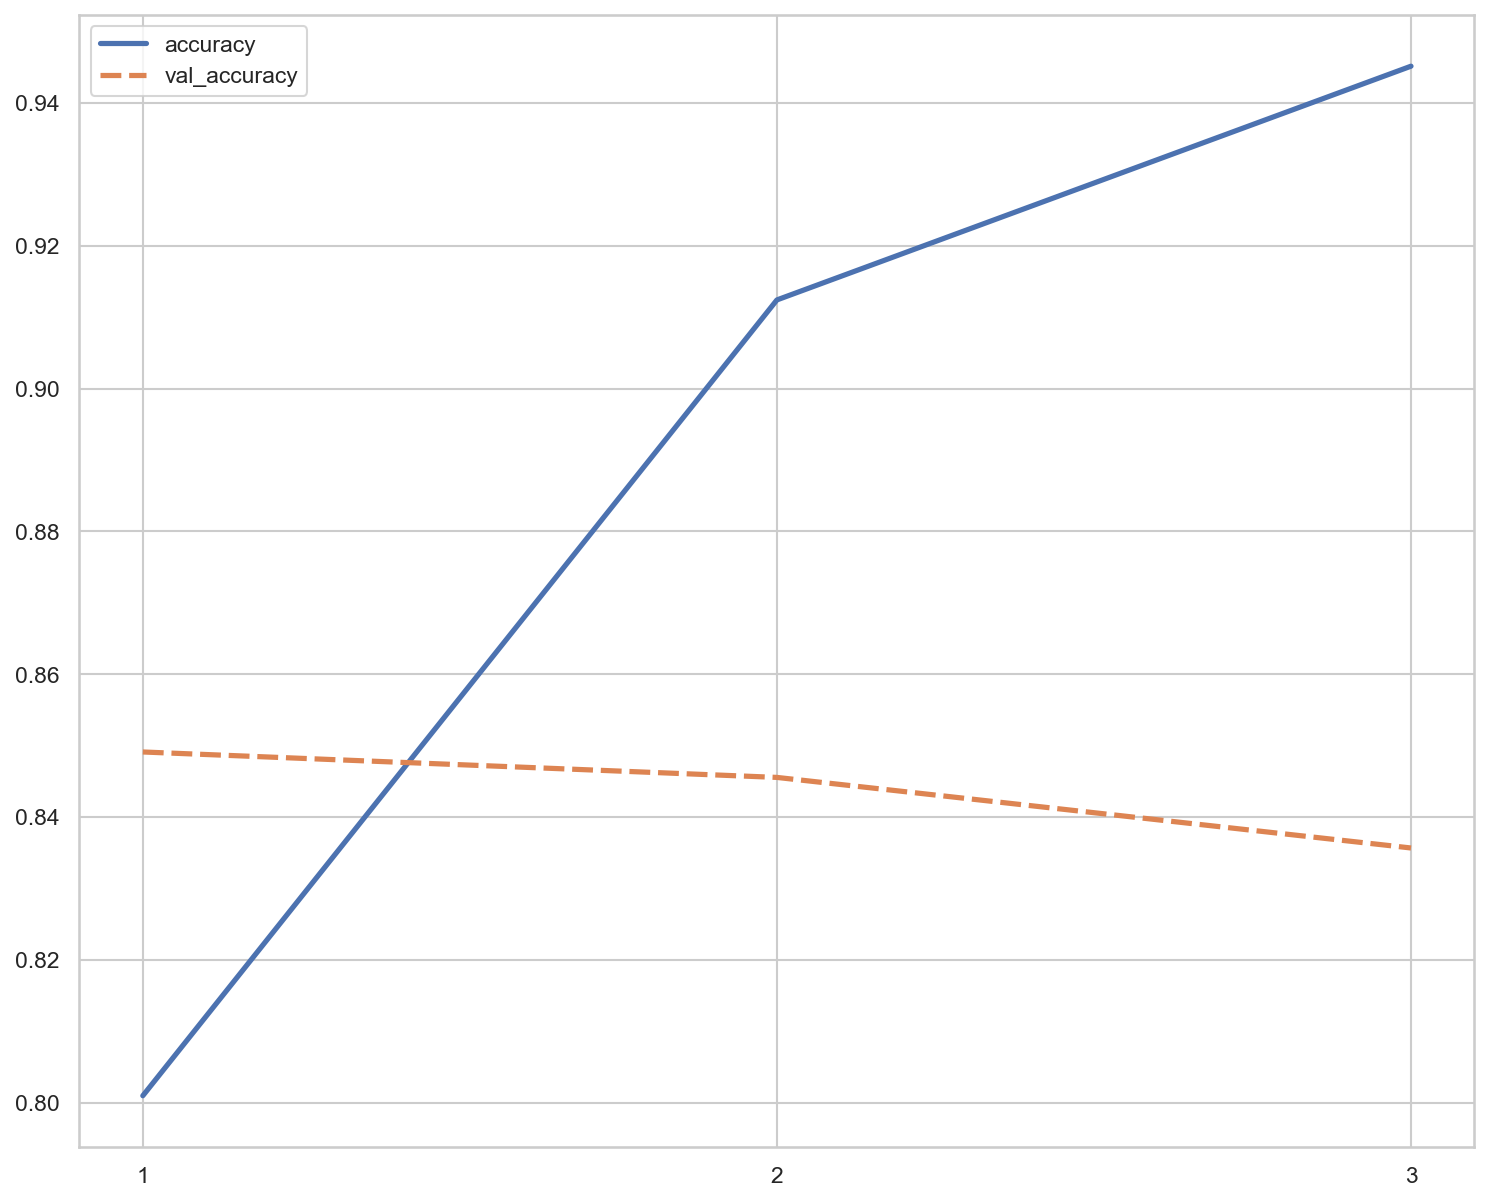

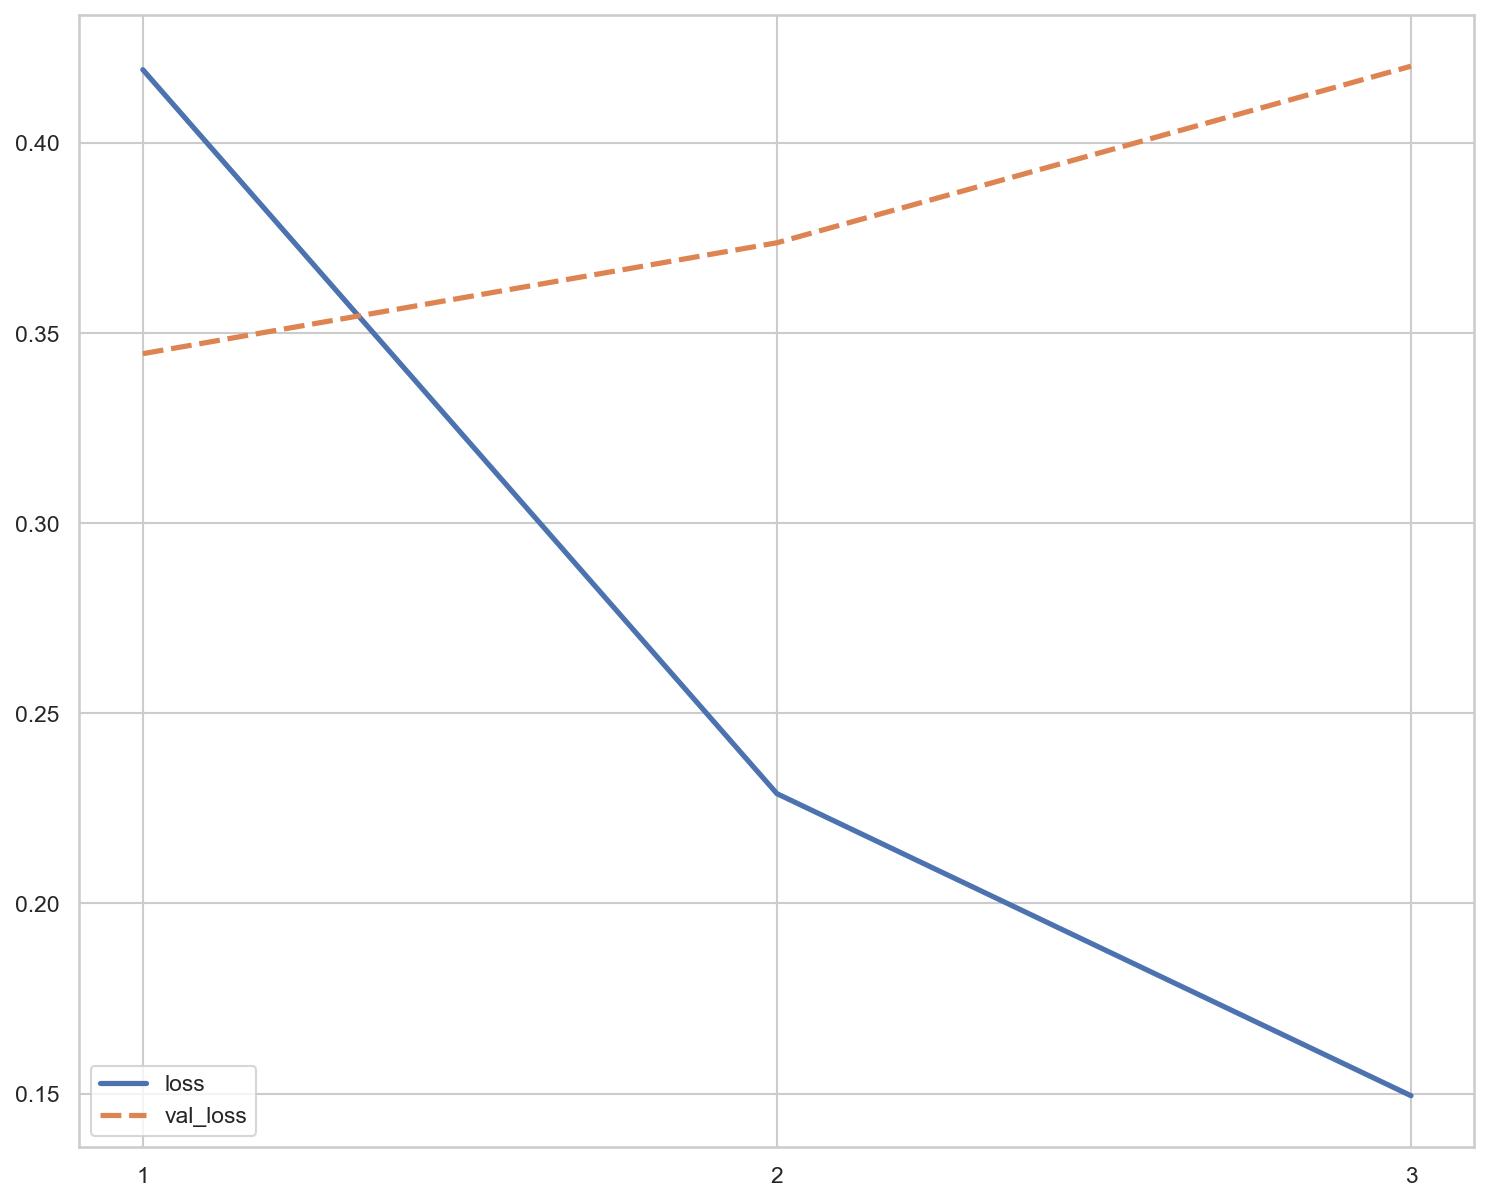

In [26]:
# PLOT TRAINING AND VALIDATION ACCURACY SCORES

hist_df = pd.DataFrame(history.history)
hist_df.shape

num_epochs = range(1,hist_df.shape[0]+1) 

_ = sns.lineplot(data=hist_df[["accuracy", "val_accuracy"]])
_ = plt.xticks(ticks=range(0,hist_df.shape[0]), labels=num_epochs)
plt.show()

_ = sns.lineplot(data=hist_df[["loss", "val_loss"]])
_ = plt.xticks(ticks=range(0,hist_df.shape[0]), labels=num_epochs)
plt.show()


In [27]:
# MODEL EVALUATION AGAINST TEST
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy 

782/782 [==============================] - 12s 15ms/step - loss: 0.4202 - accuracy: 0.8357


(0.42024409770965576, 0.8356800079345703)

In [28]:
# CONFUSION MATRIX

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# https://stackoverflow.com/questions/50920908/get-confusion-matrix-from-a-keras-multiclass-model
y_pred = model.predict(X_test).argmax(axis=1)
# tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()


782/782 [==============================] - 12s 15ms/step


array([0, 0, 0, ..., 0, 0, 0])

array([0, 1, 1, ..., 0, 0, 0])

782/782 [==============================] - 10s 12ms/step


Text(0.5, 1.0, 'Tensorflow NLP Model: Confusion Matrix')

Text(0.5, 139.375, 'Predicted Label')

Text(176.875, 0.5, 'True Label')

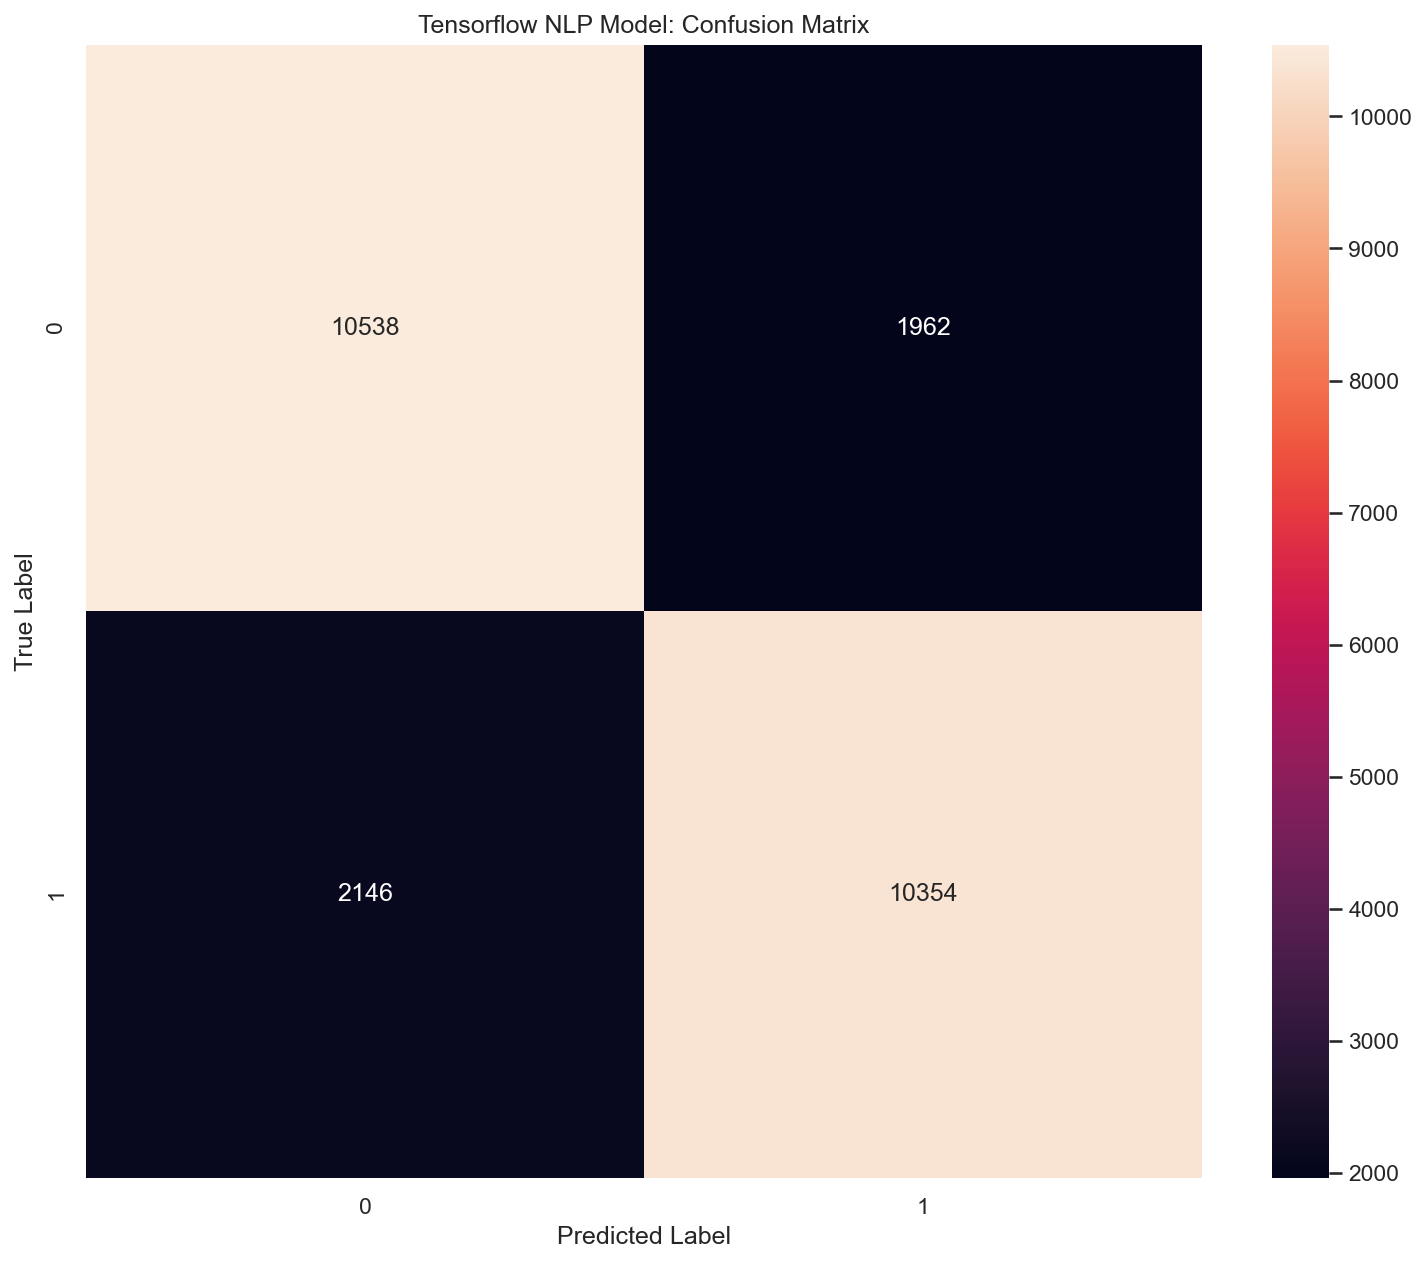

Accuracy: 0.836
Precision: 0.841
Recall / Sensitivity: 0.828
F1 Score: 0.834
ROC-AUC Score: 0.836
Confusion Matrix:
[[10538  1962]
 [ 2146 10354]]


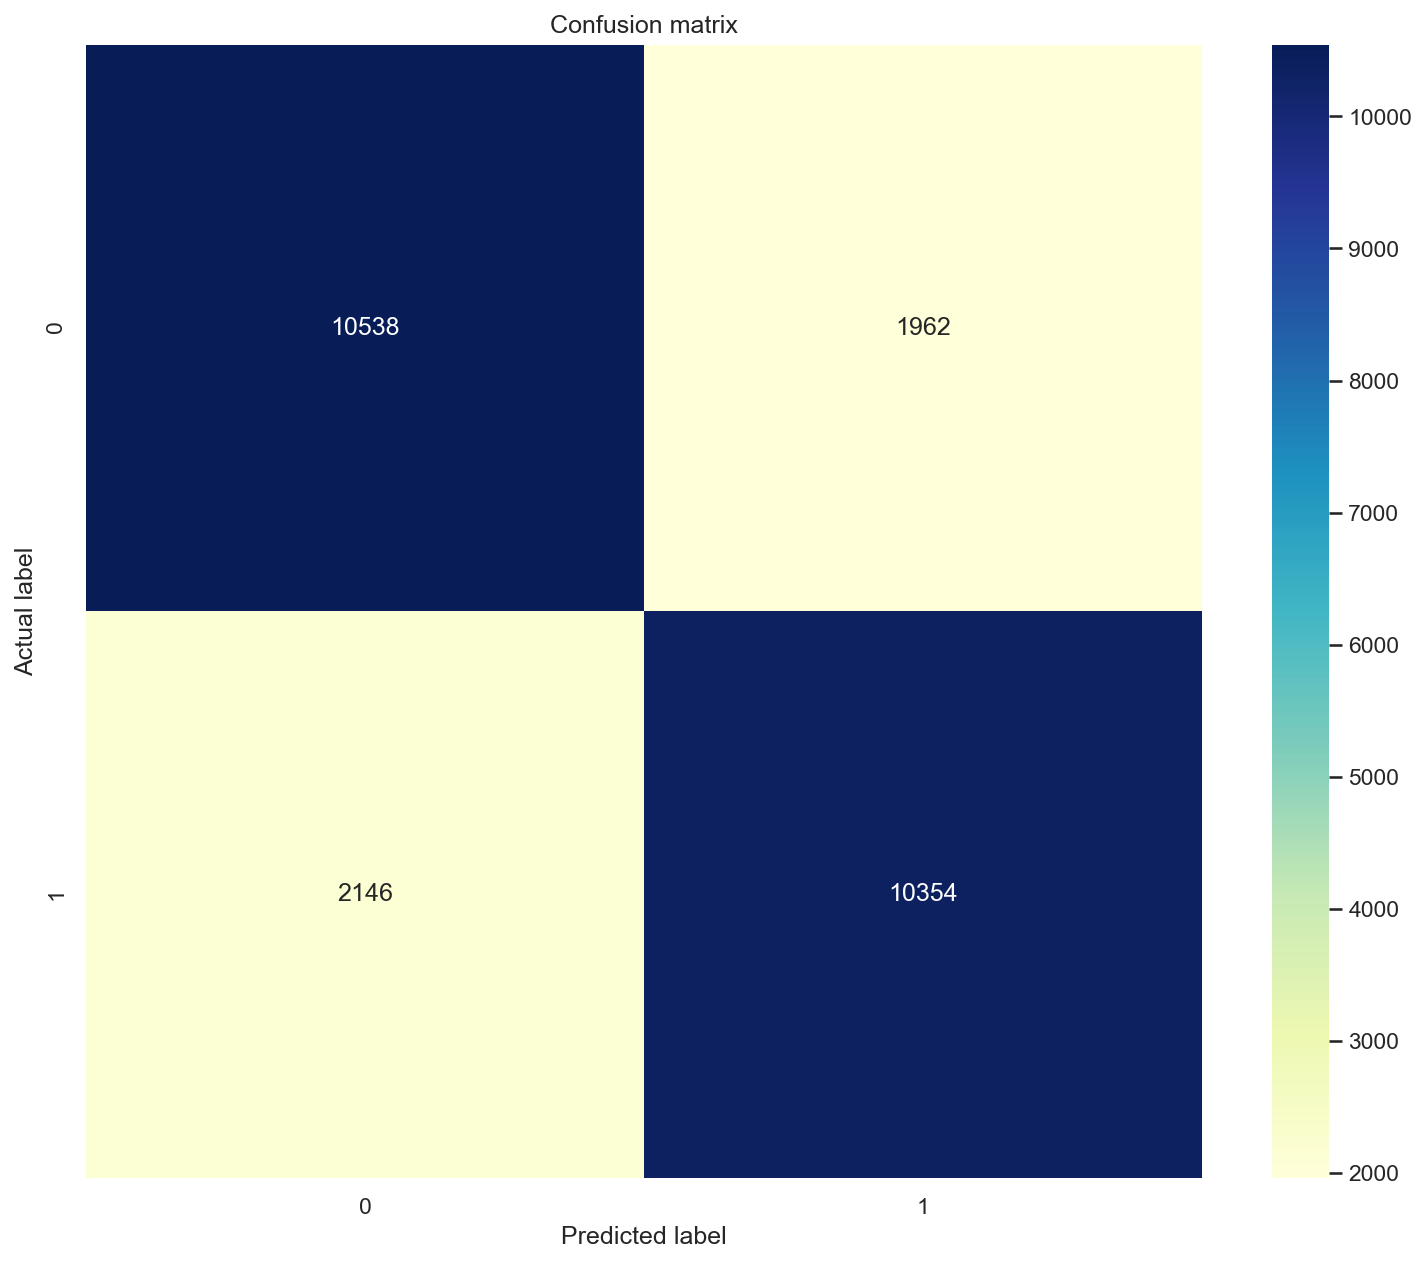

In [39]:
y_pred
y_test

# def create_cm(y_test, y_pred, display_labels=[0,1]):    
#     cm = confusion_matrix(y_test, y_pred)
#     cm

#     (tn, fp), (fn, tp) = cm

#     tn, fp, fn, tp

#     ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()
#     plt.show()

predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]

confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

create_conf_matrix(y_test, predictions)


In [ ]:
# SAVING THE MODEL
model.save("Trained_Model.keras")

### ✅ 1.  Provide the output of the model summary of the function from TensorFlow.

In [ ]:

# from tf.keras.layers.normalization import BatchNormalization

from tensorflow.keras.layers import BatchNormalization, Activation, Dense

# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
# https://stackoverflow.com/questions/69471749/importerror-cannot-import-name-batchnormalization-from-keras-layers-normaliz
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

def create_network():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=2,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=False
    )    

    # `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
    model = Sequential()
    
    # input
    model.add(Embedding(input_dim=vocab_size, output_dim=max_sequence_embedding, input_length=len(X_train[0]) )) 
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))    
    # model.add(Dropout(0.5))
    
    # hidden 1
    # model.add(LSTM(units=60, activation="tanh"))
    # keras.layers.SimpleRNN
    # model.add(keras.layers.SimpleRNN(units = 100, activation='relu', use_bias=True))
    model.add(keras.layers.SimpleRNN(units = 100, use_bias=True))    
    
    # model.add(LSTM(units=60))    
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))    
    
#     # hidden 2
#     # model.add(keras.layers.Dense(16, activation='relu'))
#     model.add(keras.layers.Dense(30))    
#     # model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())    
#     model.add(Dropout(0.25))
    
    # model.add(Dense(64))
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    # model.add(Dropout(0.5))    
    
    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))    

    # Configures the model for training.
    model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])    
    
    # model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

    # Prints a string summary of the network.
    model.summary()
    
    history = model.fit(x=X_train, y=y_train, epochs=20, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test), verbose=2)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy     
    
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    # predictions
    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax = ax)
    ax.set_title('Tensorflow NLP Model: Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()    
    
    create_conf_matrix(y_test, predictions)
    
create_network()  



# len(X_train[0])

In [144]:

def create_network1():
    embedding_vector_length = 32
    embedding_vector_length = max_sequence_embedding

    model = Sequential()
    
    embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=max_review_length )

    model.add(embedding_layer)


    model.add(SpatialDropout1D(rate=0.5))
    # model.add(Dropout(rate=0.25))


    model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(rate=0.20))

    model.add(Flatten())
    model.add(Dense(units=1, activation="sigmoid"))

    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Prints a string summary of the network.
    model.summary()
    
    return model, embedding_layer

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 316, 19)           2323149   
                                                                 
 spatial_dropout1d_27 (Spati  (None, 316, 19)          0         
 alDropout1D)                                                    
                                                                 
 lstm_34 (LSTM)              (None, 60)                19200     
                                                                 
 dropout_39 (Dropout)        (None, 60)                0         
                                                                 
 flatten_24 (Flatten)        (None, 60)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 61        
                                                     

'vocab_size = 122,270'

'max_sequence_embedding = 19'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.02,0.00,-0.04,-0.01,-0.01,0.04,0.01,0.00,-0.04,0.03,-0.01,0.04,0.00,0.04,-0.05,0.02,-0.02,-0.03,0.04
1,0.04,0.03,0.03,0.03,0.05,0.03,0.03,-0.05,-0.01,-0.04,0.00,-0.04,-0.00,0.00,0.02,-0.04,0.04,-0.01,0.01
2,0.01,-0.02,-0.03,-0.02,0.05,0.04,0.02,0.03,-0.04,-0.00,-0.01,0.05,0.03,0.03,-0.03,-0.05,0.04,0.01,0.02
3,0.01,-0.03,0.04,-0.02,-0.02,-0.00,0.01,0.03,-0.01,-0.04,-0.04,-0.01,0.01,0.04,-0.04,-0.04,-0.05,0.03,0.03
4,-0.04,0.01,-0.02,0.04,0.05,-0.00,-0.05,0.01,0.01,-0.01,0.03,0.02,-0.01,-0.01,0.04,0.00,0.00,0.05,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122266,-0.03,-0.02,-0.00,0.05,0.04,0.03,-0.00,-0.01,0.04,-0.01,0.01,0.01,-0.00,-0.01,-0.03,-0.05,-0.03,0.03,-0.04
122267,-0.01,0.05,-0.04,-0.01,0.04,-0.01,-0.00,0.05,-0.03,0.04,-0.03,0.01,0.04,0.04,-0.04,-0.03,-0.01,0.00,-0.01
122268,-0.03,-0.01,-0.04,0.03,-0.05,-0.04,0.00,0.02,-0.01,0.05,-0.01,0.01,-0.02,0.02,0.01,0.03,-0.04,0.01,-0.02
122269,-0.03,-0.01,0.01,-0.04,-0.05,0.00,-0.03,-0.00,0.00,0.02,0.05,-0.04,-0.04,-0.04,-0.02,0.03,-0.03,-0.02,-0.01


Epoch 1/5
290/290 [==============================] - 78s 262ms/step - loss: 0.3447 - accuracy: 0.8985 - val_loss: 0.3260 - val_accuracy: 0.8999
Epoch 2/5
290/290 [==============================] - 70s 242ms/step - loss: 0.3281 - accuracy: 0.8998 - val_loss: 0.3253 - val_accuracy: 0.8999
Epoch 3/5
290/290 [==============================] - 69s 236ms/step - loss: 0.3273 - accuracy: 0.8998 - val_loss: 0.3250 - val_accuracy: 0.8999
Epoch 4/5
290/290 [==============================] - 69s 239ms/step - loss: 0.3263 - accuracy: 0.8998 - val_loss: 0.3245 - val_accuracy: 0.8999
Epoch 5/5
290/290 [==============================] - 71s 245ms/step - loss: 0.3261 - accuracy: 0.8998 - val_loss: 0.3248 - val_accuracy: 0.8999


,loss,accuracy,val_loss,val_accuracy
0,0.34,0.90,0.33,0.90
1,0.33,0.90,0.33,0.90
2,0.33,0.90,0.33,0.90
3,0.33,0.90,0.32,0.90
4,0.33,0.90,0.33,0.90


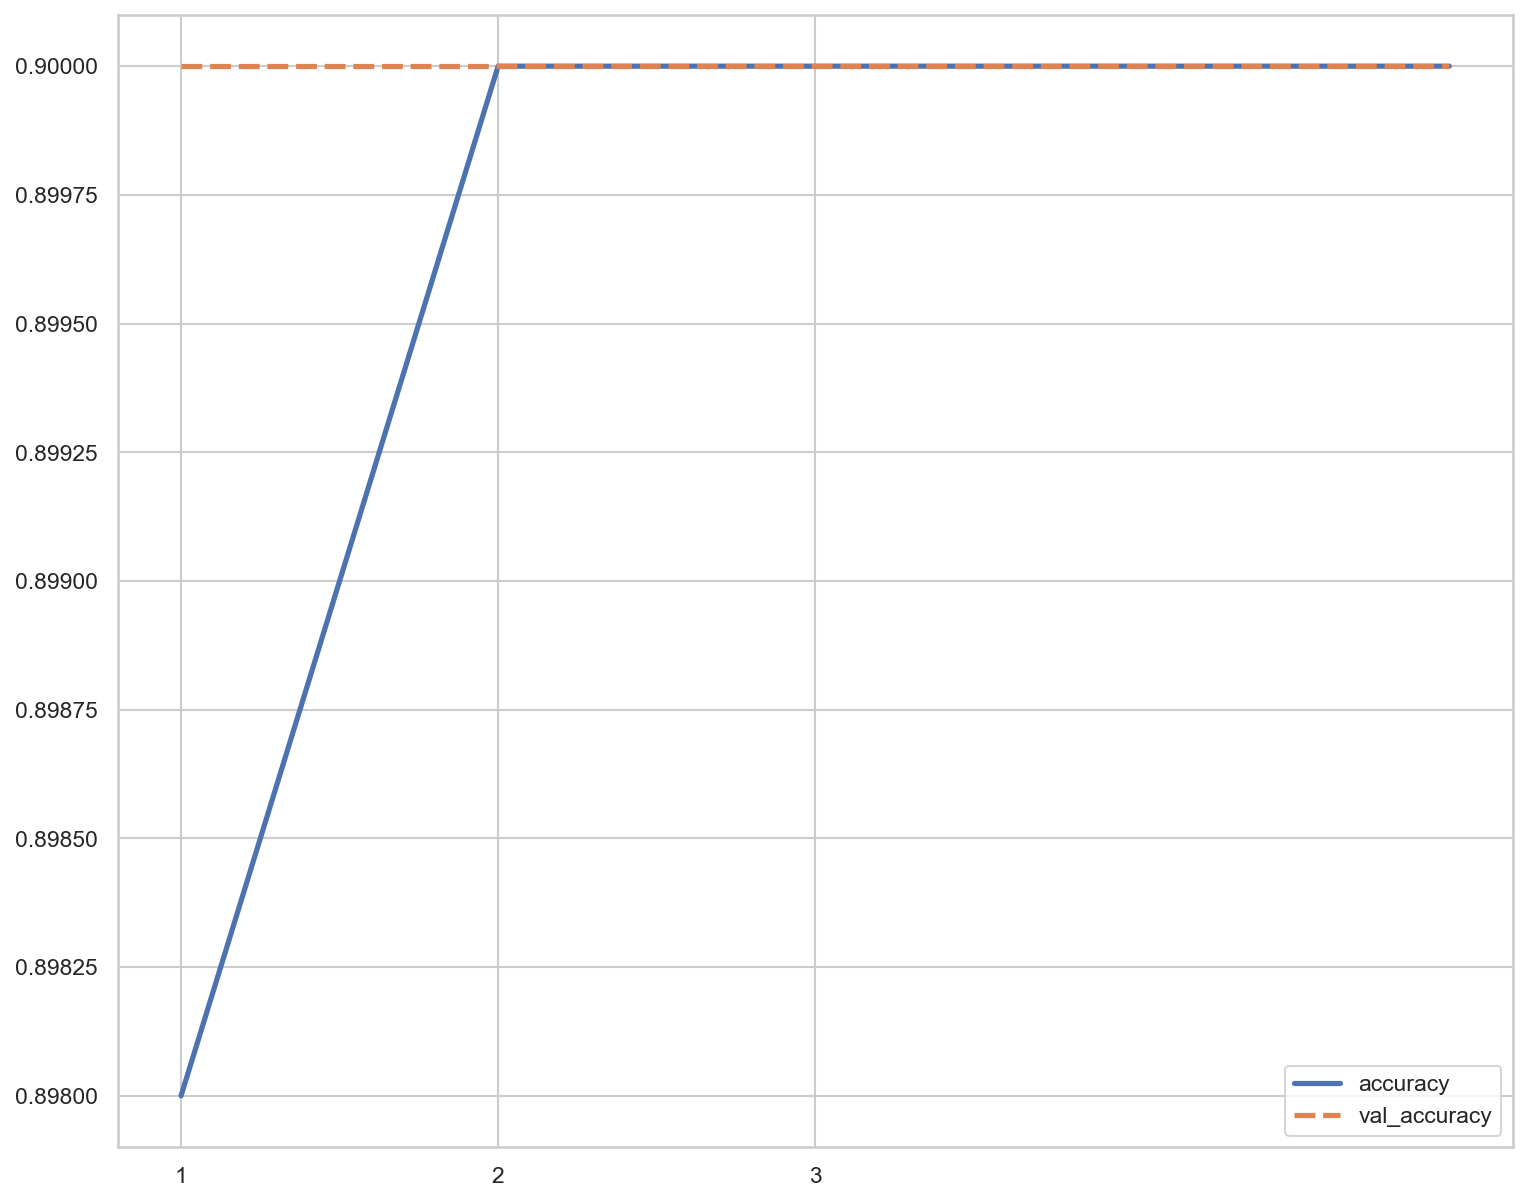

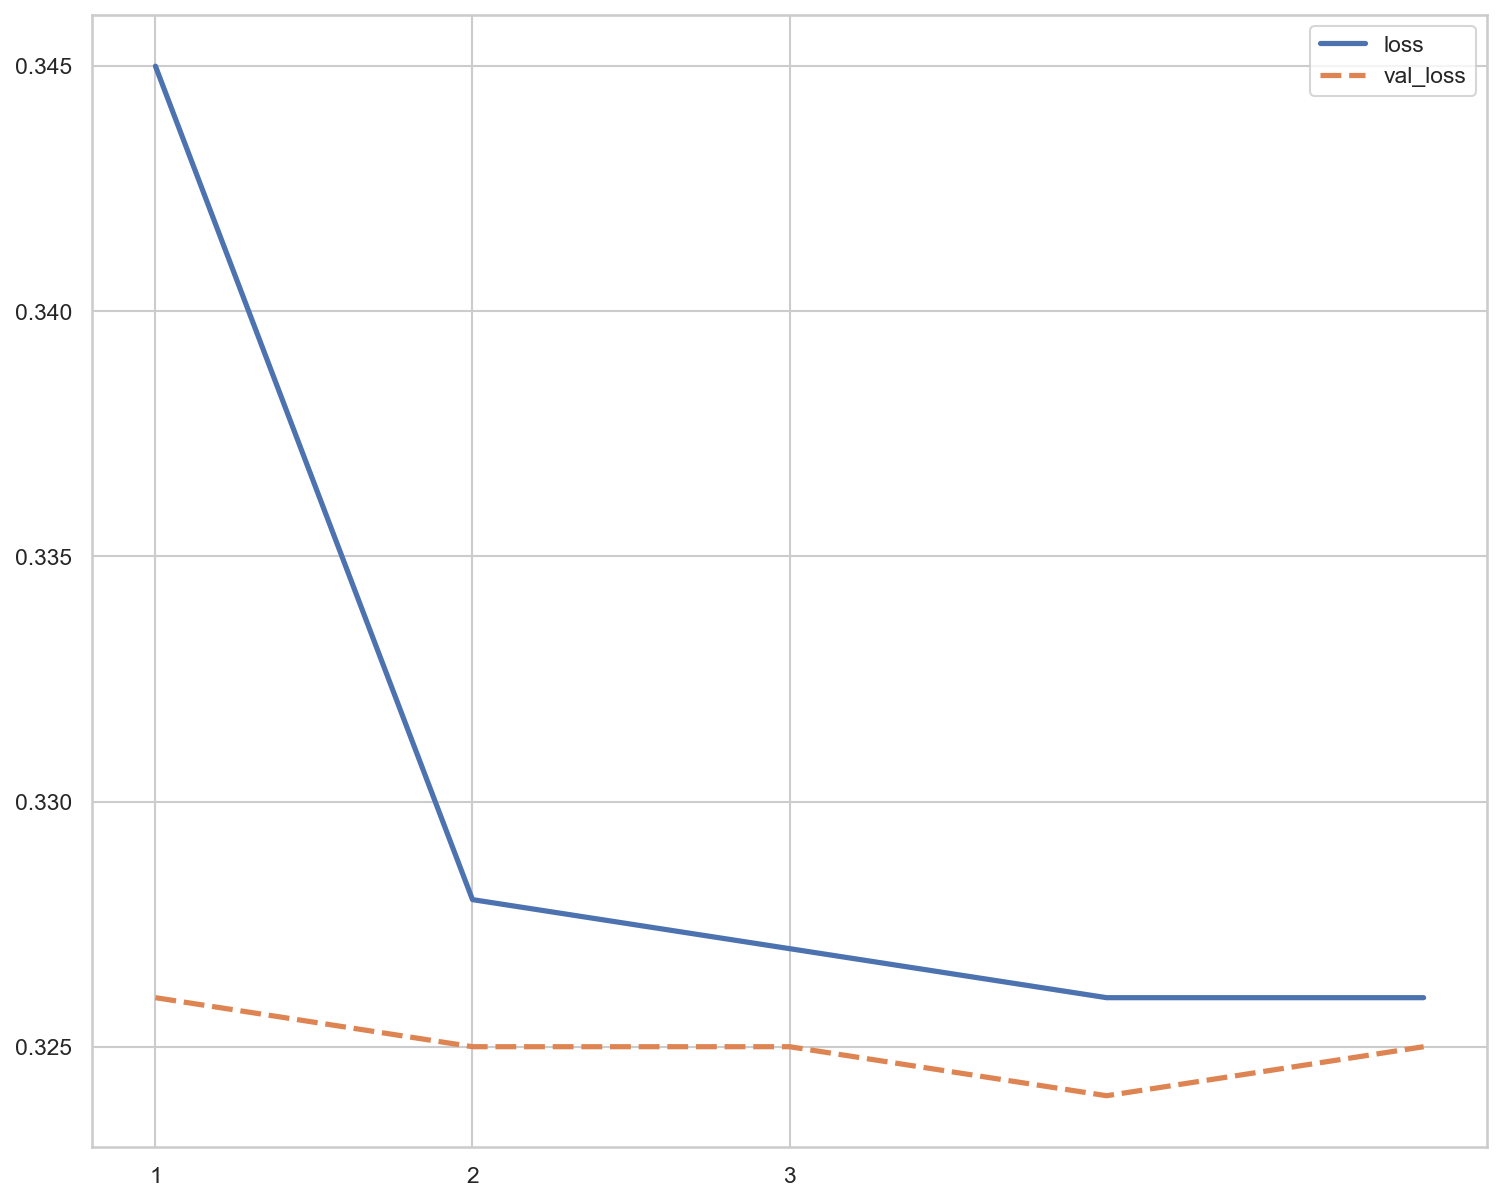

In [640]:
def create_network1():
    embedding_vector_length = 32
    embedding_vector_length = max_sequence_embedding

    model = Sequential()
    
    embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=max_review_length )

    model.add(embedding_layer)


    model.add(SpatialDropout1D(rate=0.5))
    # model.add(Dropout(rate=0.25))


    model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(rate=0.20))

    model.add(Flatten())
    model.add(Dense(units=1, activation="sigmoid"))

    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Prints a string summary of the network.
    model.summary()
    
    return model, embedding_layer

model1, embedding_layer1 = create_network1()

# 
f"{vocab_size = :,}"
f"{max_sequence_embedding = :,}"

# Returns the current weights of the layer, as NumPy arrays.

# The weights of a layer represent the state of the layer. This function
# returns both trainable and non-trainable weight values associated with
# this layer as a list of NumPy arrays, which can in turn be used to load
# state into similarly parameterized layers.

# For example, a `Dense` layer returns a list of two values: the kernel
# matrix and the bias vector. These can be used to set the weights of
# another `Dense` layer:
pd.DataFrame(embedding_layer1.get_weights()[0])

history1 = model1.fit(x=X_train, y=y_train, epochs=5, batch_size = 160, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))

plot_scores(history=history1, num_epochs = range(1,4), ticks=range(0,3))

In [8]:
int(round(np.sqrt(np.sqrt(vocab_size)), 0))

NameError: name 'vocab_size' is not defined

In [195]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=20000)
X_train = pad_sequences(X_train, maxlen=100)
X_train.shape

X_test = pad_sequences(X_test, maxlen=100)
X_test.shape

vocab_size = 20000
max_sequence_embedding = 128



(25000, 100)

(25000, 100)

In [100]:
X_train[4:6]

array([[   13,    16,   131,  2073,   249,   114,   249,   229,   249,
           20,    13,    28,   126,   110,    13,   473,     8,   569,
           61,   419,    56,   429,     6,  1513,    18,    35,   534,
           95,   474,   570,     5,    25,   124,   138,    88,    12,
          421,  1543,    52,   725,  6397,    61,   419,    11,    13,
         1571,    15,  1543,    20,    11,     4,     2,     5,   296,
           12,  3524,     5,    15,   421,   128,    74,   233,   334,
          207,   126,   224,    12,   562,   298,  2167,  1272,     7,
         2601,     5,   516,   988,    43,     8,    79,   120,    15,
          595,    13,   784,    25,  3171,    18,   165,   170,   143,
           19,    14,     5,  7224,     6,   226,   251,     7,    61,
          113],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_75 (Embedding)    (None, 77, 18)            2044764   
                                                                 
 lstm_56 (LSTM)              (None, 60)                18960     
                                                                 
 activation_88 (Activation)  (None, 60)                0         
                                                                 
 batch_normalization_110 (Ba  (None, 60)               240       
 tchNormalization)                                               
                                                                 
 dropout_56 (Dropout)        (None, 60)                0         
                                                                 
 dense_122 (Dense)           (None, 30)                1830      
                                                     

,loss,accuracy,val_loss,val_accuracy
0,0.46,0.83,0.37,0.91
1,0.25,0.93,0.29,0.91
2,0.19,0.94,0.21,0.93
3,0.16,0.95,0.20,0.93
4,0.14,0.95,0.22,0.92
5,0.12,0.96,0.23,0.92


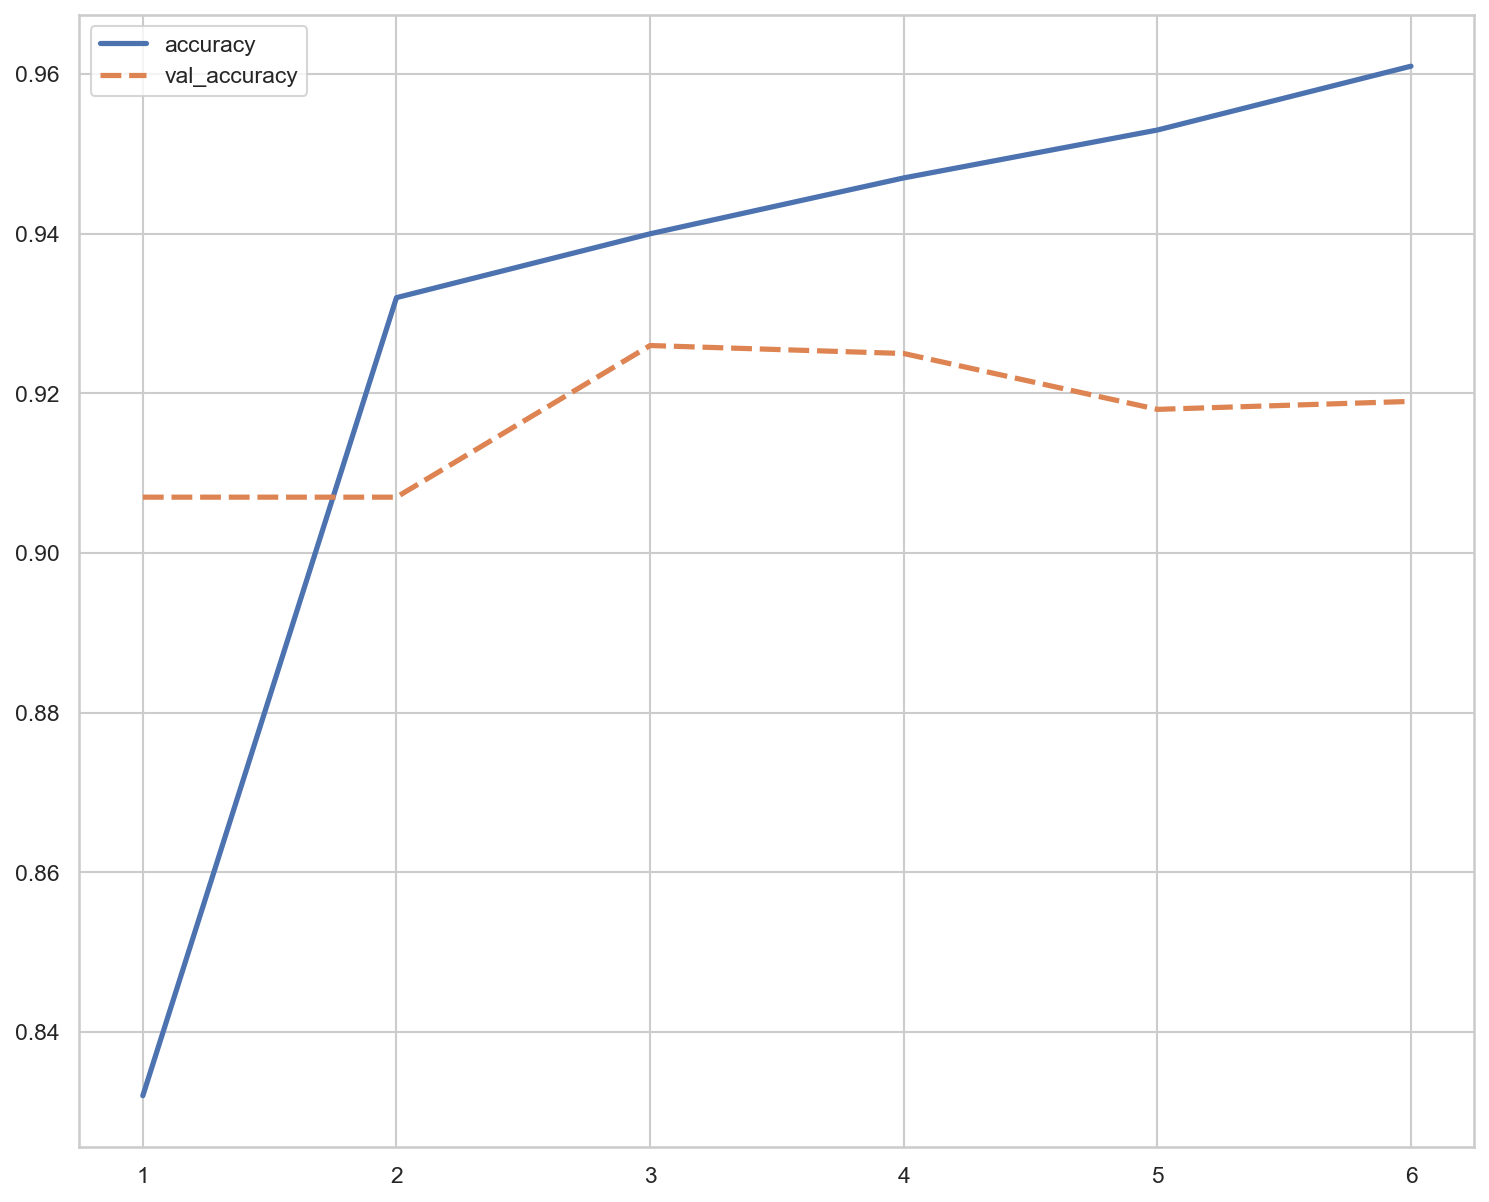

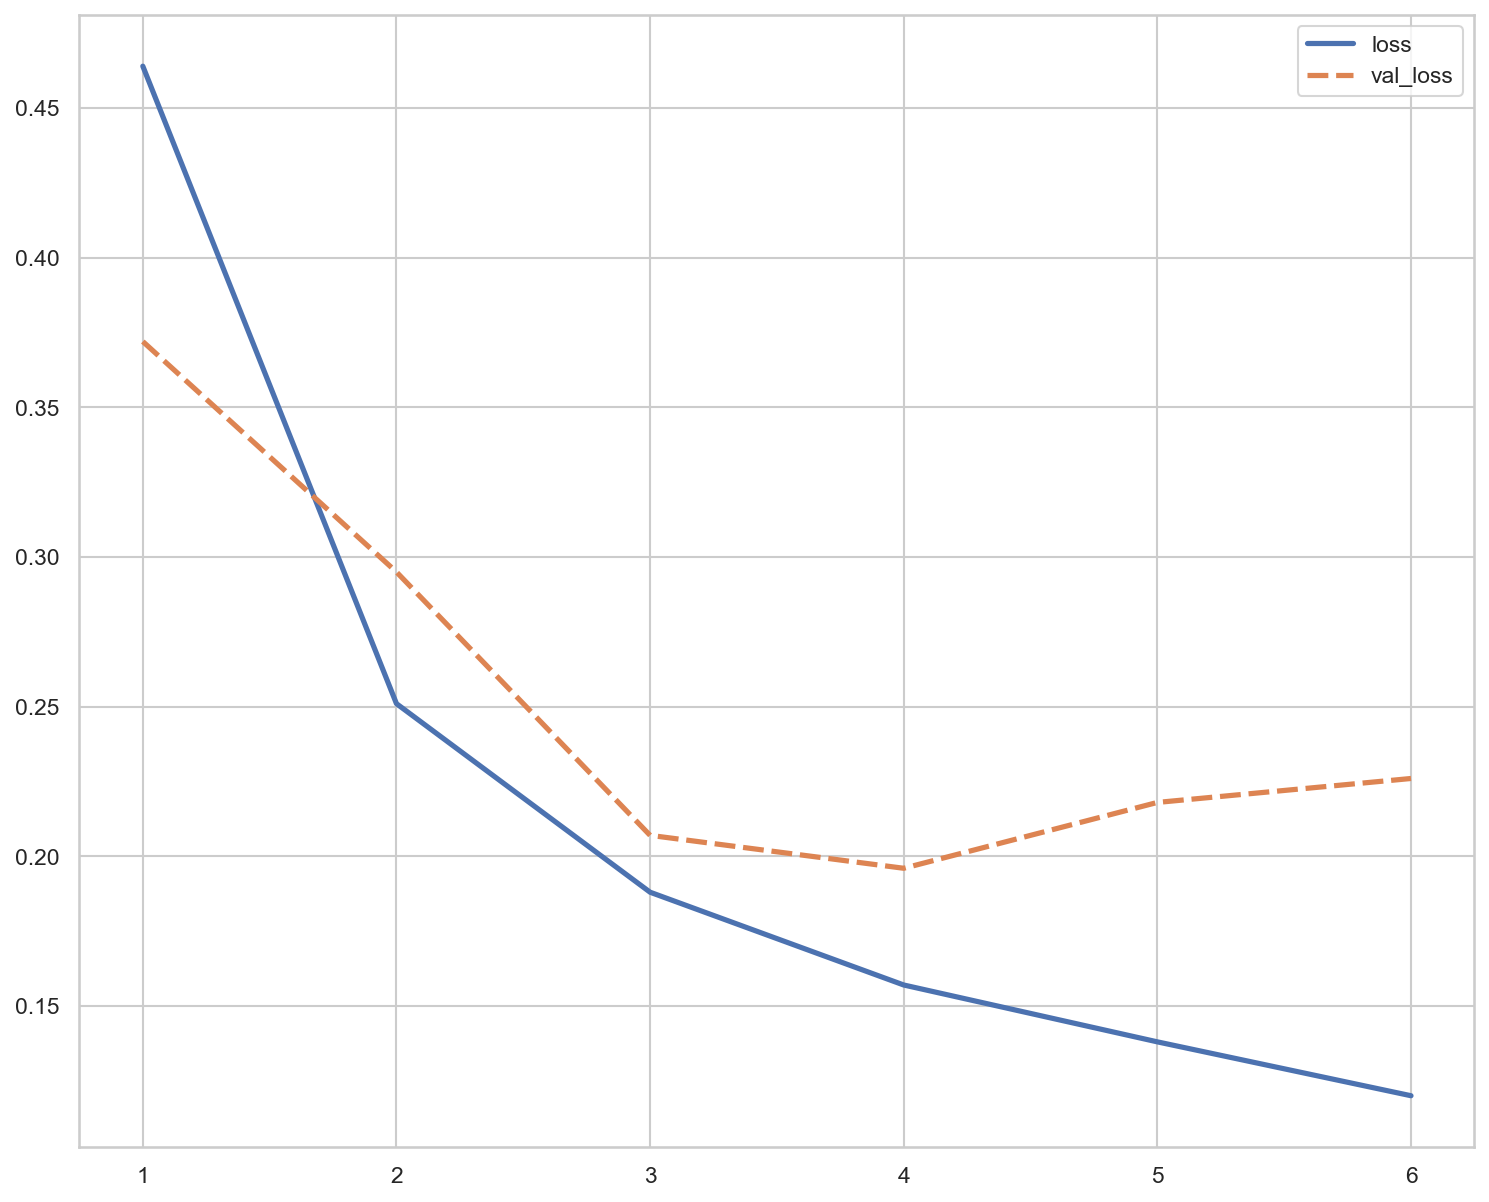

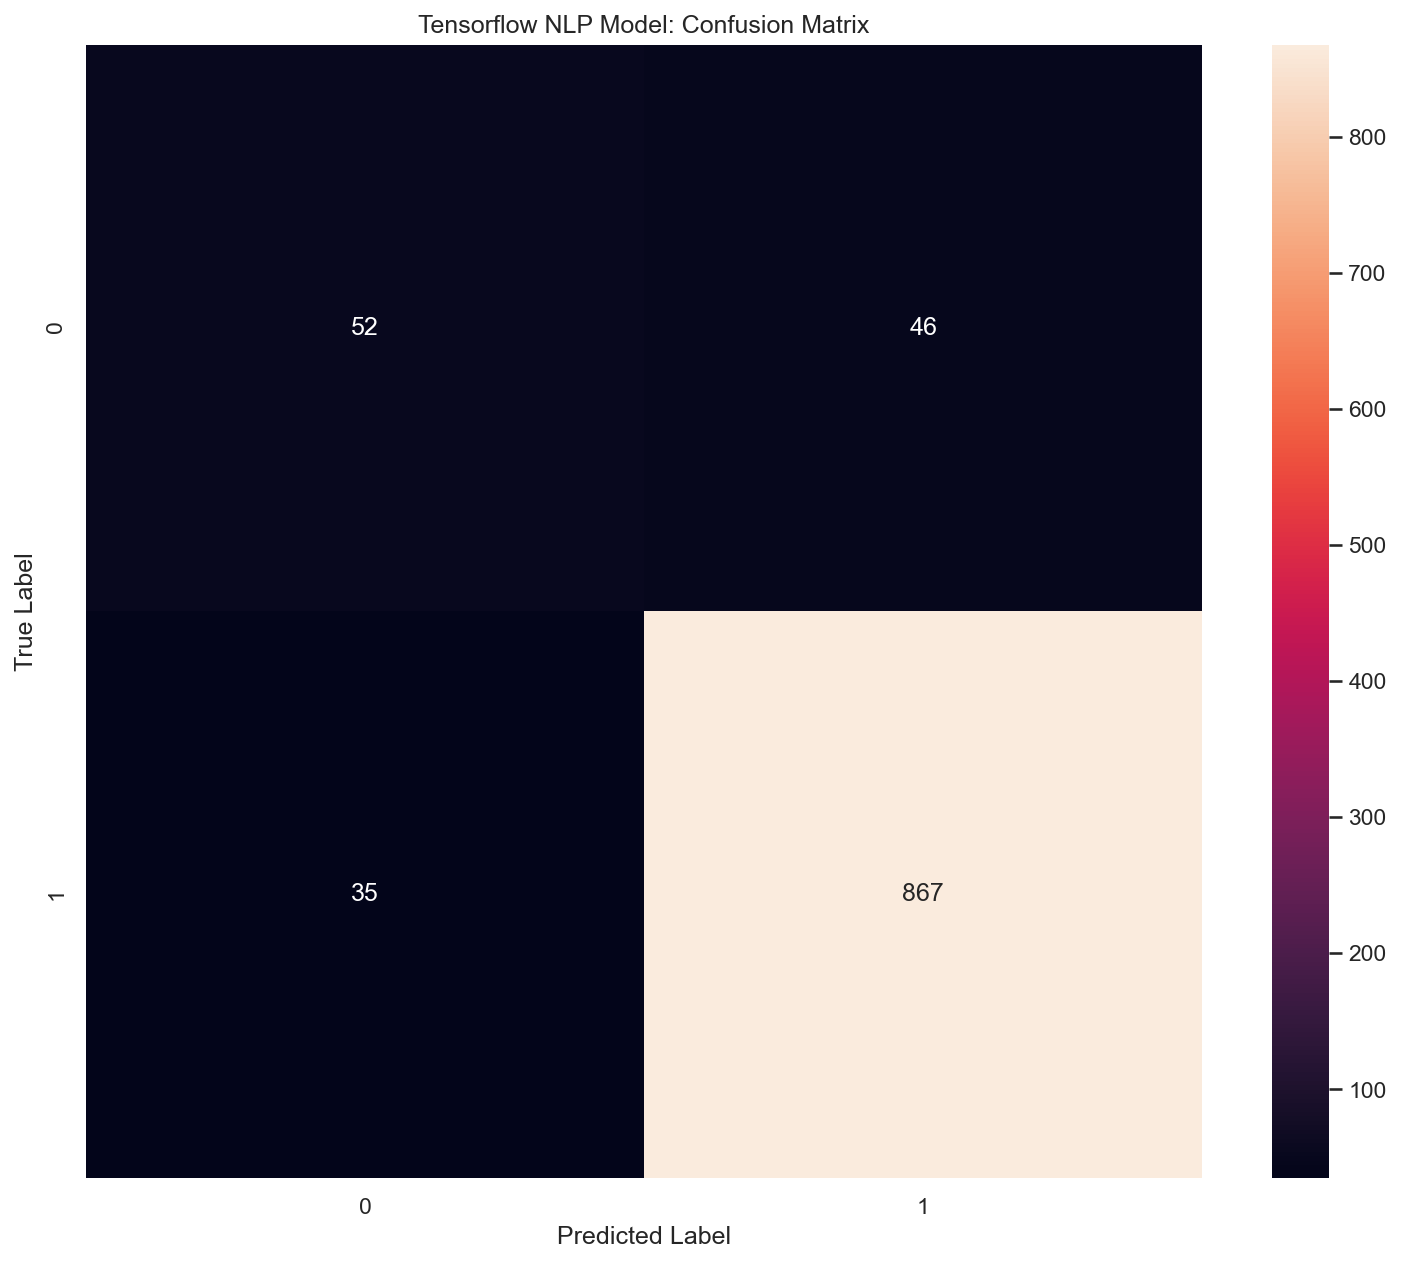

Accuracy: 0.919
Precision: 0.95
Recall / Sensitivity: 0.961
F1 Score: 0.955
ROC-AUC Score: 0.746
Confusion Matrix:
[[ 52  46]
 [ 35 867]]


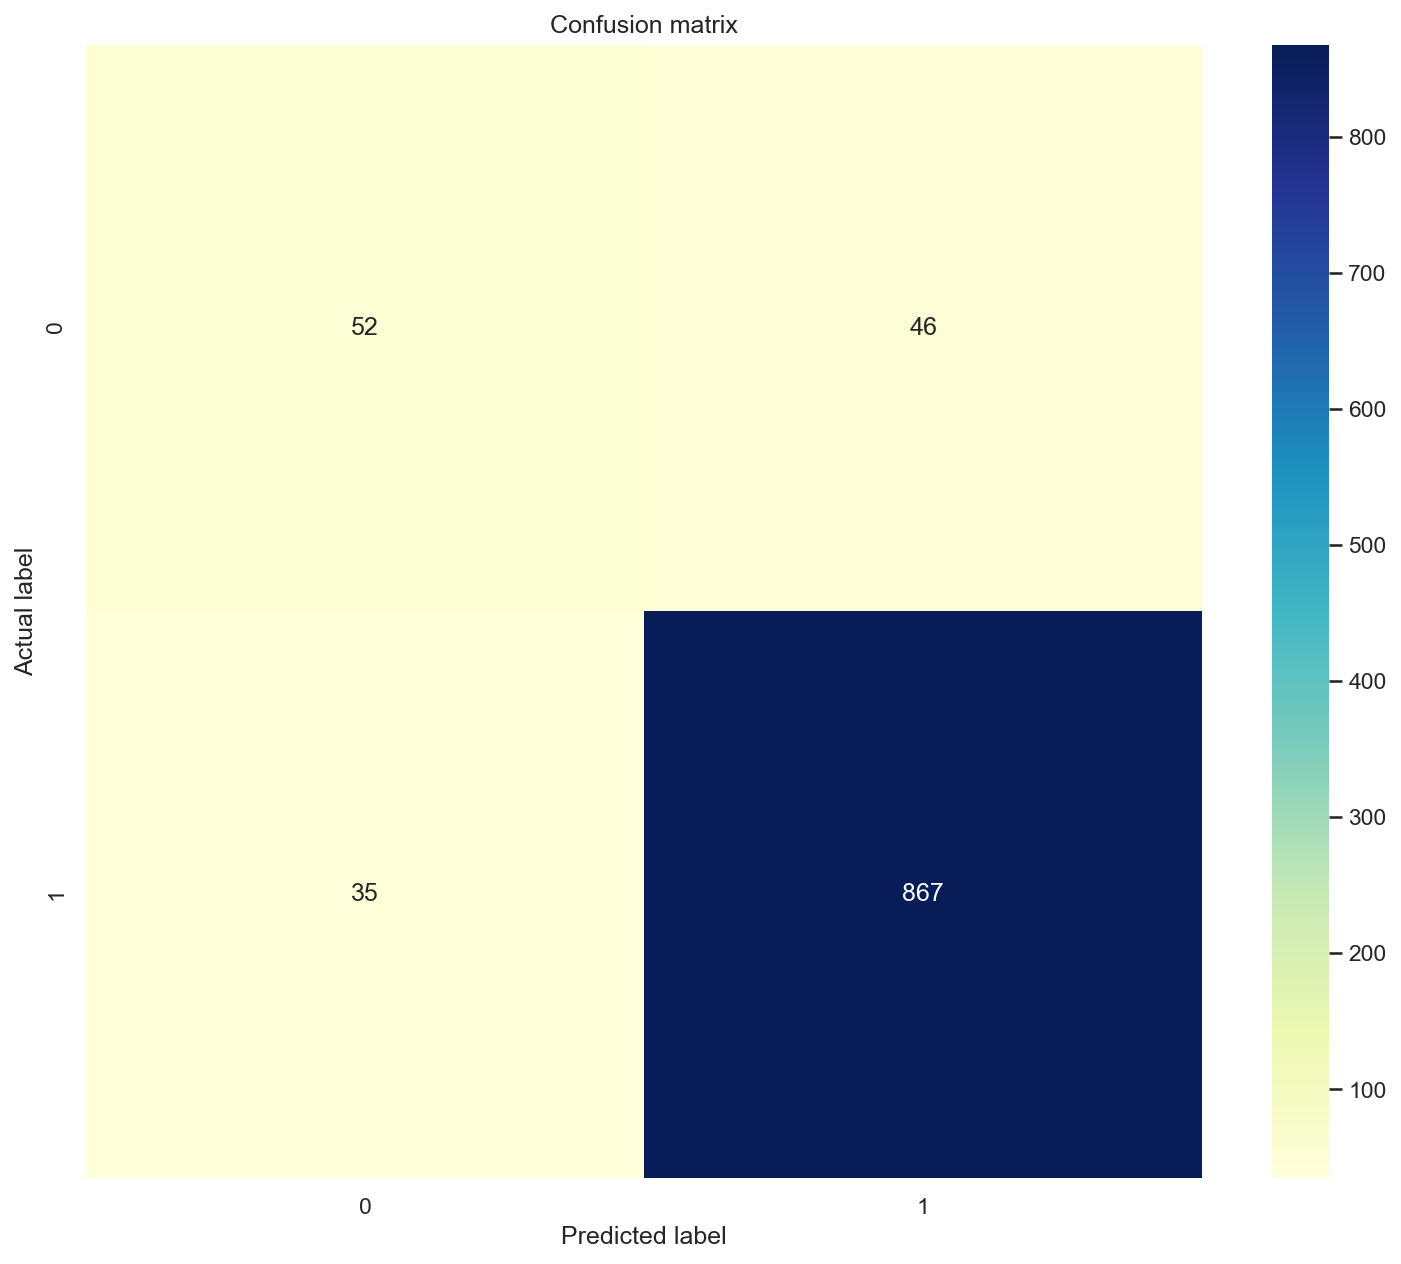

In [260]:

# from tf.keras.layers.normalization import BatchNormalization

from tensorflow.keras.layers import BatchNormalization, Activation, Dense

# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
# https://stackoverflow.com/questions/69471749/importerror-cannot-import-name-batchnormalization-from-keras-layers-normaliz
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

def create_network():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=2,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=False
    )    

    model = Sequential()
    
    # input layer
    model.add(Embedding(input_dim=vocab_size, output_dim=max_sequence_embedding, input_length=len(X_train[0]) )) 
    
    # hidden layers 1
    model.add(LSTM(units=60))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))    
    
    # hidden layers 2
    model.add(keras.layers.Dense(30))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))
    
    # output layer
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))    

    model.compile(optimizer="adam",
                  loss=tf.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])    
    
    model.summary()
    
    history = model.fit(x=X_train, y=y_train, epochs=20, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test), verbose=2)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy     
    
    model.save("FINAL_MODEL.keras")
    
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]

    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix
        
    num_epochs = len(history.history.get("loss", []))
    num_epochs
    plot_scores(history=history, model=model, num_epochs = range(1,num_epochs+1), ticks=range(0,num_epochs))
        

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax = ax)
    ax.set_title('Tensorflow NLP Model: Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()    
    
    create_conf_matrix(y_test, predictions)
    
create_network()  



# len(X_train[0])

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, 77, 128)           15650560  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               22900     
                                                                 
 activation_60 (Activation)  (None, 100)               0         
                                                                 
 batch_normalization_82 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 100)               0         
                                                                 
 dense_106 (Dense)           (None, 30)                3030      
                                                     

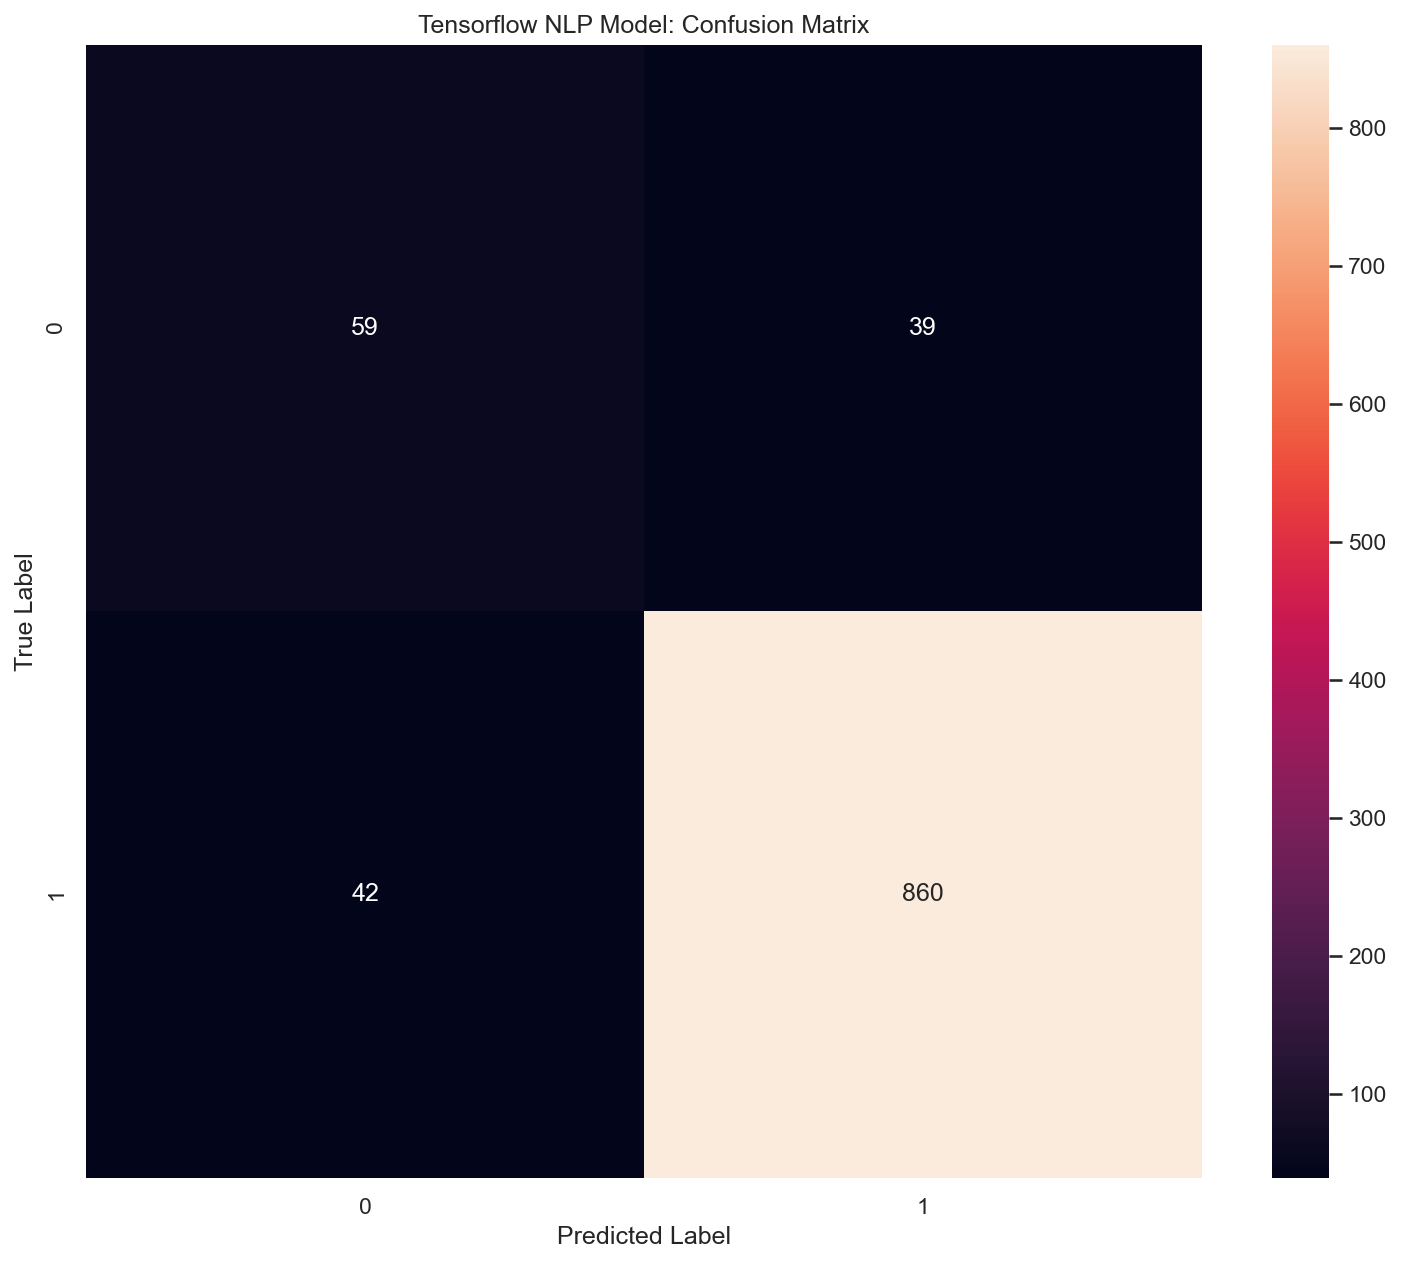

Accuracy: 0.919
Precision: 0.957
Recall / Sensitivity: 0.953
F1 Score: 0.955
ROC-AUC Score: 0.778
Confusion Matrix:
[[ 59  39]
 [ 42 860]]


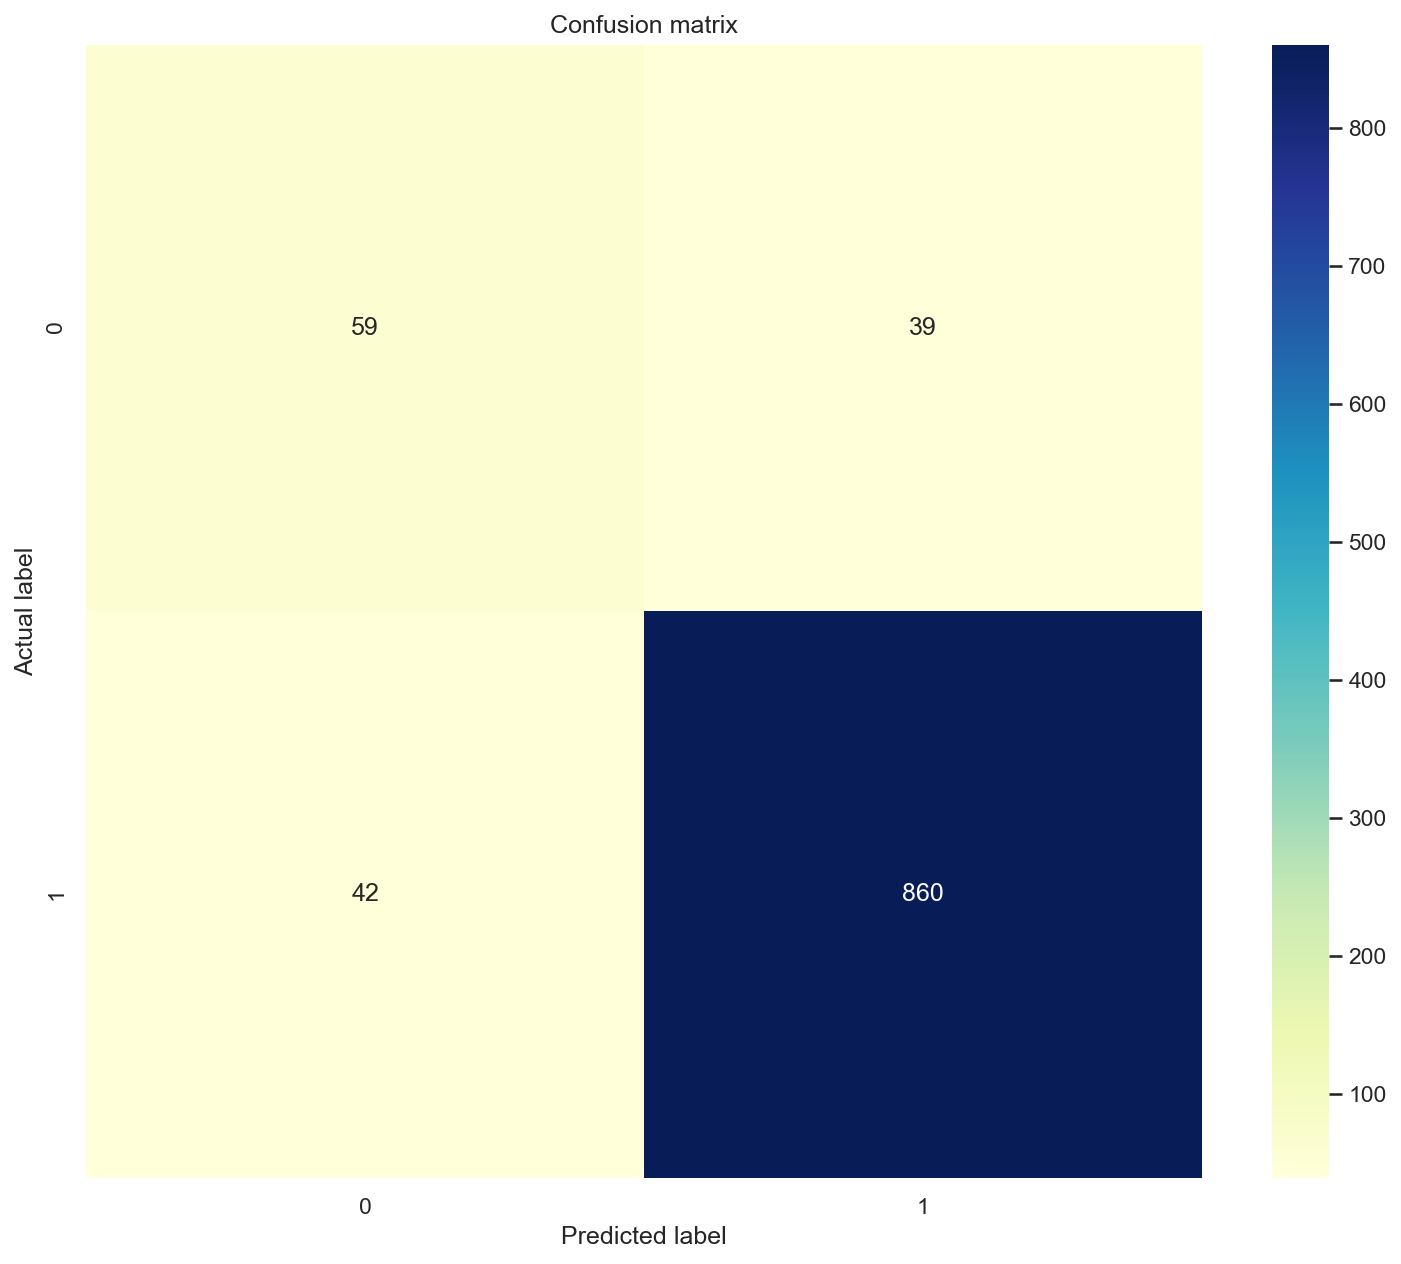

In [204]:

# from tf.keras.layers.normalization import BatchNormalization

from tensorflow.keras.layers import BatchNormalization, Activation, Dense

# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
# https://stackoverflow.com/questions/69471749/importerror-cannot-import-name-batchnormalization-from-keras-layers-normaliz
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

def create_network():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=2,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=False
    )    

    # `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
    model = Sequential()
    
    # input
    model.add(Embedding(input_dim=vocab_size, output_dim=max_sequence_embedding, input_length=len(X_train[0]) )) 
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))    
    # model.add(Dropout(0.5))
    
    # hidden 1
    # model.add(LSTM(units=60, activation="tanh"))
    # keras.layers.SimpleRNN
    model.add(keras.layers.SimpleRNN(units = 100, activation='relu', use_bias=True))
    
    # model.add(LSTM(units=60))    
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))    
    
    # hidden 2
    # model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(30))    
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))
    
    # model.add(Dense(64))
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    # model.add(Dropout(0.5))    
    
    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))    

    # Configures the model for training.
    model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])    
    
    # model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

    # Prints a string summary of the network.
    model.summary()
    
    history = model.fit(x=X_train, y=y_train, epochs=20, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test), verbose=2)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy     
    
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    # predictions
    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax = ax)
    ax.set_title('Tensorflow NLP Model: Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()    
    
    create_conf_matrix(y_test, predictions)
    
create_network()  



# len(X_train[0])

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_72 (Embedding)    (None, 77, 128)           14540544  
                                                                 
 lstm_53 (LSTM)              (None, 100)               91600     
                                                                 
 activation_80 (Activation)  (None, 100)               0         
                                                                 
 batch_normalization_102 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 dropout_51 (Dropout)        (None, 100)               0         
                                                                 
 dense_117 (Dense)           (None, 1)                 101       
                                                     

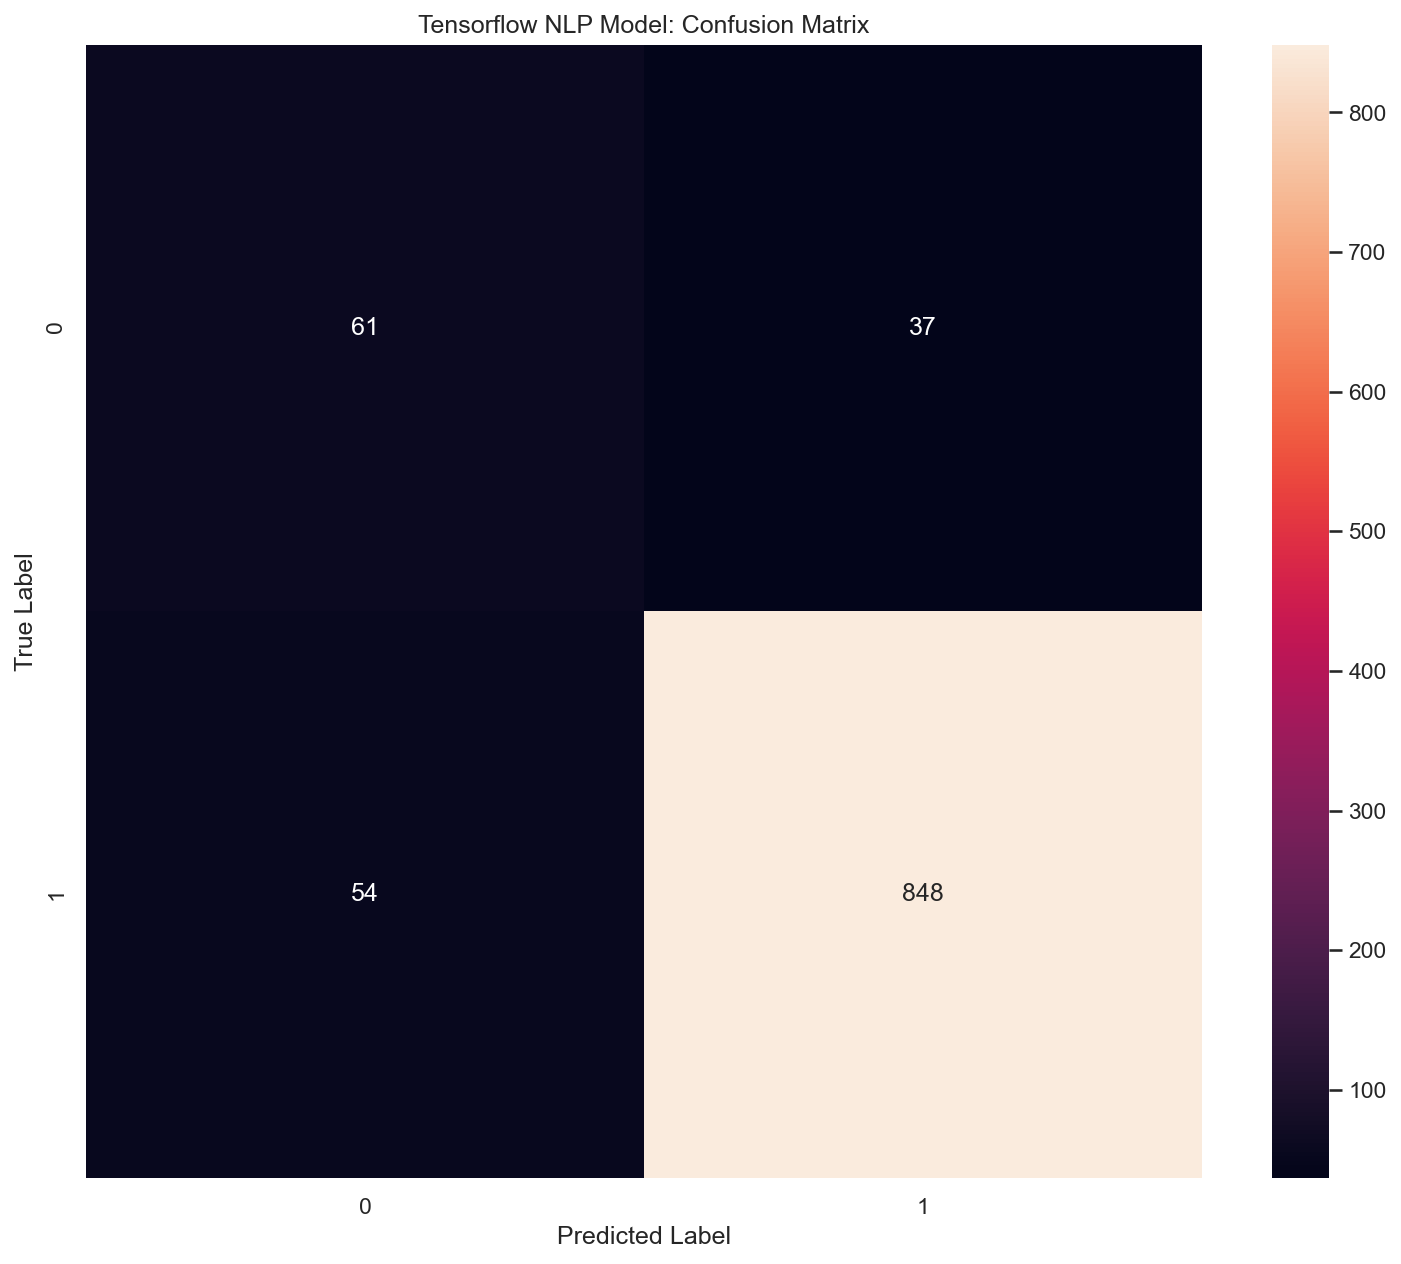

Accuracy: 0.909
Precision: 0.958
Recall / Sensitivity: 0.94
F1 Score: 0.949
ROC-AUC Score: 0.781
Confusion Matrix:
[[ 61  37]
 [ 54 848]]


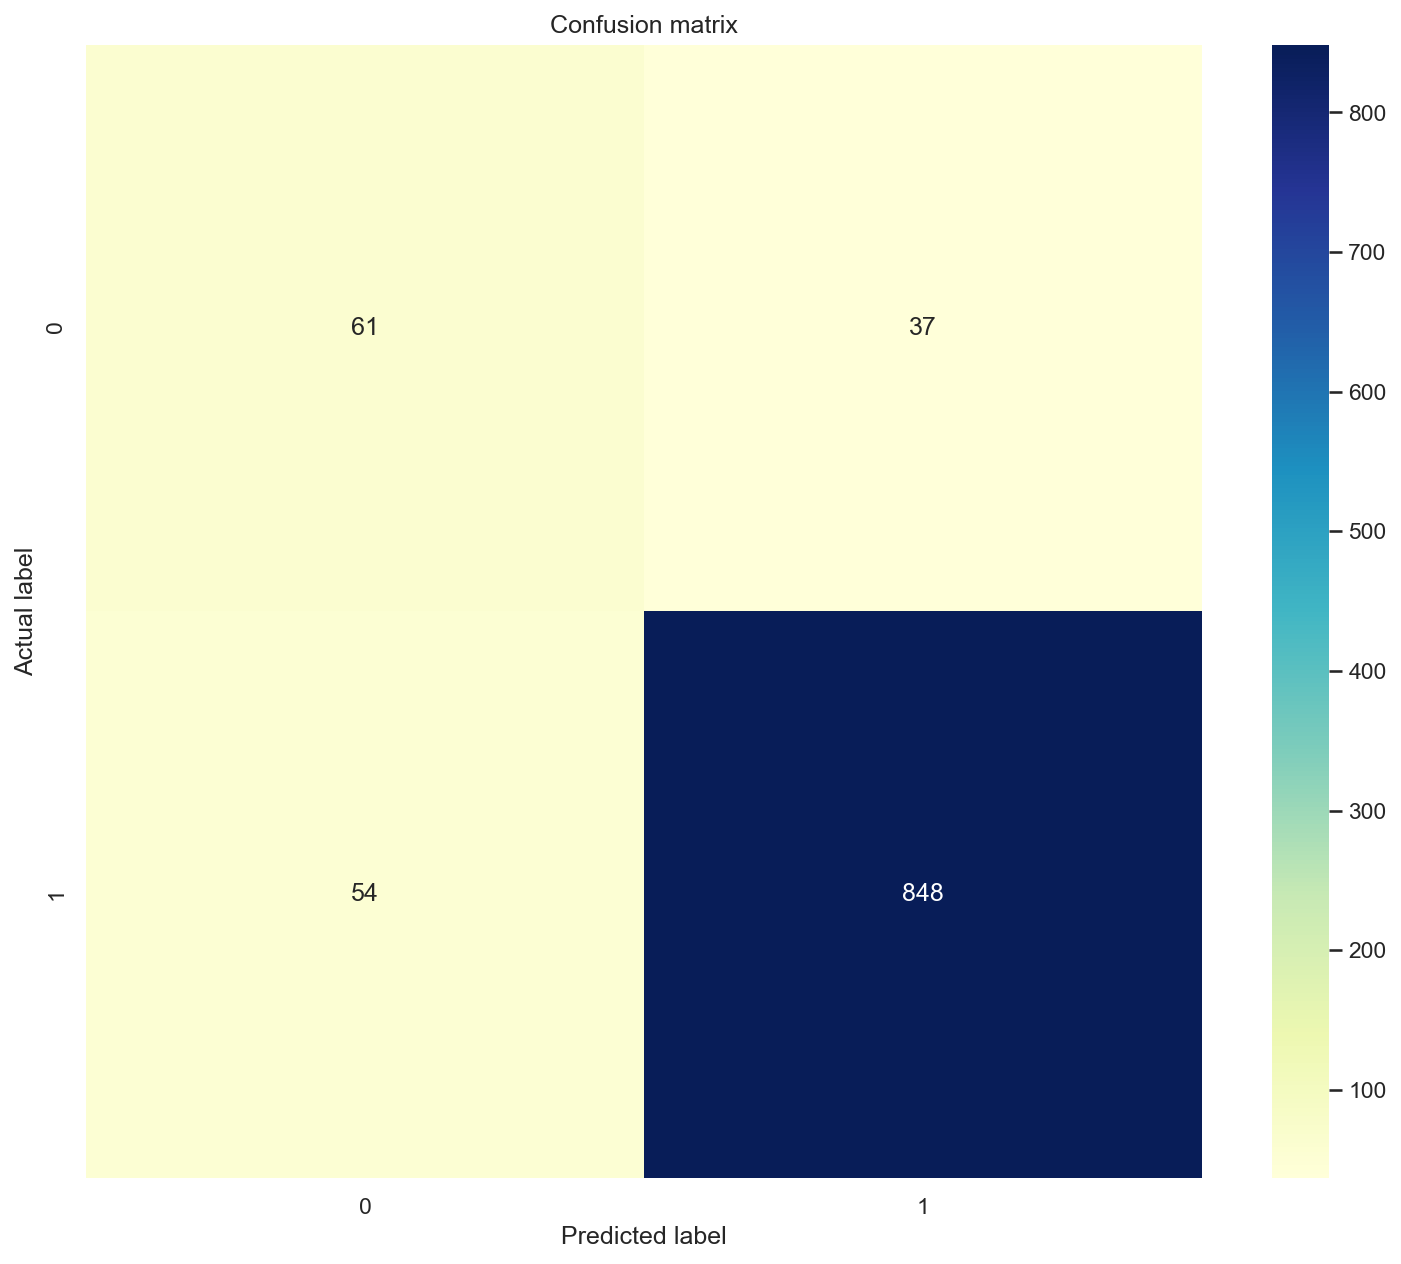

In [215]:

# from tf.keras.layers.normalization import BatchNormalization

from tensorflow.keras.layers import BatchNormalization, Activation, Dense

# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
# https://stackoverflow.com/questions/69471749/importerror-cannot-import-name-batchnormalization-from-keras-layers-normaliz
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

def create_network():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=2,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=False
    )    

    # `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
    model = Sequential()
    
    # input
    model.add(Embedding(input_dim=vocab_size, output_dim=max_sequence_embedding, input_length=len(X_train[0]) )) 
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))    
    # model.add(Dropout(0.5))
    
    # hidden 1
    model.add(LSTM(units=100, use_bias=True))
    # keras.layers.SimpleRNN
    # model.add(keras.layers.SimpleRNN(units = 100, activation='relu', use_bias=True))
    # model.add(keras.layers.SimpleRNN(units = 100, use_bias=True))    
    
    # model.add(LSTM(units=60))    
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))    
    
#     # hidden 2
#     # model.add(keras.layers.Dense(16, activation='relu'))
#     model.add(keras.layers.Dense(30))    
#     # model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())    
#     model.add(Dropout(0.25))
    
    # model.add(Dense(64))
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    # model.add(Dropout(0.5))    
    
    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))    

    # Configures the model for training.
    model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])    
    
    # model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

    # Prints a string summary of the network.
    model.summary()
    
    history = model.fit(x=X_train, y=y_train, epochs=20, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test), verbose=2)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy     
    
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    # predictions
    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax = ax)
    ax.set_title('Tensorflow NLP Model: Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()    
    
    create_conf_matrix(y_test, predictions)
    
create_network()  



# len(X_train[0])

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_71 (Embedding)    (None, 77, 128)           14540544  
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 100)               22900     
                                                                 
 activation_78 (Activation)  (None, 100)               0         
                                                                 
 batch_normalization_100 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 dropout_50 (Dropout)        (None, 100)               0         
                                                                 
 dense_116 (Dense)           (None, 1)                 101       
                                                     

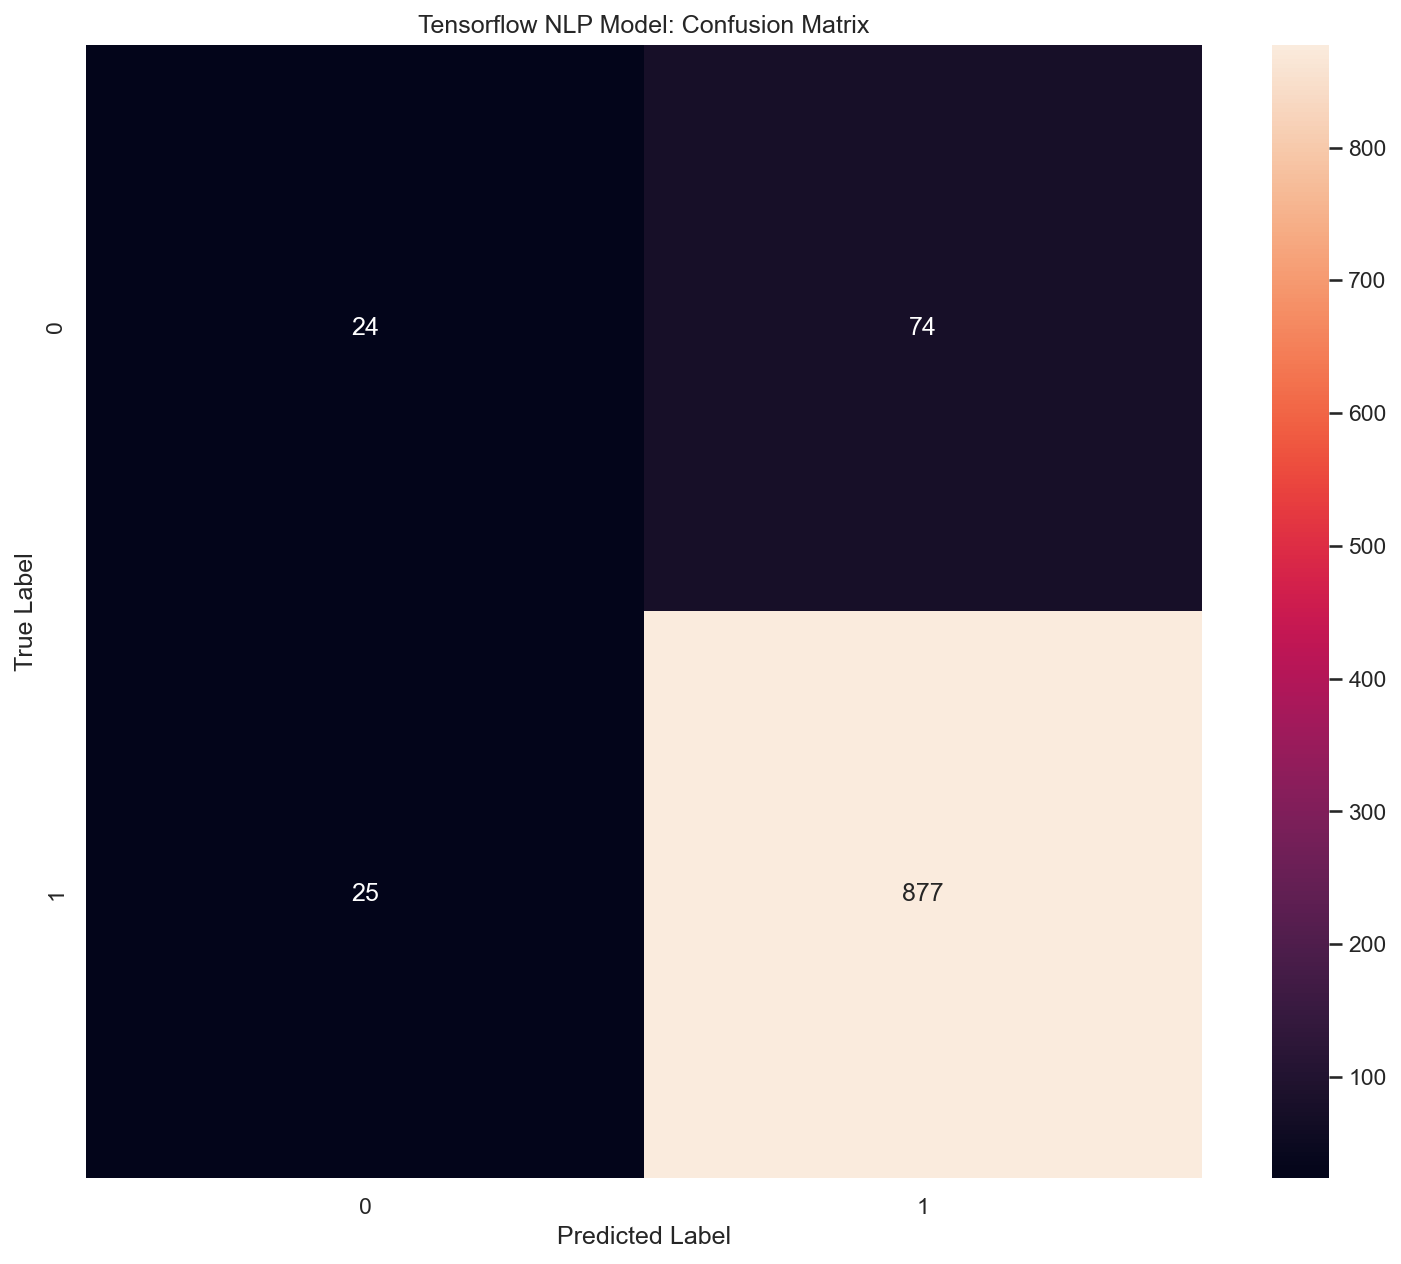

Accuracy: 0.901
Precision: 0.922
Recall / Sensitivity: 0.972
F1 Score: 0.947
ROC-AUC Score: 0.609
Confusion Matrix:
[[ 24  74]
 [ 25 877]]


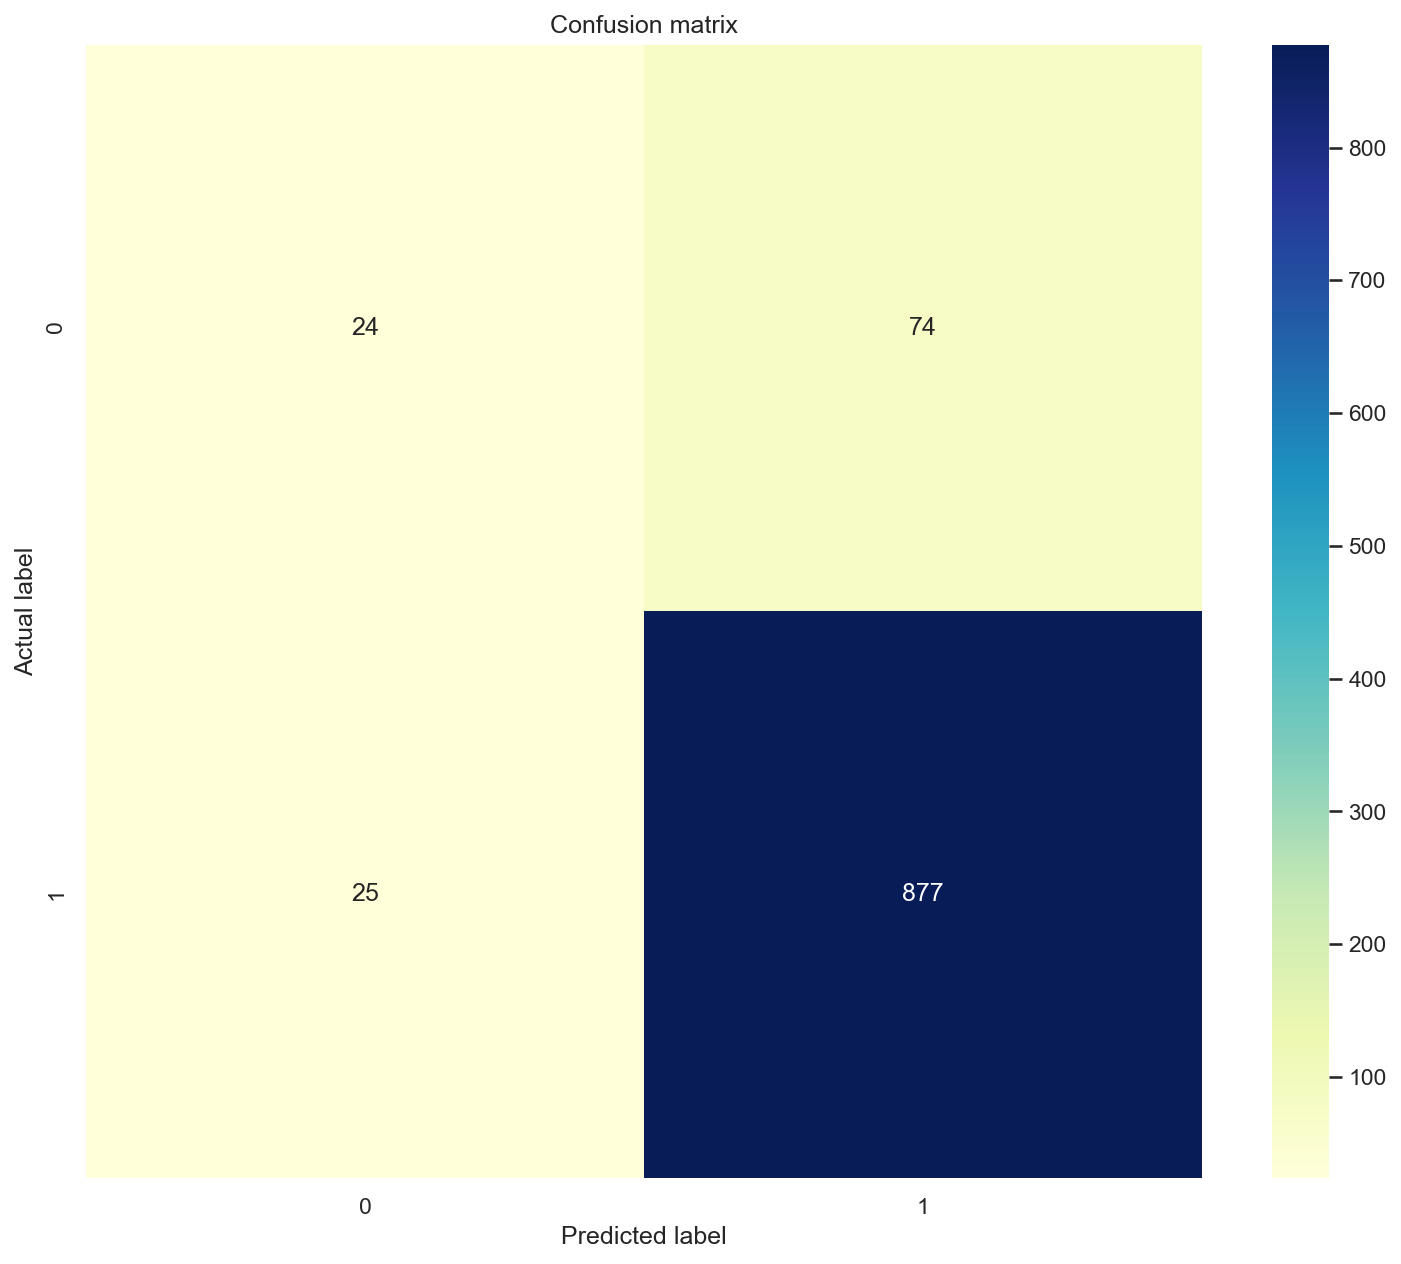

In [214]:

# from tf.keras.layers.normalization import BatchNormalization

from tensorflow.keras.layers import BatchNormalization, Activation, Dense

# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
# https://stackoverflow.com/questions/69471749/importerror-cannot-import-name-batchnormalization-from-keras-layers-normaliz
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

def create_network():
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=2,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=False
    )    

    # `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
    model = Sequential()
    
    # input
    model.add(Embedding(input_dim=vocab_size, output_dim=max_sequence_embedding, input_length=len(X_train[0]) )) 
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))    
    # model.add(Dropout(0.5))
    
    # hidden 1
    # model.add(LSTM(units=60, activation="tanh"))
    # keras.layers.SimpleRNN
    # model.add(keras.layers.SimpleRNN(units = 100, activation='relu', use_bias=True))
    model.add(keras.layers.SimpleRNN(units = 100, use_bias=True))    
    
    # model.add(LSTM(units=60))    
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))    
    
#     # hidden 2
#     # model.add(keras.layers.Dense(16, activation='relu'))
#     model.add(keras.layers.Dense(30))    
#     # model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())    
#     model.add(Dropout(0.25))
    
    # model.add(Dense(64))
    # model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    # model.add(Dropout(0.5))    
    
    # output
    model.add(Dense(units=1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))    

    # Configures the model for training.
    model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])    
    
    # model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

    # Prints a string summary of the network.
    model.summary()
    
    history = model.fit(x=X_train, y=y_train, epochs=20, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test), verbose=2)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    loss, accuracy     
    
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    # predictions
    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax = ax)
    ax.set_title('Tensorflow NLP Model: Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()    
    
    create_conf_matrix(y_test, predictions)
    
create_network()  



# len(X_train[0])

In [68]:
# ! pip install tensorflow_hub

from tensorflow.keras import activations
from tensorflow.keras import layers
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string)



    


def create_network2():
    embedding_vector_length = 19
    # embedding_vector_length = max_sequence_embedding or 19

    model = Sequential()
    
    # model.add(hub_layer)
    
    embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=max_review_length )

    model.add(embedding_layer)
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    
#     model.add(SpatialDropout1D(rate=0.5))
    
#     model.add(tf.keras.layers.Dense(16, activation='relu')) # create hidden layer with 16 nodes
#     model.add(tf.keras.layers.Dense(8, activation='relu')) # create hidden layer with 8 nodes
#     model.add(keras.layers.Dense(4, activation='relu'))
    # model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output layer, 1 node, sigmoid, for binary classification    

#     model.add(layers.Dense(128))

    
    # model.add(tf.keras.layers.BatchNormalization())



#     model.add(SpatialDropout1D(rate=0.5))
#     # model.add(Dropout(rate=0.25))

    LSTM

    # model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))
    # model.add(LSTM())
    # model.add(Dropout(rate=0.20))
    model.add(tf.keras.layers.Dense(100, activation='relu')) # create hidden layer with 16 nodes
    model.add(tf.keras.layers.Dense(50, activation='relu')) # create hidden layer with 8 nodes    
    # model.add(tf.keras.layers.Dense(2, activation='softmax')) # output layer, 1 node, sigmoid, for binary classification  
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output layer, 1 node, sigmoid, for binary classification  


#     # model.add(Flatten())
#     # model.add(Dense(units=1, activation="sigmoid"))
#     # model.add(Dense(1))
#     # layers.Activation
#     # model.add(layers.Activation('softmax'))
#     model.add(Dense(1, activation = "softmax"))


    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
    # model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
    # model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])    

    # Prints a string summary of the network.
    model.summary()

# model2, embedding_layer = create_network2()


    # batch_size = 1000,
    history = model.fit(x=X_train, y=y_train, epochs=1, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))

    # plot_scores(history=history2, model=model2, num_epochs = range(1,2), ticks=range(0,1))
    # # plot_scores(history=history2, model=model2, num_epochs = range(1,4), ticks=range(0,3))

    # y_pred2 = model2.predict(X_test).round().astype(np.int64)
    # list(tf.argmax(y_pred2, axis=-1))
    # y_pred2.argmax()
    # create_conf_matrix(y_test, y_pred2)
    # y_test
    # y_train
    # X_train
    # y_test
    # y_pred2

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    predictions = [p[0] for p in predictions]
    # predictions
    confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
    confusion_matrix

    ax = plt.axes()
    sns.heatmap(confusion_matrix, annot=True, fmt="d", ax = ax)
    ax.set_title('Tensorflow NLP Model: Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()




# create_network2()
# Model: "sequential_23"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  embedding_23 (Embedding)    (None, 316, 19)           2323149   
                                                                 
#  spatial_dropout1d_14 (Spati  (None, 316, 19)          0         
#  alDropout1D)                                                    
                                                                 
#  lstm_21 (LSTM)              (None, 60)                19200     
                                                                 
#  dropout_26 (Dropout)        (None, 60)                0         
                                                                 
#  flatten_11 (Flatten)        (None, 60)                0         
                                                                 
#  dense_18 (Dense)            (None, 1)                 61        
                                                                 

AttributeError: 'list' object has no attribute 'shape'

In [685]:
# len(y_test)
y_pred2 = model2.predict(X_test)
# .round().astype(np.int64)

y_test[:5]

y_pred2[:5]



362/362 [==============================] - 7s 19ms/step


[0, 1, 1, 1, 1]

array([[0.8931774 ],
       [0.89317733],
       [0.89317733],
       [0.89317733],
       [0.89317876]], dtype=float32)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 316, 19)           2323149   
                                                                 
 spatial_dropout1d_36 (Spati  (None, 316, 19)          0         
 alDropout1D)                                                    
                                                                 
 lstm_43 (LSTM)              (None, 120)               67200     
                                                                 
 dropout_48 (Dropout)        (None, 120)               0         
                                                                 
 flatten_32 (Flatten)        (None, 120)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 121       
                                                     

,loss,accuracy,val_loss,val_accuracy
0,0.35,0.90,0.33,0.90
1,0.33,0.90,0.33,0.90
2,0.33,0.90,0.33,0.90
3,0.33,0.90,0.33,0.90
4,0.33,0.90,0.32,0.90


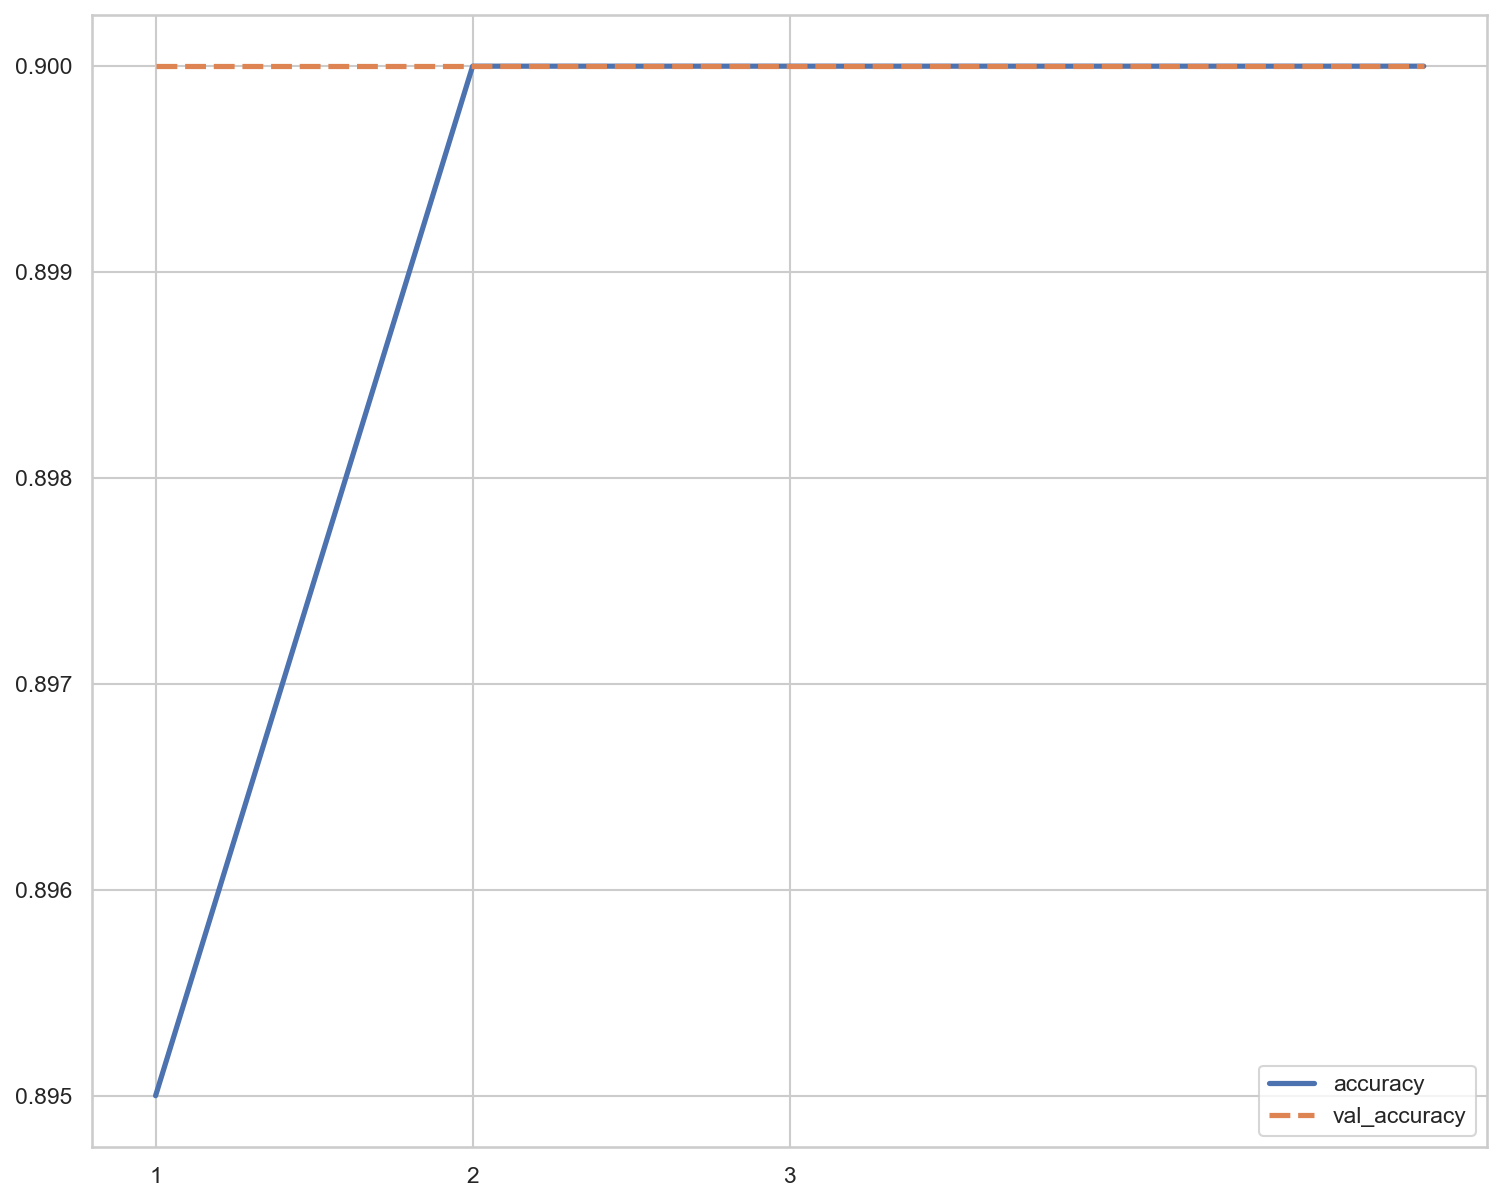

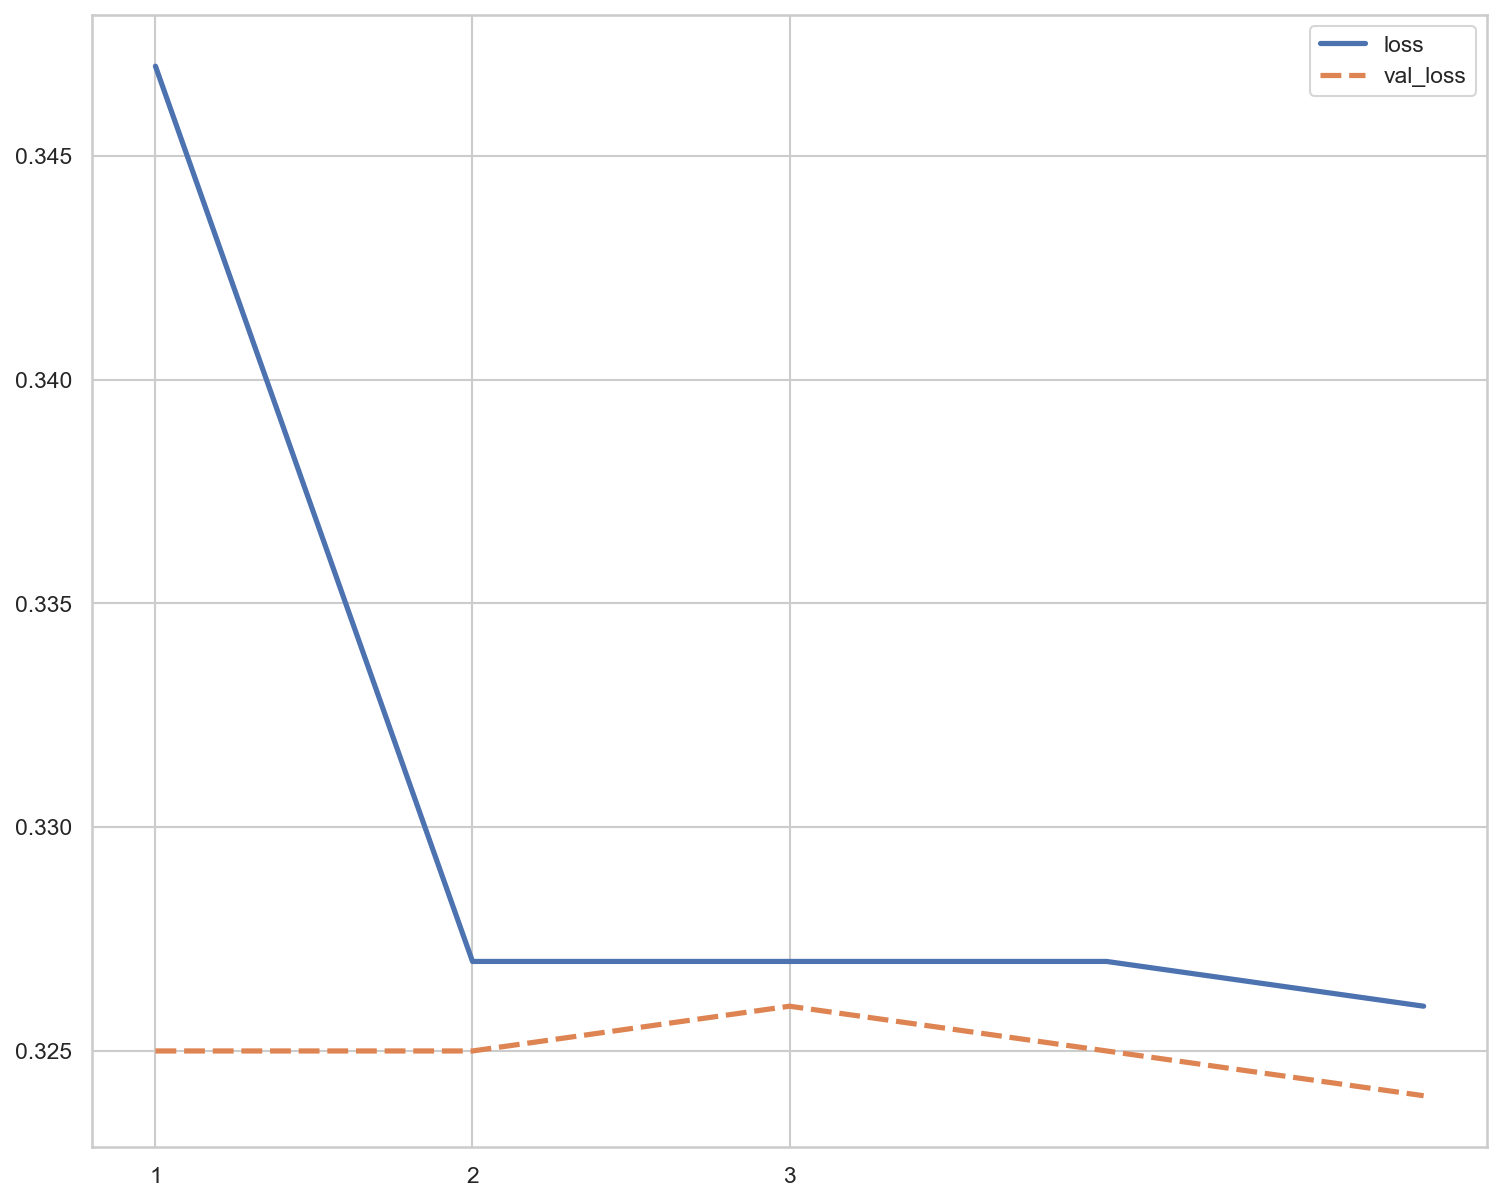

362/362 [==============================] - 19s 51ms/step
Accuracy: 0.9
Precision: 0.9
Recall / Sensitivity: 1.0
F1 Score: 0.947
ROC-AUC Score: 0.5
Confusion Matrix:
[[    0  1160]
 [    0 10424]]


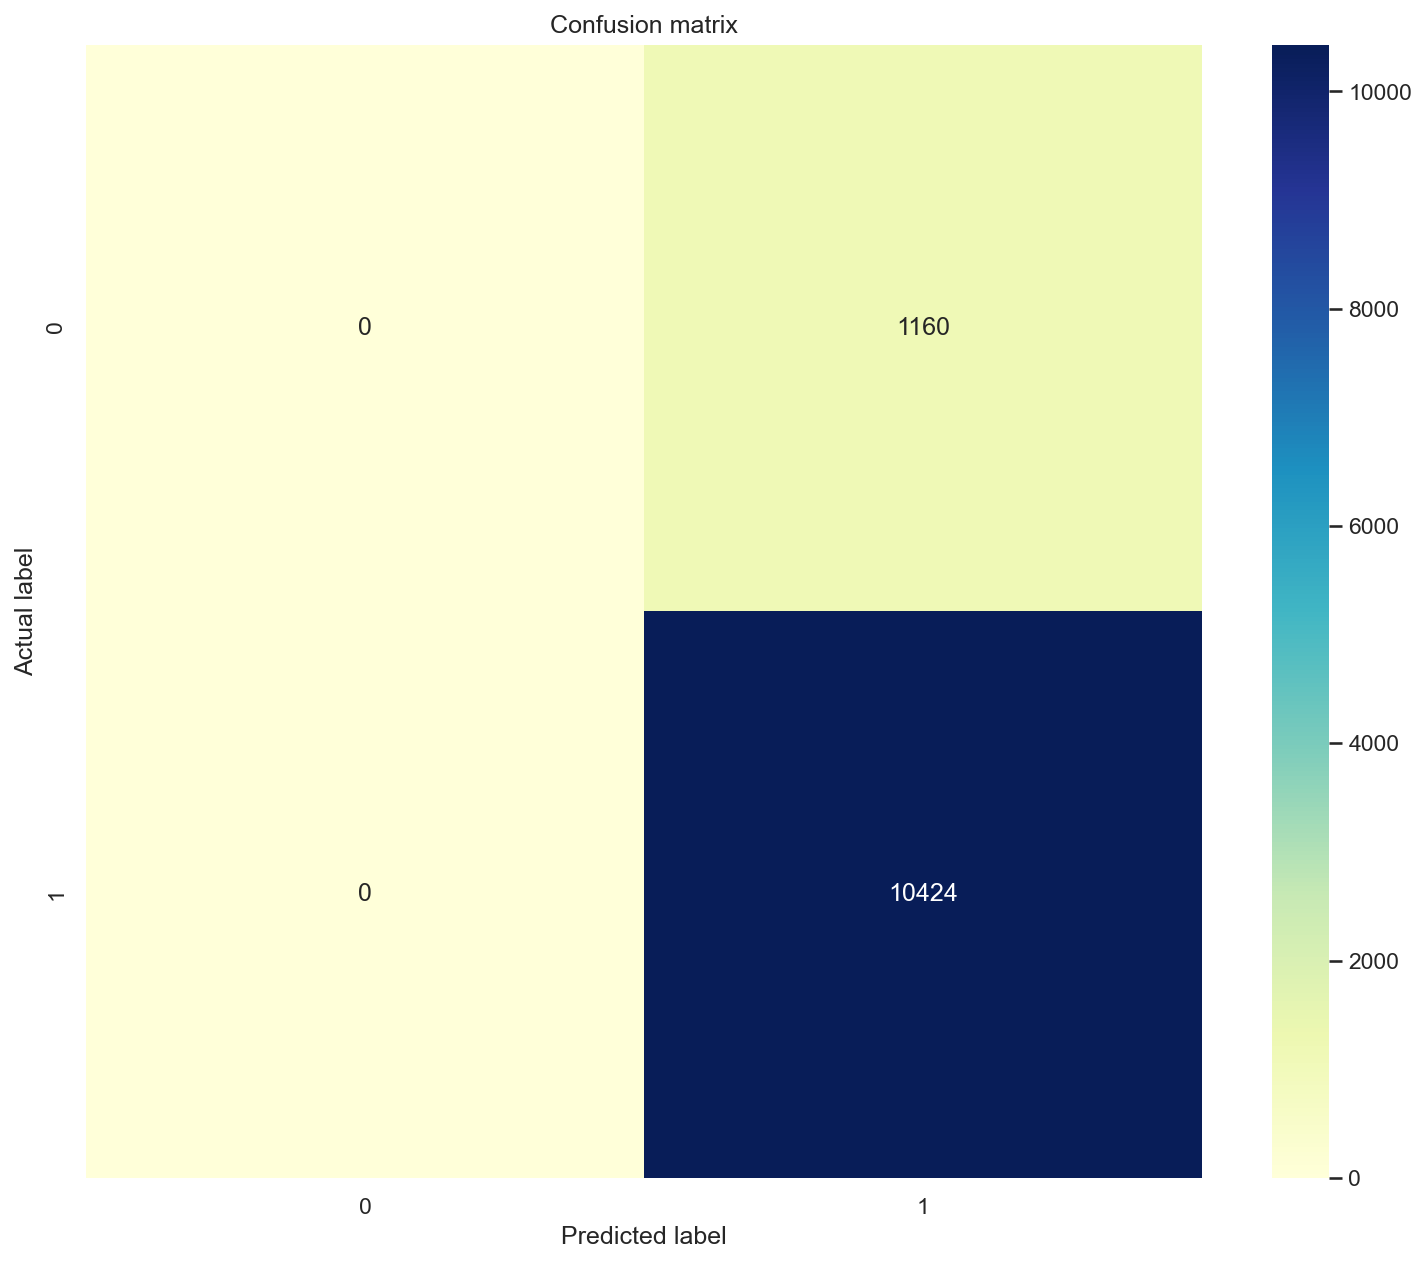

In [650]:
def create_network3():
    embedding_vector_length = 32
    embedding_vector_length = max_sequence_embedding

    model = Sequential()
    
    embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=max_review_length )

    model.add(embedding_layer)


    model.add(SpatialDropout1D(rate=0.5))
    # model.add(Dropout(rate=0.25))

    LSTM

    model.add(LSTM(units=120, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(rate=0.25))

    model.add(Flatten())
    model.add(Dense(units=1, activation="sigmoid"))

    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Prints a string summary of the network.
    model.summary()
    
    return model, embedding_layer

model3, embedding_layer = create_network3()


history3 = model3.fit(x=X_train, y=y_train, epochs=5, batch_size = 256, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))

plot_scores(history=history3, num_epochs = range(1,4), ticks=range(0,3))

y_pred3 = model3.predict(X_test).round().astype(np.int64)
create_conf_matrix(y_test, y_pred3)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 316, 19)           2323149   
                                                                 
 spatial_dropout1d_34 (Spati  (None, 316, 19)          0         
 alDropout1D)                                                    
                                                                 
 lstm_41 (LSTM)              (None, 60)                19200     
                                                                 
 dropout_46 (Dropout)        (None, 60)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 61        
                                                                 
Total params: 2,342,410
Trainable params: 2,342,410
Non-trainable params: 0
___________________________________________

,loss,accuracy,val_loss,val_accuracy
0,0.35,0.89,0.33,0.90
1,0.33,0.90,0.33,0.90
2,0.33,0.90,0.33,0.90
3,0.33,0.90,0.33,0.90
4,0.33,0.90,0.32,0.90


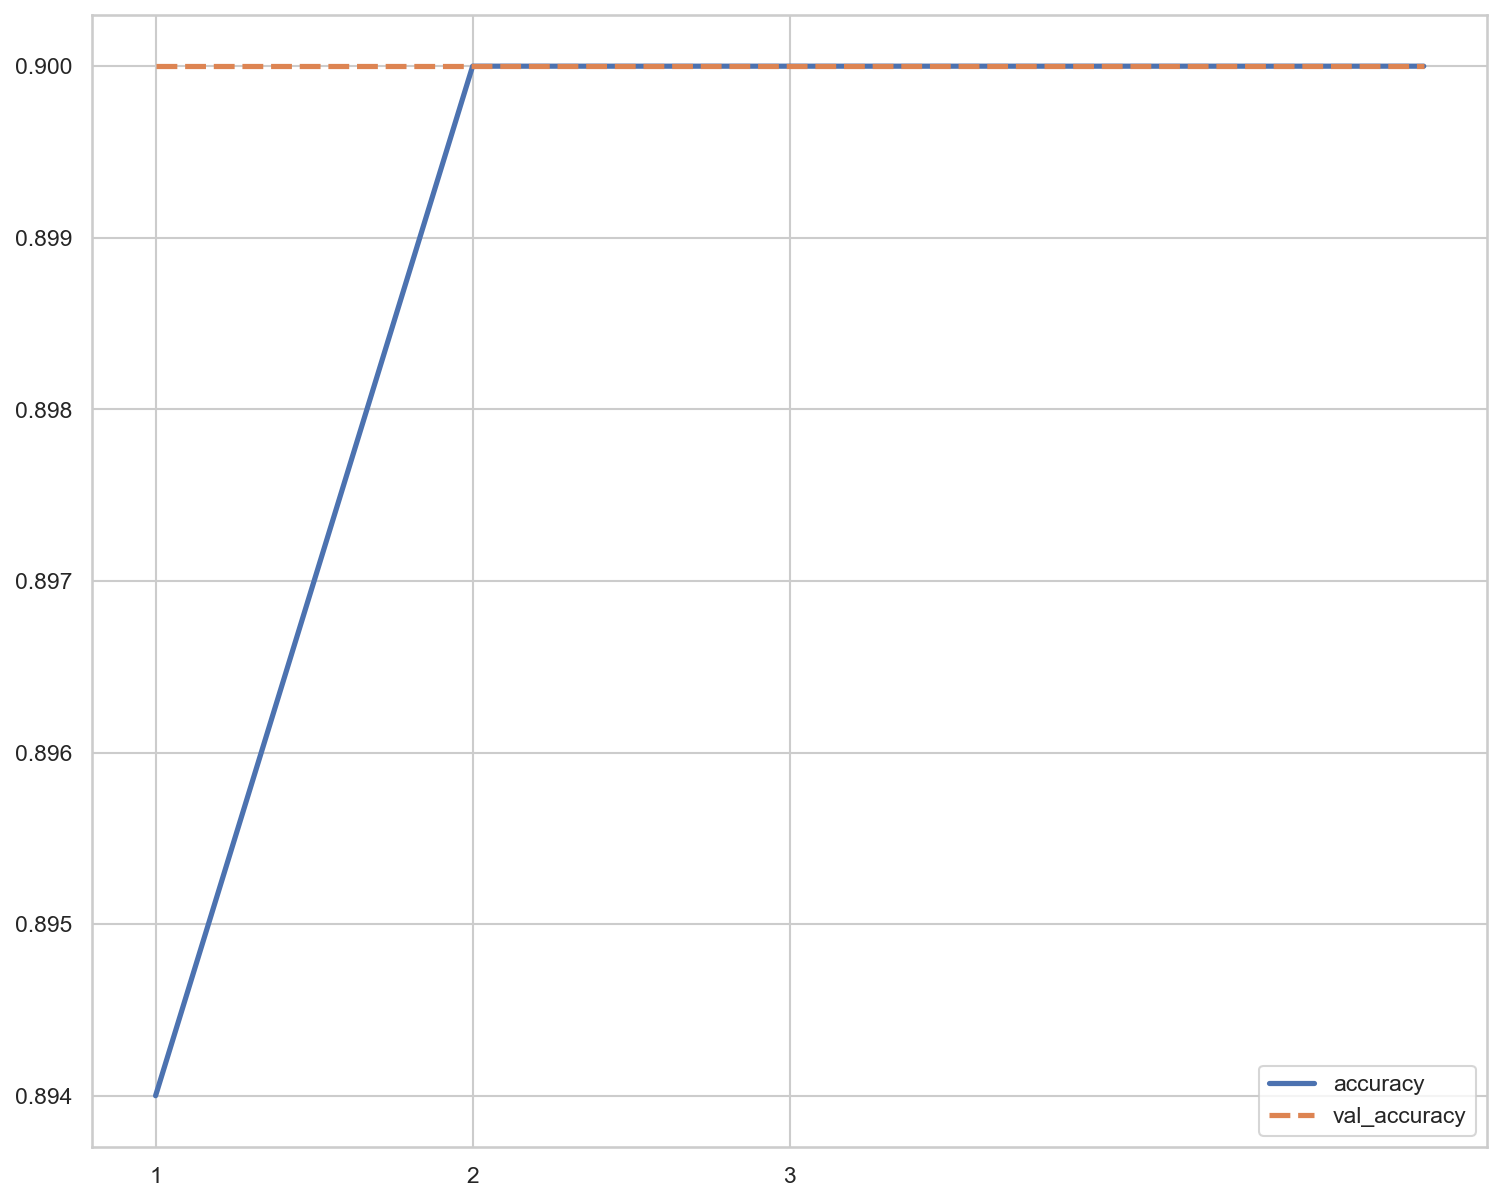

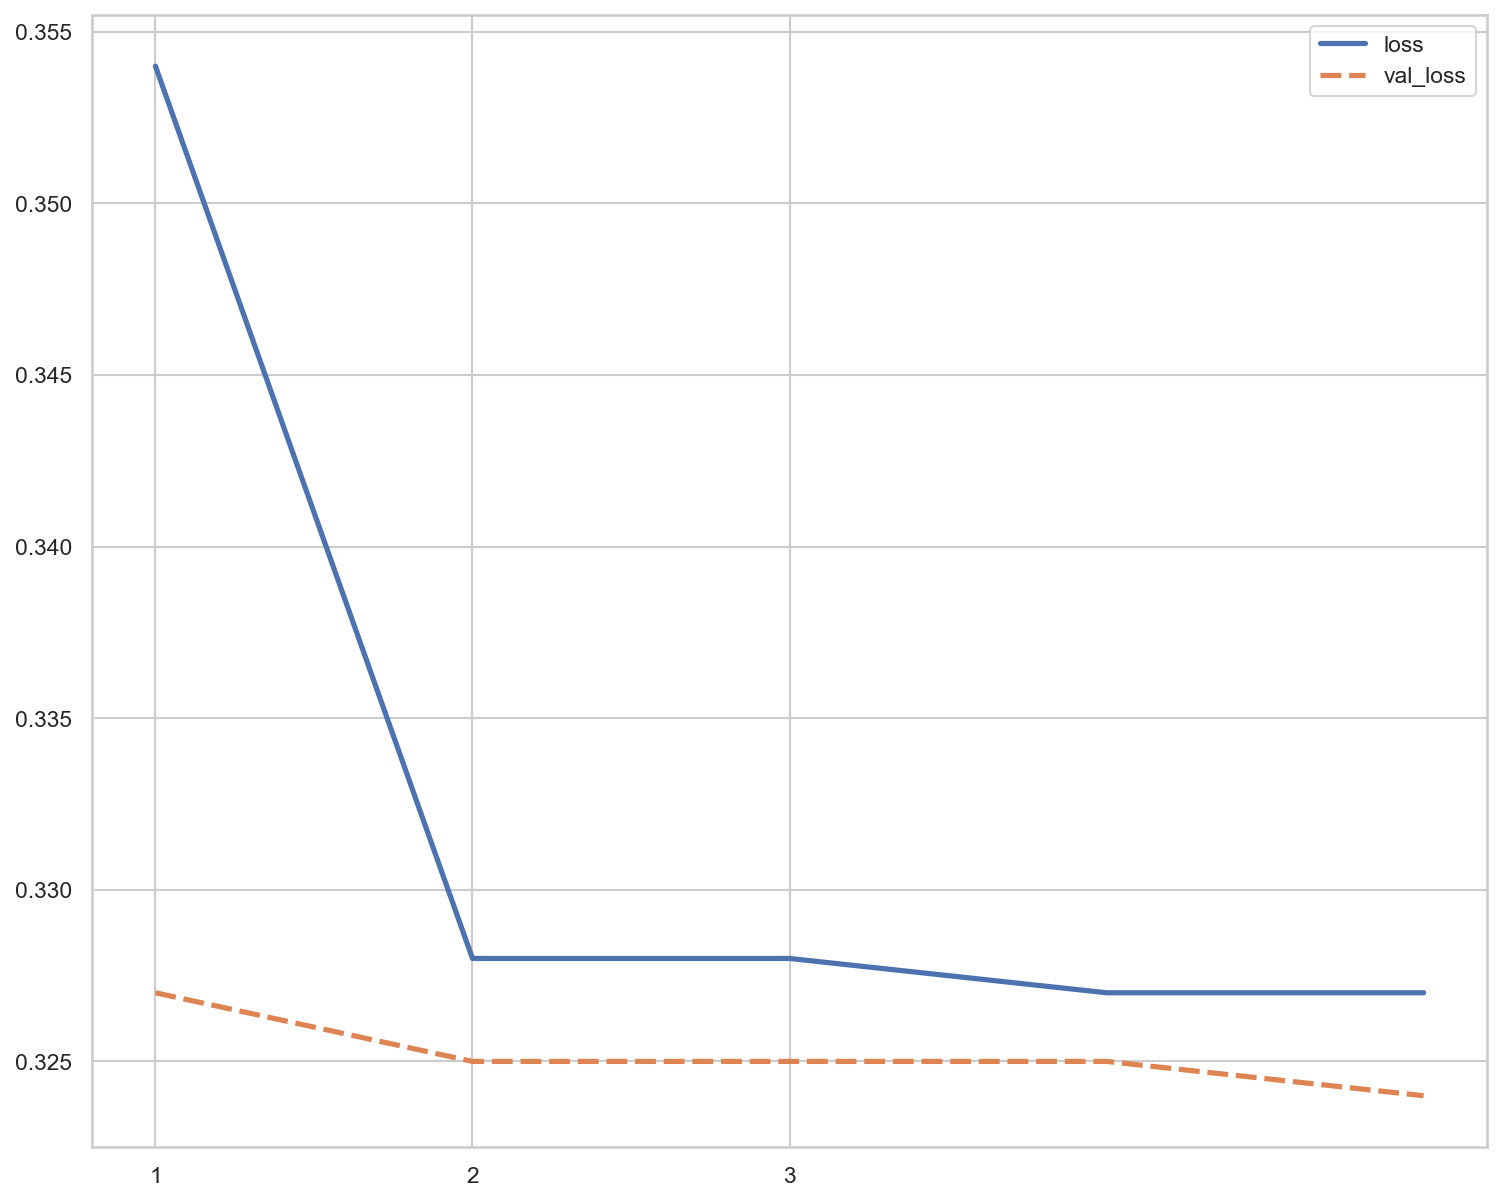

362/362 [==============================] - 7s 20ms/step
Accuracy: 0.9
Precision: 0.9
Recall / Sensitivity: 1.0
F1 Score: 0.947
ROC-AUC Score: 0.5
Confusion Matrix:
[[    0  1160]
 [    0 10424]]


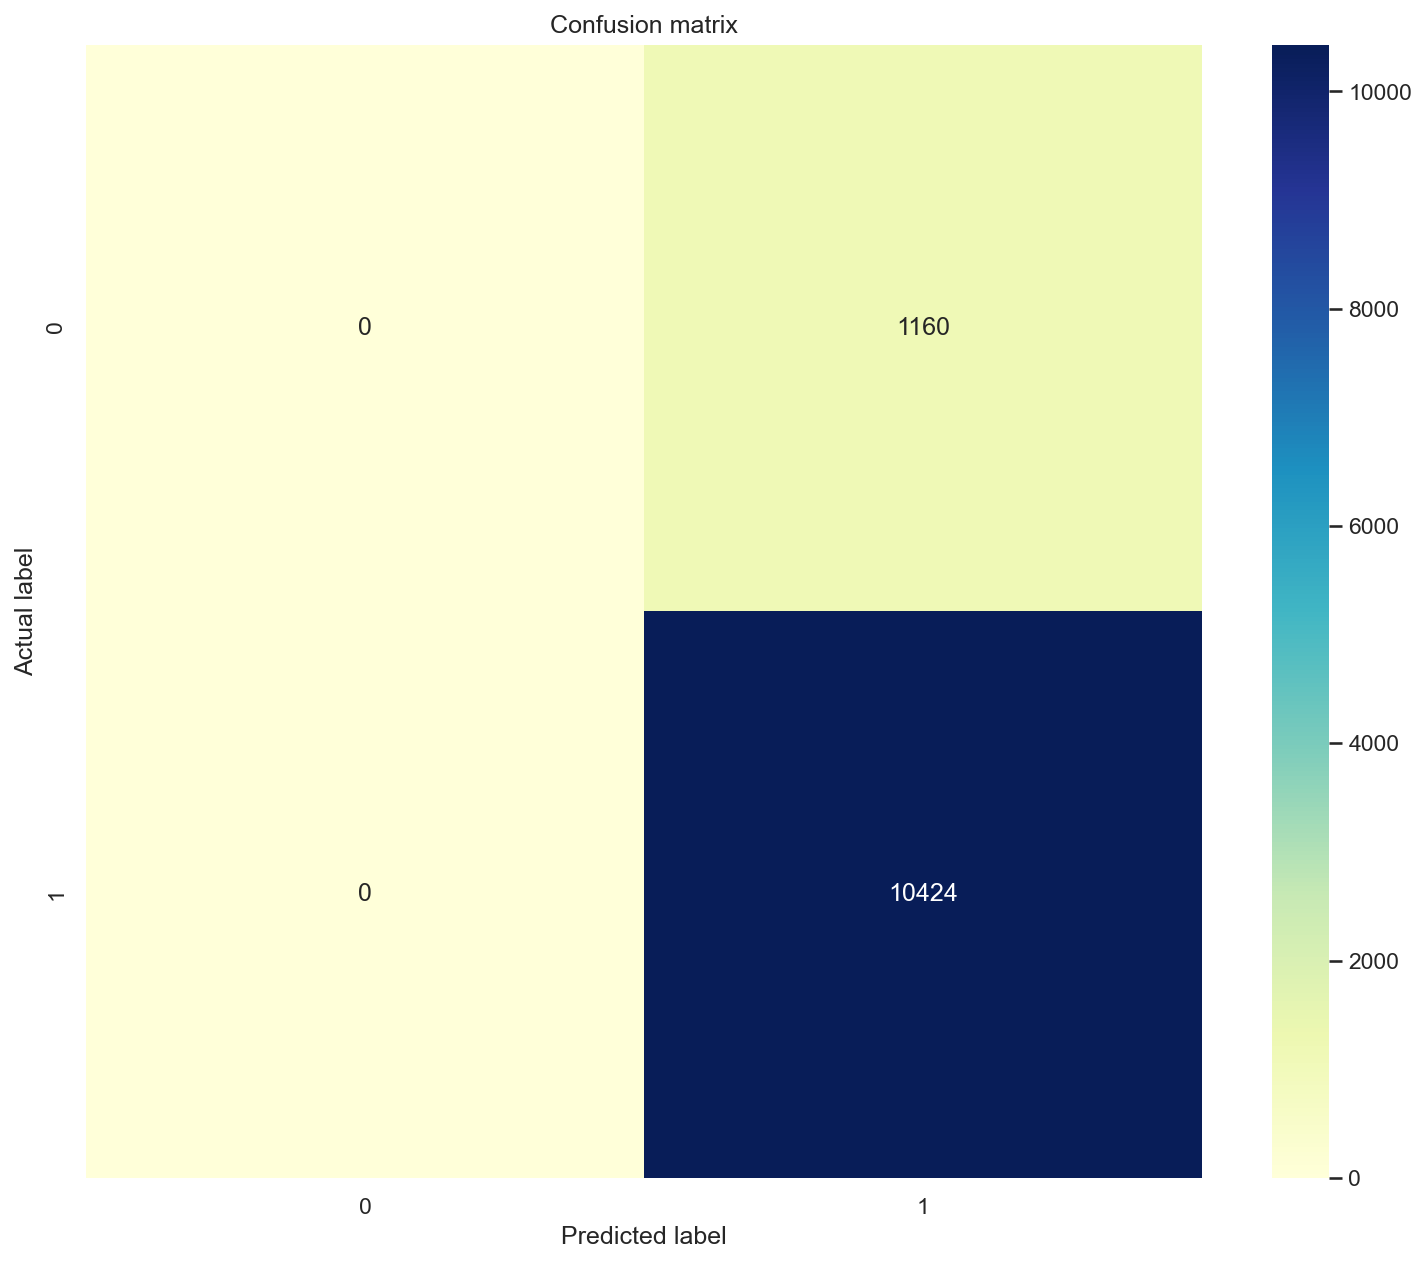

In [648]:
def create_network3():
    embedding_vector_length = 32
    embedding_vector_length = max_sequence_embedding

    model = Sequential()
    
    embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=max_review_length )

    model.add(embedding_layer)


    model.add(SpatialDropout1D(rate=0.5))
    # model.add(Dropout(rate=0.25))

    LSTM

    model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(rate=0.25))
    

    # model.add(Flatten())
    model.add(Dense(units=1, activation="sigmoid"))

    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Prints a string summary of the network.
    model.summary()
    
    return model, embedding_layer

model3, embedding_layer = create_network3()


history3 = model3.fit(x=X_train, y=y_train, epochs=5, batch_size = 2**8, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))

plot_scores(history=history3, num_epochs = range(1,4), ticks=range(0,3))

y_pred3 = model3.predict(X_test).round().astype(np.int64)
create_conf_matrix(y_test, y_pred3)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 316, 19)           2323149   
                                                                 
 spatial_dropout1d_40 (Spati  (None, 316, 19)          0         
 alDropout1D)                                                    
                                                                 
 lstm_49 (LSTM)              (None, 60)                19200     
                                                                 
 dropout_52 (Dropout)        (None, 60)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 61        
                                                                 
Total params: 2,342,410
Trainable params: 2,342,410
Non-trainable params: 0
___________________________________________

,loss,accuracy,val_loss,val_accuracy
0,0.35,0.90,0.33,0.90
1,0.33,0.90,0.33,0.90
2,0.33,0.90,0.33,0.90
3,0.33,0.90,0.33,0.90
4,0.33,0.90,0.32,0.90


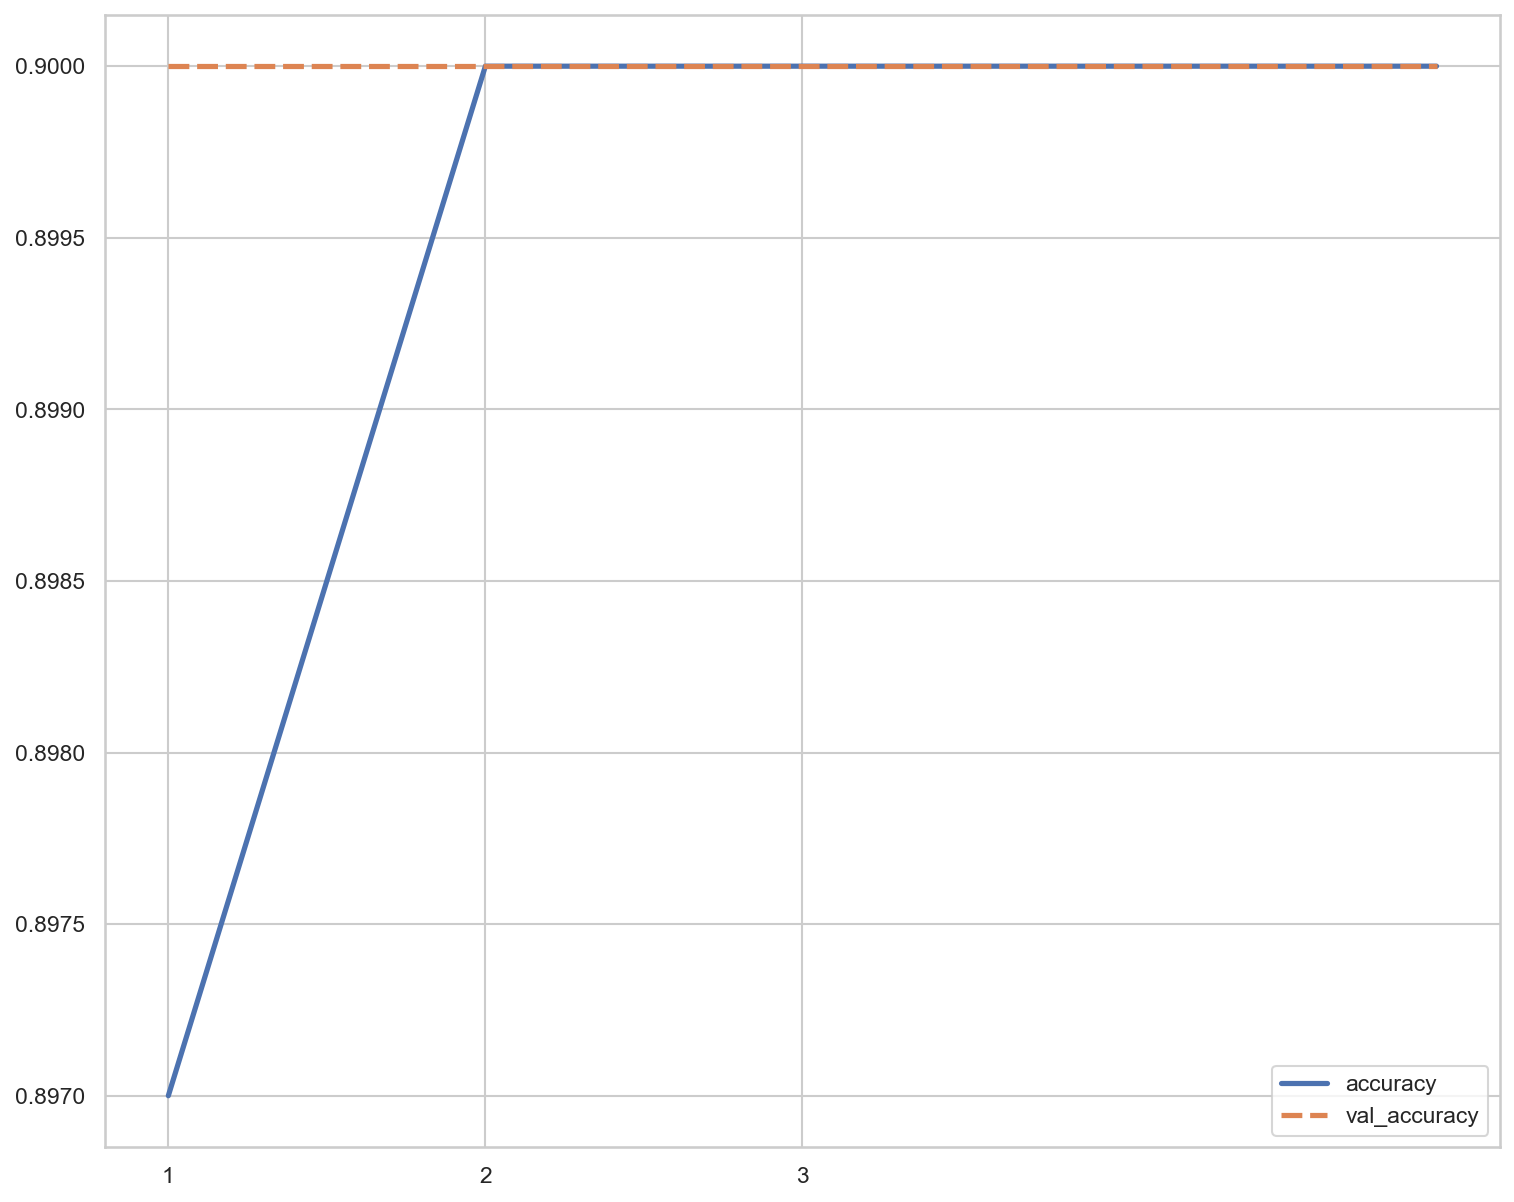

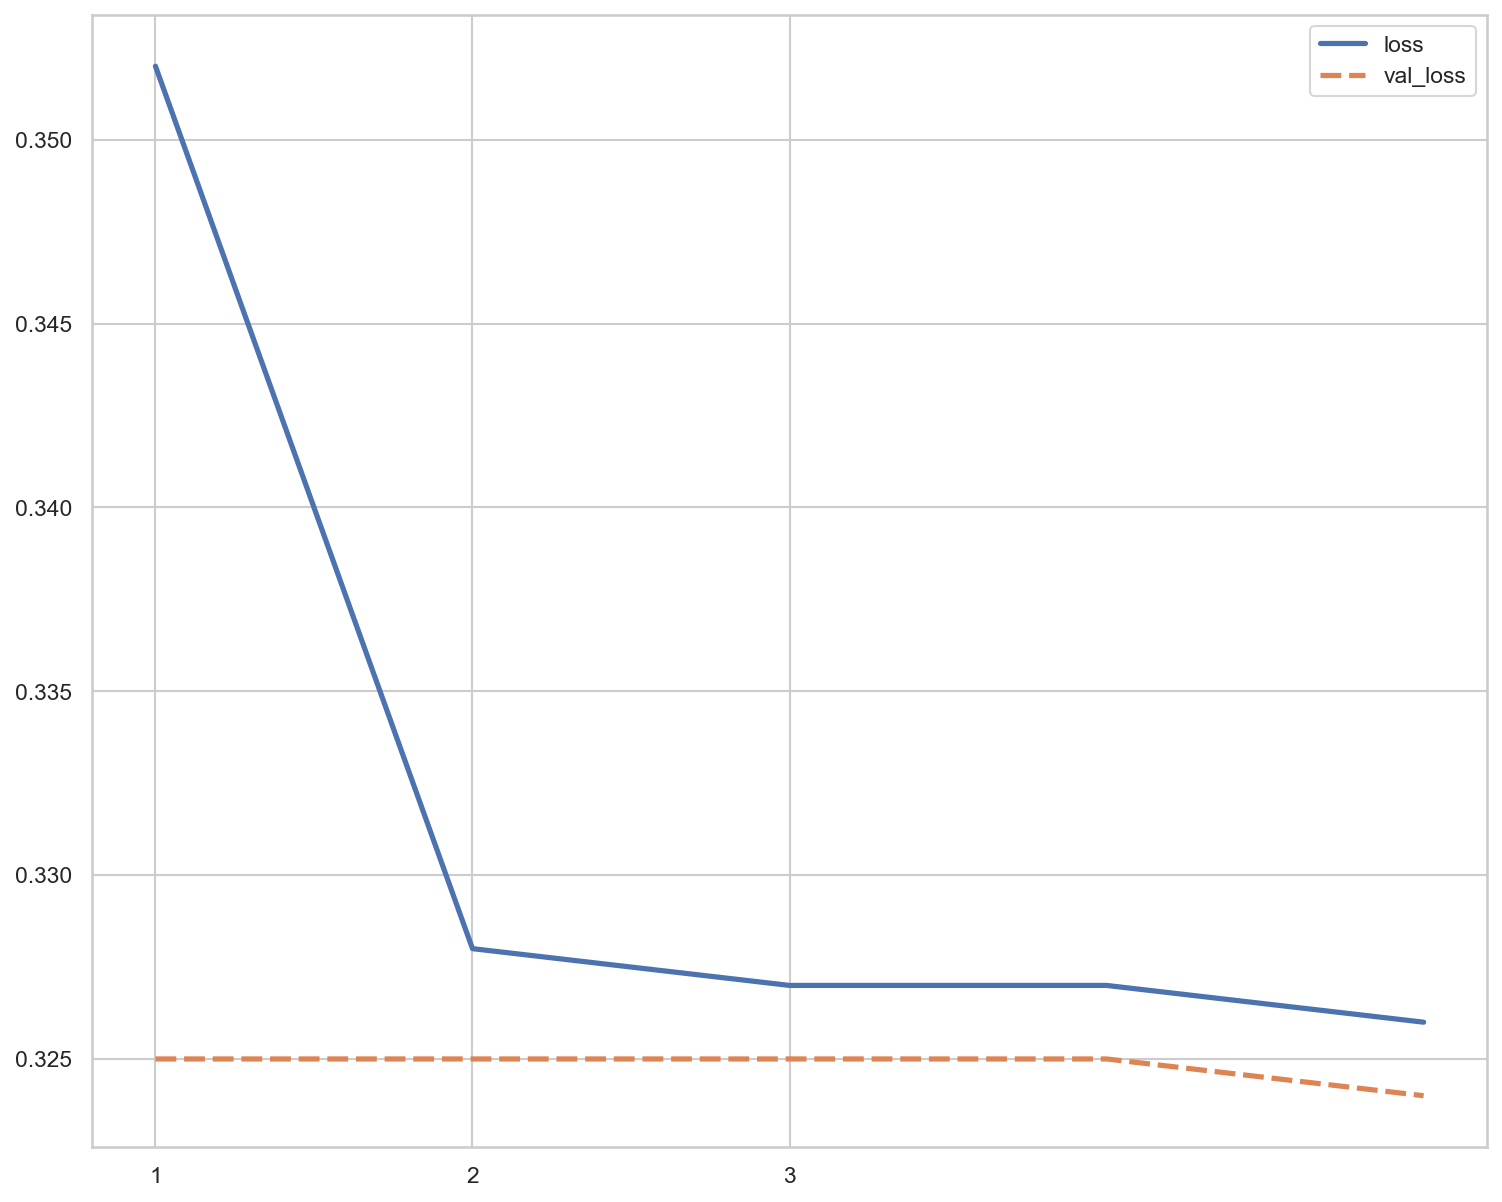

362/362 [==============================] - 7s 19ms/step
Accuracy: 0.9
Precision: 0.9
Recall / Sensitivity: 1.0
F1 Score: 0.947
ROC-AUC Score: 0.5
Confusion Matrix:
[[    0  1160]
 [    0 10424]]


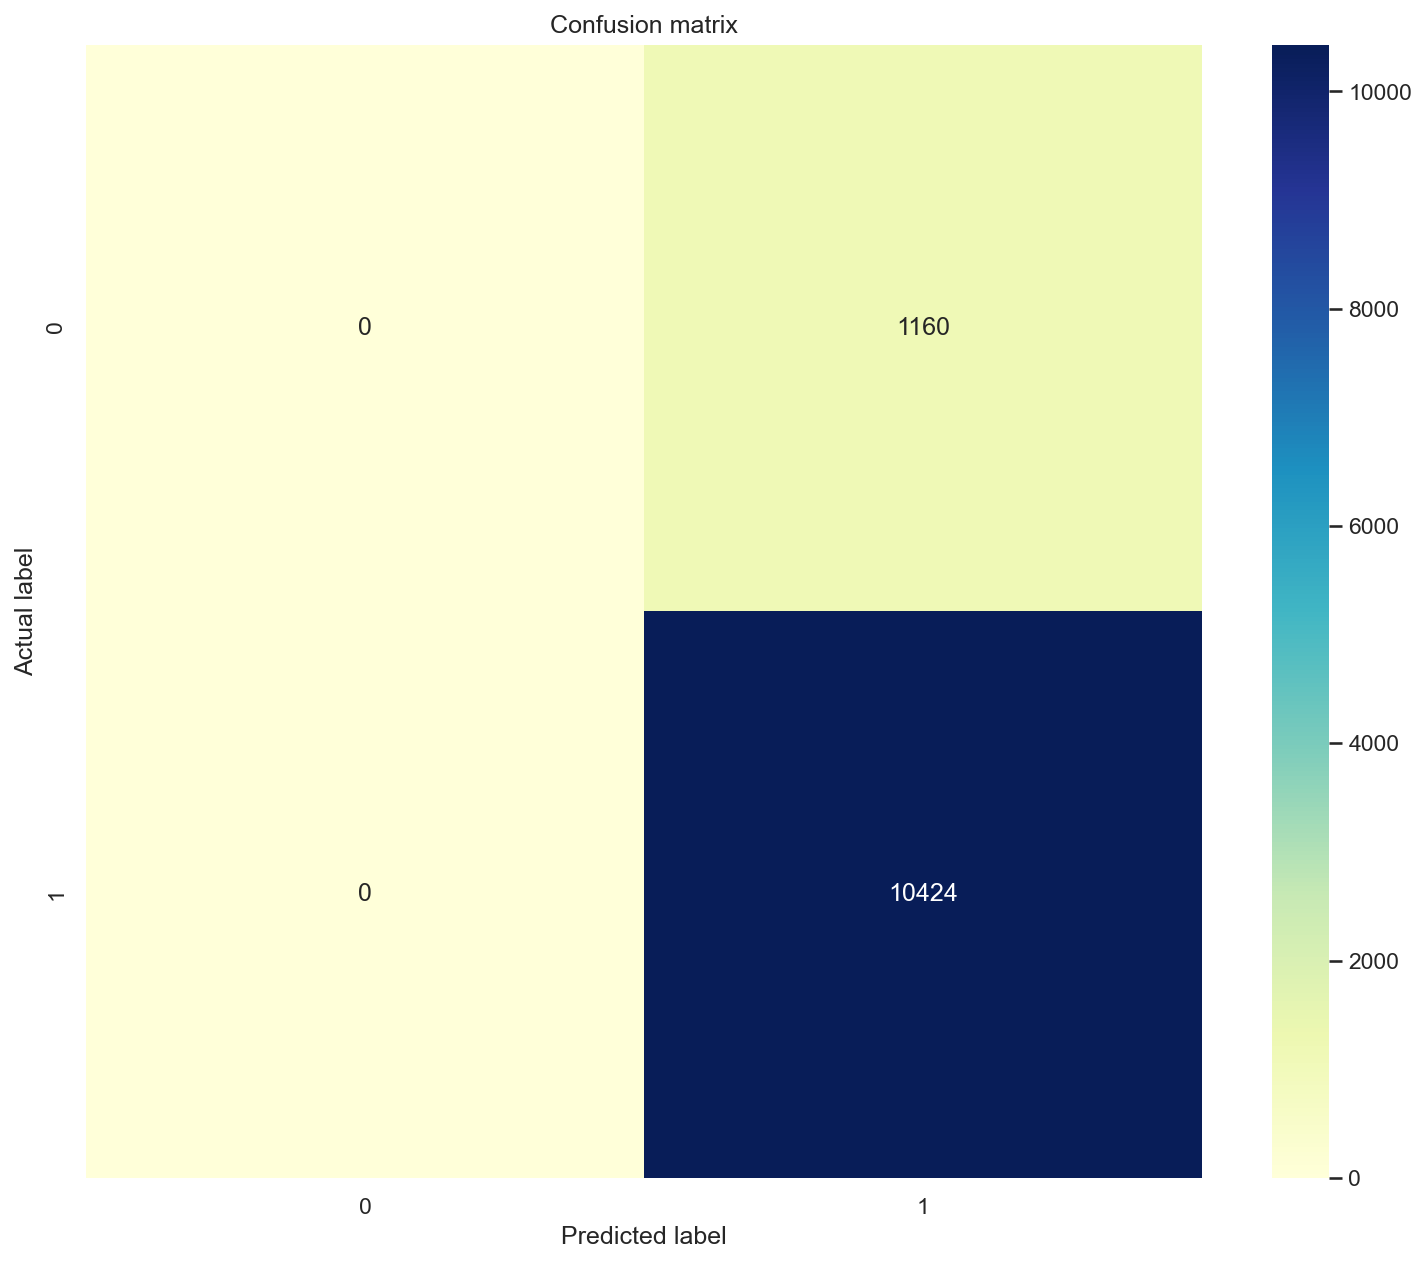

In [656]:
def create_network3():
    embedding_vector_length = 32
    embedding_vector_length = 64
    embedding_vector_length = max_sequence_embedding

    model = Sequential()
    
    embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=max_review_length )

    model.add(embedding_layer)


    model.add(SpatialDropout1D(rate=0.5))
    # model.add(Dropout(rate=0.25))

    LSTM

    model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(rate=0.20))
    

    # model.add(Flatten())
    model.add(Dense(units=1, activation="sigmoid"))

    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Prints a string summary of the network.
    model.summary()
    
    return model, embedding_layer

model3, embedding_layer = create_network3()


history3 = model3.fit(x=X_train, y=y_train, epochs=5, batch_size = 2**8, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))

plot_scores(history=history3, num_epochs = range(1,4), ticks=range(0,3))

y_pred3 = model3.predict(X_test).round().astype(np.int64)
create_conf_matrix(y_test, y_pred3)

In [573]:
# https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
# https://youtu.be/OuNH5kT-aD0
embedding_vector_length = 32
embedding_vector_length = max_sequence_embedding

# BUILD THE NETWORK
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
model = Sequential()

# input_dim : Size of the vocabulary
# output_dim : Length of the vector for each word
# input_length : Maximum length of a sequence
# Embedding
# Turns positive integers (indexes) into dense vectors of fixed size.
model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_vector_length, input_length=max_review_length ))


# SpatialDropout1D
# This version performs the same function as Dropout, however, it drops
# entire 1D feature maps instead of individual elements. If adjacent frames
# within feature maps are strongly correlated (as is normally the case in
# early convolution layers) then regular dropout will not regularize the
# activations and will otherwise just result in an effective learning rate
# decrease. In this case, SpatialDropout1D will help promote independence
# between feature maps and should be used instead.
model.add(SpatialDropout1D(rate=0.5))
# model.add(Dropout(rate=0.25))


model.add(LSTM(units=60, dropout=0.5, recurrent_dropout=0.5))

# Dropout
# The Dropout layer randomly sets input units to 0 with a frequency of `rate`
# at each step during training time, which helps prevent overfitting.
# Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over
# all inputs is unchanged.

# A simple solution to the overfitting problem is to use dropout, an operation that will randomly drop the weights connected to certain nodes in a layer during the training process, as shown on the right. This will force your network to develop more robust rules for classification, since it cannot rely on any particular nodes being passed to an activation function. This will tend to improve out-of-sample performance.
# we want to drop the weights connected to 20% of nodes randomly. We'll then pass this to the output layer, which reduces the 60 nodes to 1 and applies a sigmoid activation function
model.add(Dropout(rate=0.20))

model.add(Flatten())
# Dense
# output shape should be 1 since this is binary data
model.add(Dense(units=1, activation="sigmoid"))

# Configures the model for training.
# tf.keras.losses.BinaryCrossentropy()
# tf.keras.optimizers.Adam

# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Prints a string summary of the network.
model.summary()

# Model: "sequential_17"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  embedding_17 (Embedding)    (None, 316, 32)           3912672   
                                                                 
#  spatial_dropout1d_8 (Spatia  (None, 316, 32)          0         
#  lDropout1D)                                                     
                                                                 
#  lstm_15 (LSTM)              (None, 60)                22320     
                                                                 
#  dropout_20 (Dropout)        (None, 60)                0         
                                                                 
#  flatten_5 (Flatten)         (None, 60)                0         
                                                                 
#  dense_12 (Dense)            (None, 1)                 61        
                                                                 
# =================================================================
# Total params: 3,935,053
# Trainable params: 3,935,053
# Non-trainable params: 0

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 316, 19)           2323149   
                                                                 
 spatial_dropout1d_14 (Spati  (None, 316, 19)          0         
 alDropout1D)                                                    
                                                                 
 lstm_21 (LSTM)              (None, 60)                19200     
                                                                 
 dropout_26 (Dropout)        (None, 60)                0         
                                                                 
 flatten_11 (Flatten)        (None, 60)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 61        
                                                     

### ✅ 2.  Discuss the number of layers, the type of layers, and total number of parameters.

- The network includes 5 layers.

- The type of layers includes:
    - Input Embedding Layer
    - Spatial Dropout Layer
    - LSTM Layer
    - Dropout Layer
    - Output Dense Layer
 

- The total number of parameters is 4,158,477


### 3.  ✅ Justify the choice of hyperparameters, including the following elements:



#### ✅ activation functions
- Using a sigmoid activation function


#### ✅ number of nodes per layer
- The type of layers includes:
    - Input Embedding Layer
        - 1 neuron per feature or column
        - 1 optional neuron to hold bias 
    - Spatial Dropout Layer
        - 1/2 # neurons from previous layer
    - LSTM Layer
        - 1/2 # neurons from previous layer    
    - Dropout Layer
        - 1/2 # neurons from previous layer    
    - Output Dense Layer
        - 1 neuron to represent positive (1) or negative (-1) sentiment


#### ✅loss function
The loss function is Binary Crossentrophy


#### ✅ optimizer

The optimizer is ADAM

#### ✅ stopping criteria

The stopping criteria is EarlyStopping with a patience of 2

#### ✅ evaluation metric
The model's evaluation metrics are accuracy and loss.

# Part IV:  Model Evaluation



## D.  Evaluate the model training process and its relevant outcomes by doing the following:



In [678]:
X_train = df['padded_text'].to_list()
y_train = df["pos_neg_sentiment"].to_list()

X_test = test_df['padded_text'].to_list()
y_test = test_df["pos_neg_sentiment"].to_list()

In [682]:
test_df.shape

(11584, 3)

### 1.  Discuss the impact of using stopping criteria instead of defining the number of epochs, including a screenshot showing the final training epoch.

In [534]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

# Stop training when a monitored metric has stopped improving.
# helps avoid overfitting
# Assuming the goal of a training is to minimize the loss. With this, the
# metric to be monitored would be `'loss'`, and mode would be `'min'`. A
# `model.fit()` training loop will check at end of every epoch whether
# the loss is no longer decreasing, considering the `min_delta` and
# `patience` if applicable. Once it's found no longer decreasing,
# `model.stop_training` is marked True and the training terminates.

# This callback will stop the training when there is no improvement in
# the validation loss for two consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

Epoch 1/5
362/362 [==============================] - 94s 260ms/step - loss: 0.3179 - accuracy: 0.9015 - val_loss: 0.3286 - val_accuracy: 0.8998
Epoch 2/5
362/362 [==============================] - 84s 232ms/step - loss: 0.3180 - accuracy: 0.9016 - val_loss: 0.3273 - val_accuracy: 0.8994
Epoch 3/5
362/362 [==============================] - 85s 233ms/step - loss: 0.3175 - accuracy: 0.9016 - val_loss: 0.3292 - val_accuracy: 0.8998
Epoch 4/5
362/362 [==============================] - 86s 236ms/step - loss: 0.3175 - accuracy: 0.9017 - val_loss: 0.3278 - val_accuracy: 0.8998
Epoch 5/5
362/362 [==============================] - 84s 231ms/step - loss: 0.3180 - accuracy: 0.9016 - val_loss: 0.3264 - val_accuracy: 0.8998


In [ ]:
# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(x=X_train, y=y_train, epochs=5, batch_size = 128, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))
model.save("model_1.keras")

In [570]:
history = model.fit(x=X_train, y=y_train, epochs=5, batch_size = 128, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))


Epoch 1/5
362/362 [==============================] - 99s 269ms/step - loss: 0.3404 - accuracy: 0.8992 - val_loss: 0.3278 - val_accuracy: 0.8999
Epoch 2/5
362/362 [==============================] - 83s 230ms/step - loss: 0.3268 - accuracy: 0.8998 - val_loss: 0.3246 - val_accuracy: 0.8999
Epoch 3/5
362/362 [==============================] - 83s 230ms/step - loss: 0.3265 - accuracy: 0.8998 - val_loss: 0.3246 - val_accuracy: 0.8999
Epoch 4/5
362/362 [==============================] - 85s 234ms/step - loss: 0.3250 - accuracy: 0.8998 - val_loss: 0.3241 - val_accuracy: 0.8999
Epoch 5/5
362/362 [==============================] - 84s 231ms/step - loss: 0.3251 - accuracy: 0.8998 - val_loss: 0.3258 - val_accuracy: 0.8999


In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=5, batch_size = 160, callbacks=[callback], validation_split=0.2, validation_data=(X_test, y_test))


### 2.  ✅ Provide visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric.

In [250]:
def plot_scores(history, model, num_epochs = range(1,6), ticks=range(0,5), include_test=False, X_test=None, y_test=None):
    hist_df = pd.DataFrame(history.history).round(3)
    display(hist_df)
    accuracy_cols = ["accuracy", "val_accuracy"]
    loss_cols = ["loss", "val_loss"]
    
    if include_test:
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        hist_df["test_loss"] = test_loss
        hist_df["test_accuracy"] = test_accuracy
        accuracy_cols.append("test_accuracy")
        loss_cols.append("test_loss")
        

    # _ = sns.lineplot(hist_df[["accuracy", "val_accuracy"]])
    _ = sns.lineplot(data=hist_df[accuracy_cols])
    _ = plt.xticks(ticks=ticks, labels=num_epochs)
    plt.show()

    _ = sns.lineplot(data=hist_df[loss_cols])
    _ = plt.xticks(ticks=ticks, labels=num_epochs)
    plt.show()
    

3

,loss,accuracy,val_loss,val_accuracy
0,0.42,0.80,0.34,0.85
1,0.23,0.91,0.37,0.85
2,0.15,0.94,0.42,0.84


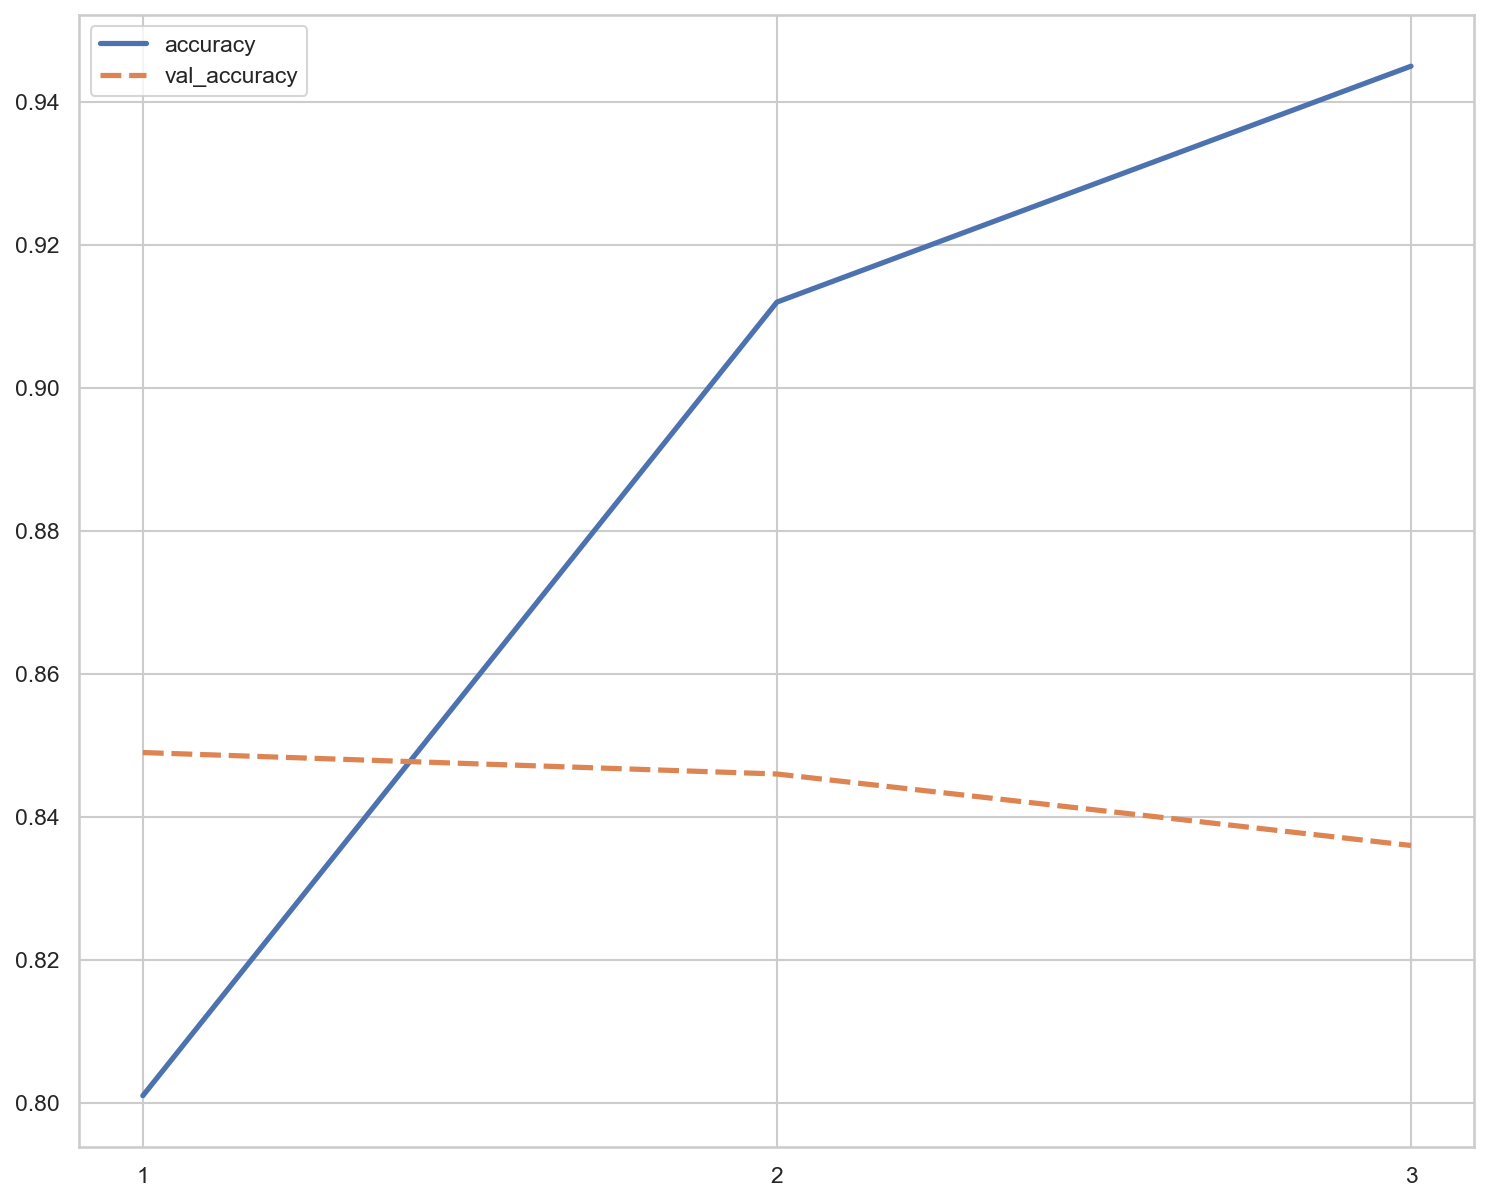

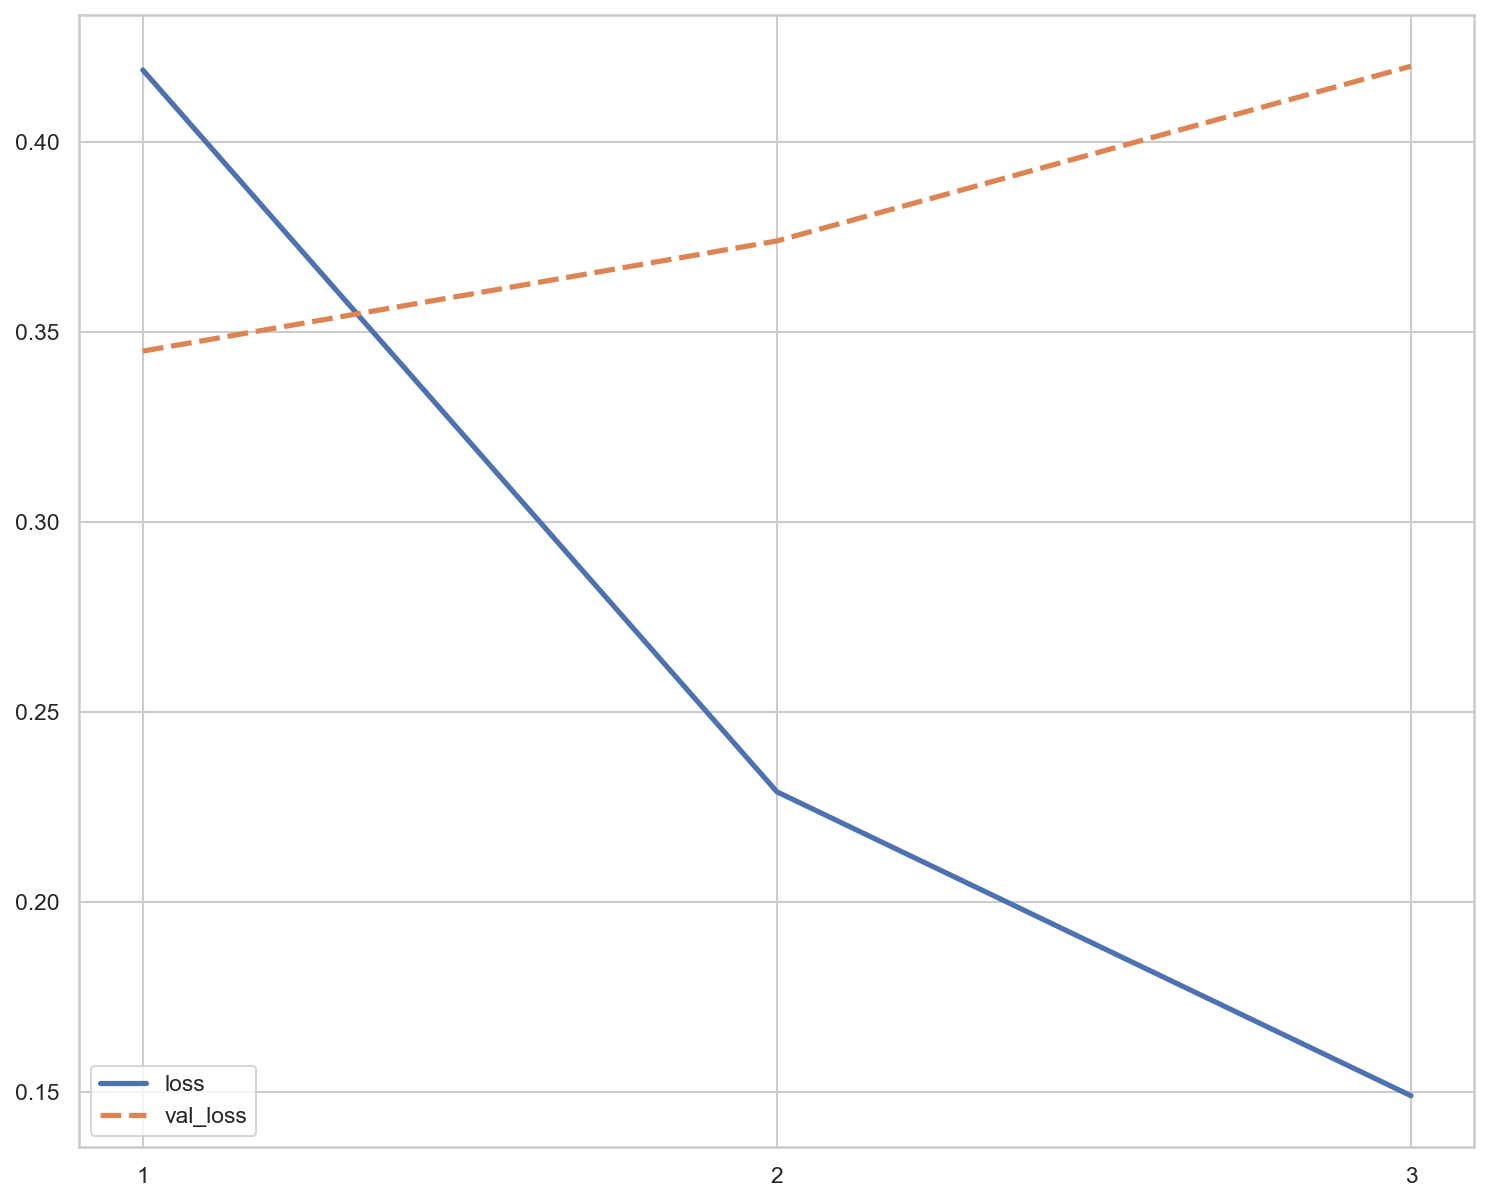

In [258]:
num_epochs = len(history.history.get("loss", []))
num_epochs
plot_scores(history=history, model=model, num_epochs = range(1,num_epochs+1), ticks=range(0,num_epochs))


,loss,accuracy,val_loss,val_accuracy
0,0.34,0.90,0.33,0.90
1,0.33,0.90,0.33,0.90
2,0.33,0.90,0.33,0.90
3,0.33,0.90,0.32,0.90
4,0.33,0.90,0.33,0.90


362/362 [==============================] - 7s 19ms/step - loss: 0.6926 - accuracy: 0.8638


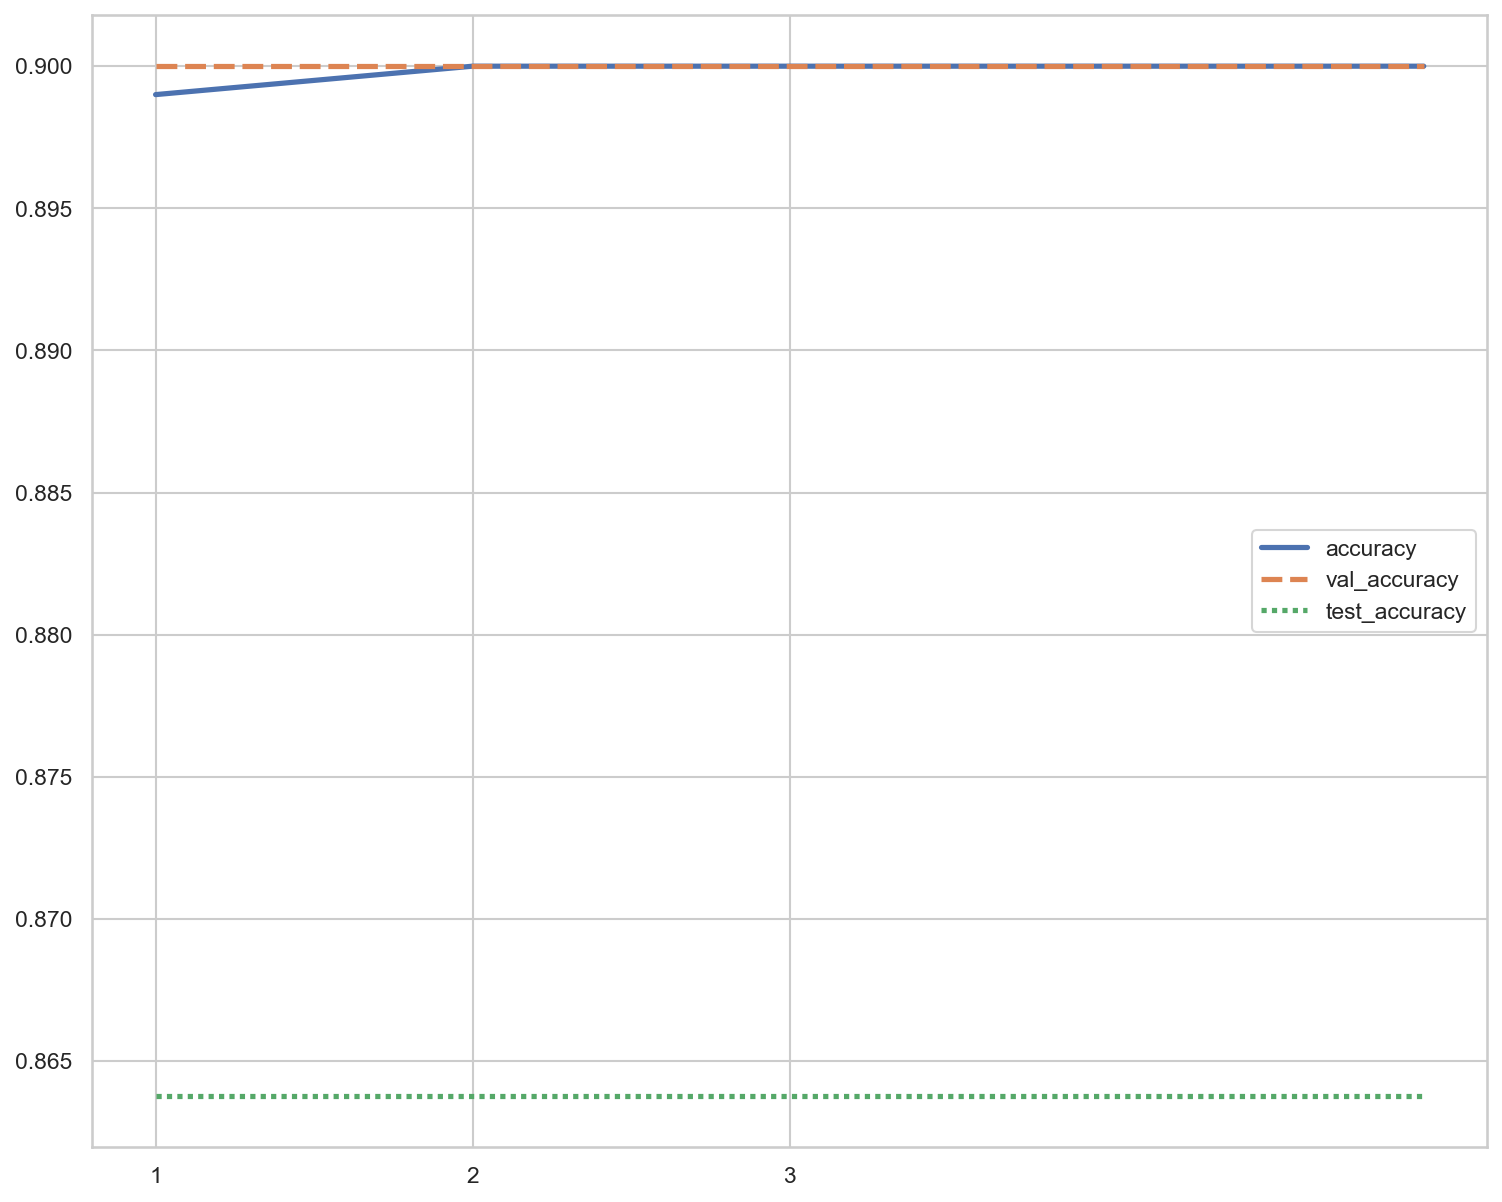

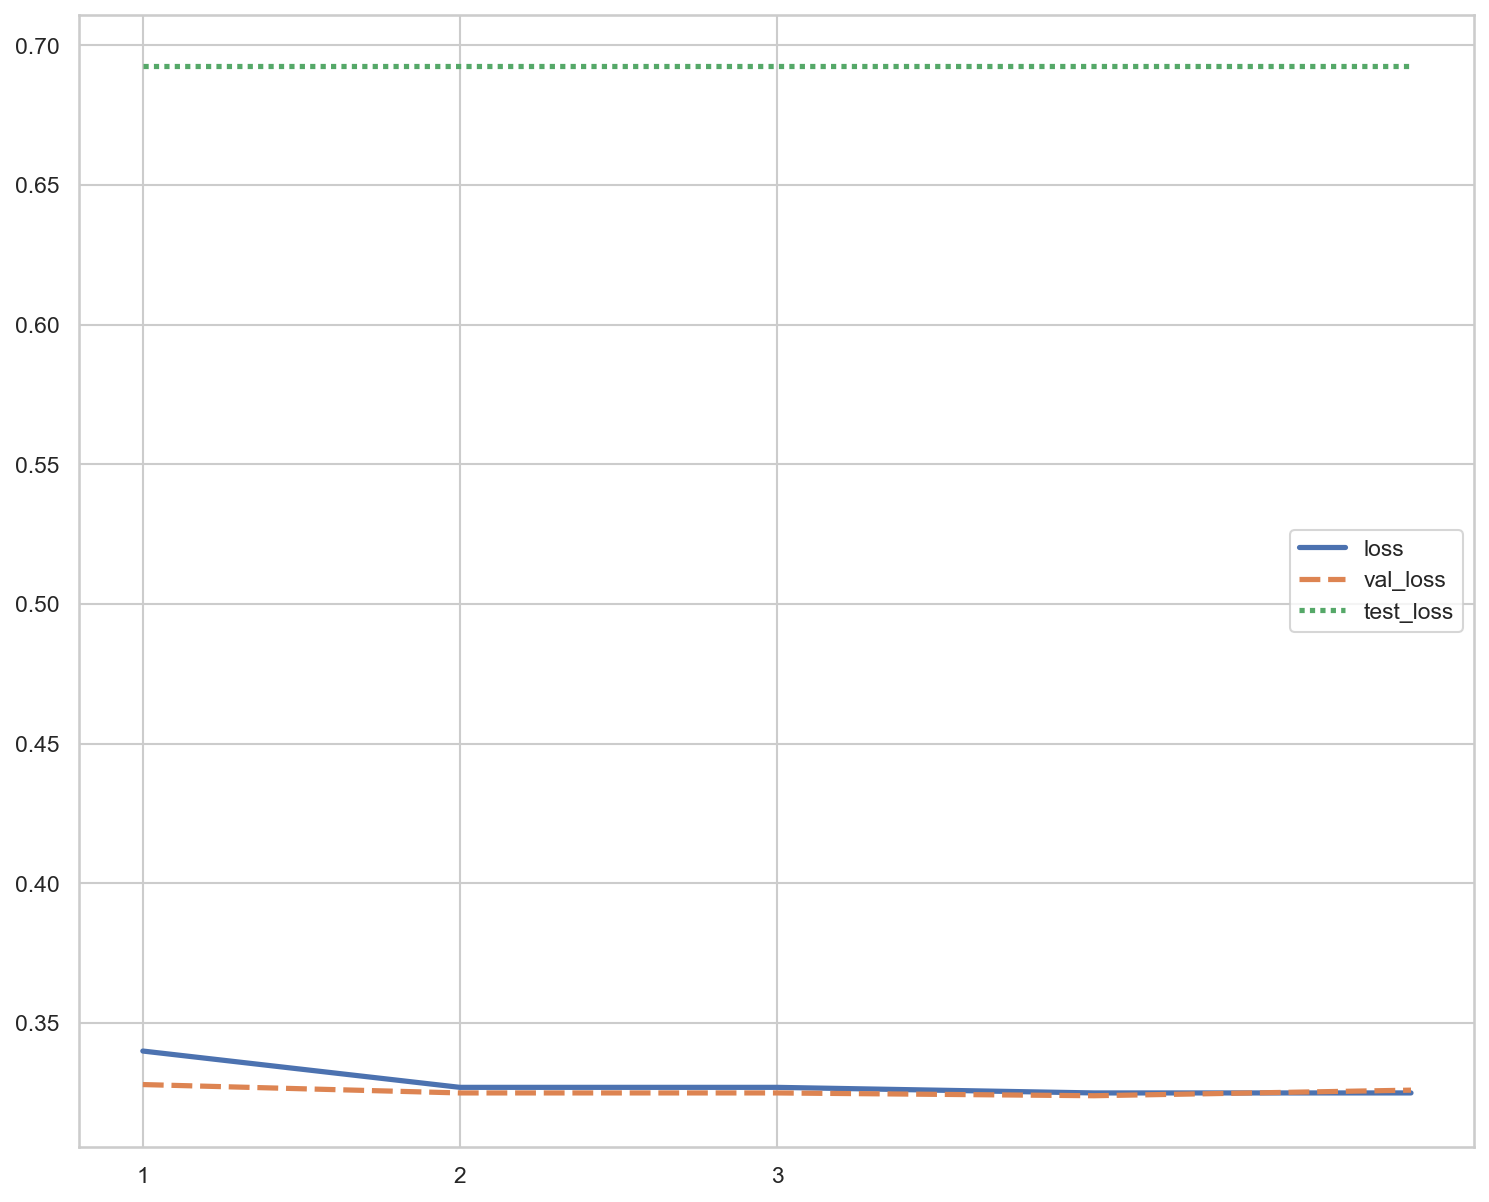

In [575]:
plot_scores(history=history, num_epochs = range(1,4), ticks=range(0,3), include_test=True, X_test=X_test, y_test=y_test)


### ✅ 3.  Assess the fitness of the model and any measures taken to address overfitting.

- dropout
- stopping criteria

In [657]:
# MODEL EVALUATION AGAINST TEST


test_loss, test_accuracy = model.evaluate(X_test, y_test)
test_loss, test_accuracy


362/362 [==============================] - 7s 20ms/step - loss: 0.6926 - accuracy: 0.8638


(0.6925657987594604, 0.8637776374816895)

In [576]:
y_pred = model.predict(X_test).round().astype(np.int64)


y_pred

# .argmax(axis=1)

362/362 [==============================] - 7s 19ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [658]:
test_df["prediction"] = y_pred
test_df.sample(n=20)

# test_df[test_df["prediction"] == 0]


# TOKENIZER.sequences_to_texts(test_df.padded_text)

,raw_text,padded_text,pos_neg_sentiment,prediction
9314,"Fusion is a stupid term. Any marketing label that describes both In A Silent Way and Donald Byrds 70s funk encompesses almost anything and says absolutely nothing. In 1969, when rock and jazz were intersecting, there was no brand name, and we were better off.Songs For A Tailor is Jack Bruce's perfect example of how powerful albums can be when you stop thinking in boxes and just make great music. Maraculous music.Bruce released this not long after Cream broke up. Truth is, he had been a jazz bassist since the early 60s, and applied his chops in the power trio of all power trios. Here, he took it to the next level.The songs here are not longer than the average rock song, and the structures are also rock based. But the numbers boast hairpin chord progressions, Bruce's absolutely athletic fuzz bass playing, and his second to none singing. None of the peices go in perdictable directions, although the chord movements are inceadibly melodic.Most of this work is soaked in the blues, but an increadibly advanced take on the genre. Listen to how the bass is almost the lead instrument on the opening track, or how ""Rope Ladder To The Moon"" uses a cello as its flagship instrument. Despite Bruce's genius at creating new textures through dozens of small alterations, the music remains as accessible as it is sophisticated, rocking as it is cerebral.Now to make fantistc music, even Jack Bruce needs a fantastic band. We have Chris Spedding on guitar, and English jazz pros like Dick Haskell-Smith. Smith was about to make a big noise of his own, baptizing the brand new great Vertigo label with his own band, Colliseum, who supply Bruce's horns here.Music just does not get better than this.","[1884, 1222, 794, 3538, 494, 3107, 2718, 35, 3433, 4180, 218, 1, 136, 214, 49, 489, 155, 23, 197, 1, 5, 1348, 259, 44, 3, 1, 768, 1, 178, 445, 424, 2, 351, 860, 927, 25, 11, 10, 1, 10, 1318, 96, 91, 1678, 1540, 814, 197, 1657, 105, 189, 1, 2232, 308, 1764, 308, 1764, 402, 152, 557, 3, 869, 784, 23, 3, 1462, 28, 23, 706, 196, 3186, 1, 866, 2156, 1, 489, 1, 1, 217, 216, 137, 707, 200, 707, 1, 53, 1, 754, 180, 866, 1536, 1, 488, 52, 1, 113, 1, 1, 65, 397, 56, ...]",1,1
3910,"The peak of his powers. Not his best album (Purple Rain) but not far behind. Prince was only capable of brilliance at this point in his career. He still makes brilliant music nowadays. Some people don't like the way he's moved into more strickly ""black"" (heh) music, but he is just moving, changing always. If he was still playing music like this now, people wouldn't treat him seriously. Sometimes people don't now, but he still gets a lot of respect and sells out concerts and his newest album was at the top of the charts for a long time. If he feels like it, he can be at the top. If he doesn't, he doesn't.Either way, in almost every album he's done, he oozes artistic credibility. Yes, he's a pop star, but a self perpetuating pop star. Even if he had no record label deal, he could do albums even if he had to play and produce every note. Wait... he's already done that!Anyways, to this album. Every song is great. Every song is immaculately arranged. He had ditched the Revolution on this album for some reason, so it's back to one man band. But this isn't the one man band of 1999: this is a different one man band, a man who has learned lessons from being a band, and while there is a scaling back on the lushness and improptu energy of a Revolution recording, he still makes these songs full, and REAL sounding, one of the only one man artists who can make an album where he plays all the instruments sound like a funky band improvising. God bless the man. Even his weirdness.","[1102, 308, 17, 2, 941, 705, 151, 511, 730, 5, 1656, 1706, 187, 233, 24, 25, 350, 10, 2698, 71, 7, 35, 207, 1590, 1, 250, 1, 10, 652, 1925, 92, 5, 24, 216, 10, 7, 71, 1276, 1004, 399, 71, 24, 18, 80, 816, 902, 522, 3400, 2, 5, 108, 418, 91, 15, 69, 7, 108, 335, 35, 136, 67,


### 4.  Discuss the predictive accuracy of the trained network.


In [660]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def create_conf_matrix(y_test, y_pred):
    c_matrix = metrics.confusion_matrix(y_test, y_pred)
    (tn, fp), (fn, tp) = c_matrix
    rnd = lambda v: v.round(3)

    sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu", fmt="g")
    plt.title("Confusion matrix", y=1.1)
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

    print("Accuracy:", rnd(metrics.accuracy_score(y_test, y_pred)))
    print("Precision:", rnd(metrics.precision_score(y_test, y_pred)))
    print(
        "Recall / Sensitivity:",
        rnd(metrics.recall_score(y_test, y_pred)),
    )
    print("F1 Score:", rnd(metrics.f1_score(y_test, y_pred)))
    print("ROC-AUC Score:", rnd(metrics.roc_auc_score(y_test, y_pred)))
    print("Confusion Matrix:")
    print(c_matrix)

    plt.show()

create_conf_matrix(y_test, y_pred)
model.summary()

In [495]:
def predict_sentiment(text, tokenizer):
    # tokenizer = Tokenizer(num_words=5000)
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=max_review_length)
    prediction = int(model.predict(tw).round().item())
    return prediction

# predict_sentiment(text)
# predict_sentiment(prep_df.)

# test_df.iloc[0].words

prep_df.head(1)
predict_sentiment([prep_df.raw_text[0]], tokenizer=TOKENIZER)



,raw_text,sentiment,raw_word_count,clean_text,clean_word_count,encoded_text,padded_text,pos_neg_sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5,153,hard believe memory tree came year ago ha held well passage time enya's last great album new age pop amarantine day without rain back enya still creative spark voice agree reviewer said saddest album melancholy bittersweet opening title song memory tree elegaic majestic pax deorum sound like requiem mass dark threnody unlike reviewer said ha disconcerting blend spirituality sensuality find disconcerting anywhere hopeful song looking possibility hope ha place love listener decide romantic platonic etc i've always soft spot song way home triumphant ending return truly masterpiece new age music must enya fan,93,"[86, 289, 787, 1476, 161, 30, 439, 9, 1917, 22, 2745, 15, 1, 84, 11, 2, 32, 475, 48, 1, 66, 149, 705, 36, 1, 24, 587, 1680, 59, 1016, 694, 208, 1, 2, 1399, 3332, 414, 110, 3, 787, 1476, 1, 3736, 1, 1, 14, 7, 1, 1685, 297, 1, 697, 694, 208, 9, 1, 815, 4958, 1, 115, 1, 1760, 3975, 3, 381, 3943, 383, 9, 222, 16, 305, 2436, 978, 1, 533, 138, 92, 552, 1009, 3, 35, 318, 1, 1079, 595, 240, 320, 32, 475, 10, 159, 1, 34]","[86, 289, 787, 1476, 161, 30, 439, 9, 1917, 22, 2745, 15, 1, 84, 11, 2, 32, 475, 48, 1, 66, 149, 705, 36, 1, 24, 587, 1680, 59, 1016, 694, 208, 1, 2, 1399, 3332, 414, 110, 3, 787, 1476, 1, 3736, 1, 1, 14, 7, 1, 1685, 297, 1, 697, 694, 208, 9, 1, 815, 4958, 1, 115, 1, 1760, 3975, 3, 381, 3943, 383, 9, 222, 16, 305, 2436, 978, 1, 533, 138, 92, 552, 1009, 3, 35, 318, 1, 1079, 595, 240, 320, 32, 475, 10, 159, 1, 34, 0, 0, 0, 0, 0, 0, 0, ...]",1


1/1 [==============================] - 0s 36ms/step


1

# Part V:  Summary and Recommendations



## E.  Provide the code used to save the trained network within the neural network.


## F.  Discuss the functionality of your neural network, including the impact of the network architecture.


## G.  Recommend a course of action based on your results.



# Part VI: Reporting



## H.  Create your neural network using an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.


## ✅ I.  List the web sources used to acquire data or segments of third-party code to support the application.

- https://builtin.com/data-science/feedforward-neural-network-intro
- https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type
- https://developers.google.com/machine-learning/glossary
- https://github.com/keras-team/keras/blob/v2.10.0/keras/preprocessing/text.py#L194-L575
- https://medium.com/mlearning-ai/introduction-to-neural-networks-weights-biases-and-activation-270ebf2545aa
- https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
- https://stackoverflow.com/questions/58270692/write-pandas-dataframe-with-list-in-column-to-a-file
- https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
- https://stackoverflow.com/questions/62060809/column-dtype-with-pandas-read-json
- https://stackoverflow.com/questions/63614790/why-am-i-getting-the-error-re-error-multiple-repeat-at-position-2
- https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/
- https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
- https://www.educba.com/recurrent-neural-networks-rnn/
- https://www.geeksforgeeks.org/dropout-in-neural-networks/
- https://www.nltk.org/api/nltk.tokenize.regexp.html
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

## ✅ J.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

- https://www.geeksforgeeks.org/dropout-in-neural-networks/
- https://builtin.com/data-science/feedforward-neural-network-intro
- https://medium.com/mlearning-ai/introduction-to-neural-networks-weights-biases-and-activation-270ebf2545aa
- https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
- https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
- https://www.educba.com/recurrent-neural-networks-rnn/
- https://developers.google.com/machine-learning/glossary
- https://www.nltk.org/api/nltk.tokenize.regexp.html
- https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
-
-
-
-
-
-

